## Applied AI Assignment ##
## Diabetes Dataset ##

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import os
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC



In [ ]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/COMP0189/diabetic_data.csv')

In [ ]:
admission_type_mappings = pd.read_csv('/content/drive/MyDrive/COMP0189/IDs_mapping.csv', nrows =8)
admission_type_mappings

admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available
5                  6            NaN
6                  7  Trauma Center
7                  8     Not Mapped

In [ ]:
discharge_disposition_mappings = pd.read_csv('/content/drive/MyDrive/COMP0189/IDs_mapping.csv', skiprows=range(1, 11), nrows=41 - 12 + 1)
discharge_disposition_mappings

admission_type_id                                        description
0                   1                                 Discharged to home
1                   2  Discharged/transferred to another short term h...
2                   3                      Discharged/transferred to SNF
3                   4                      Discharged/transferred to ICF
4                   5  Discharged/transferred to another type of inpa...
5                   6  Discharged/transferred to home with home healt...
6                   7                                           Left AMA
7                   8  Discharged/transferred to home under care of H...
8                   9          Admitted as an inpatient to this hospital
9                  10  Neonate discharged to another hospital for neo...
10                 11                                            Expired
11                 12  Still patient or expected to return for outpat...
12                 13                                     Hospice / home
13                 14                         Hospice / medical facility
14                 15  Discharged/transferred within this institution...
15                 16  Discharged/transferred/referred another instit...
16                 17  Discharged/transferred/referred to this instit...
17                 18                                                NaN
18                 19           Expired at home. Medicaid only, hospice.
19                 20  Expired in a medical facility. Medicaid only, ...
20                 21    Expired, place unknown. Medicaid only, hospice.
21                 22  Discharged/transferred to another rehab fac in...
22                 23  Discharged/transferred to a long term care hos...
23                 24  Discharged/transferred to a nursing facility c...
24                 25                                         Not Mapped
25                 26                                    Unknown/Invalid
26                 30  Discharged/transferred to another Type of Heal...
27                 27  Discharged/transferred to a federal health car...
28                 28  Discharged/transferred/referred to a psychiatr...
29                 29  Discharged/transferred to a Critical Access Ho...

In [ ]:
admission_source_id = pd.read_csv('/content/drive/MyDrive/COMP0189/IDs_mapping.csv', skiprows=range(1, 43), nrows=68 - 44 + 1)
admission_source_id

admission_type_id                                        description
0                   1                                 Physician Referral
1                   2                                    Clinic Referral
2                   3                                       HMO Referral
3                   4                           Transfer from a hospital
4                   5     Transfer from a Skilled Nursing Facility (SNF)
5                   6         Transfer from another health care facility
6                   7                                     Emergency Room
7                   8                              Court/Law Enforcement
8                   9                                      Not Available
9                  10              Transfer from critial access hospital
10                 11                                    Normal Delivery
11                 12                                 Premature Delivery
12                 13                                          Sick Baby
13                 14                                   Extramural Birth
14                 15                                      Not Available
15                 17                                                NaN
16                 18           Transfer From Another Home Health Agency
17                 19             Readmission to Same Home Health Agency
18                 20                                         Not Mapped
19                 21                                    Unknown/Invalid
20                 22   Transfer from hospital inpt/same fac reslt in...
21                 23                          Born inside this hospital
22                 24                         Born outside this hospital
23                 25            Transfer from Ambulatory Surgery Center
24                 26                              Transfer from Hospice

In [ ]:
admission_type_mappings

admission_type_id    description
0                  1      Emergency
1                  2         Urgent
2                  3       Elective
3                  4        Newborn
4                  5  Not Available
5                  6            NaN
6                  7  Trauma Center
7                  8     Not Mapped

## Task 1: Data Analysis##

In [ ]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    numerical_df = dataframe.select_dtypes(include=np.number)

    print(numerical_df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

df.columns = [col.upper() for col in df.columns]

In [ ]:
check_df(df)

##################### Shape #####################
(101766, 50)
##################### Types #####################
ENCOUNTER_ID                 int64
PATIENT_NBR                  int64
RACE                        object
GENDER                      object
AGE                         object
WEIGHT                      object
ADMISSION_TYPE_ID            int64
DISCHARGE_DISPOSITION_ID     int64
ADMISSION_SOURCE_ID          int64
TIME_IN_HOSPITAL             int64
PAYER_CODE                  object
MEDICAL_SPECIALTY           object
NUM_LAB_PROCEDURES           int64
NUM_PROCEDURES               int64
NUM_MEDICATIONS              int64
NUMBER_OUTPATIENT            int64
NUMBER_EMERGENCY             int64
NUMBER_INPATIENT             int64
DIAG_1                      object
DIAG_2                      object
DIAG_3                      object
NUMBER_DIAGNOSES             int64
MAX_GLU_SERUM               object
A1CRESULT                   object
METFORMIN                   object
REPAGLINIDE 

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 101766
Variables: 50
cat_cols: 35
num_cols: 11
cat_but_car: 4
num_but_cat: 2


            READMITTED      Ratio
READMITTED                       
NO               54864  53.911916
>30              35545  34.928169
<30              11357  11.159916
##########################################


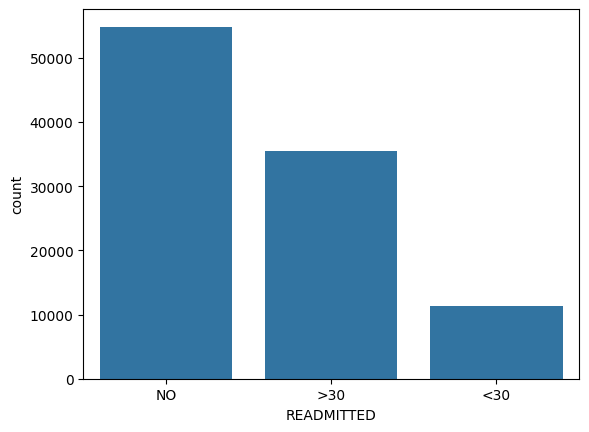

In [ ]:
# analysis of response variable before concatenating
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


cat_summary(df, "READMITTED",plot=True)


In [ ]:
# adjust READMITTED to Yes or no
df['READMITTED'] = df['READMITTED'].apply(lambda x: 'YES' if x != 'NO' else 'NO')

In [ ]:
cat_summary(df, "READMITTED",plot=True)


            READMITTED      Ratio
READMITTED                       
NO               54864  53.911916
YES              46902  46.088084
##########################################


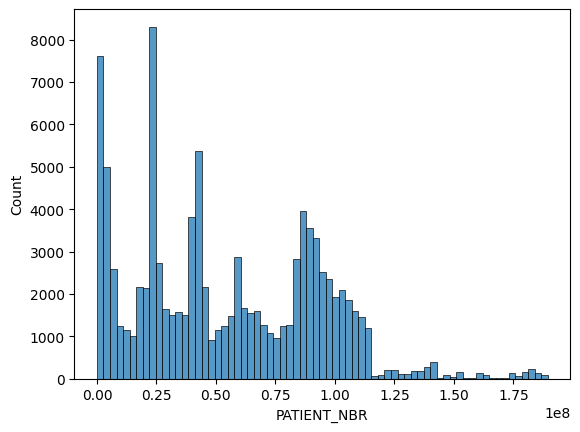

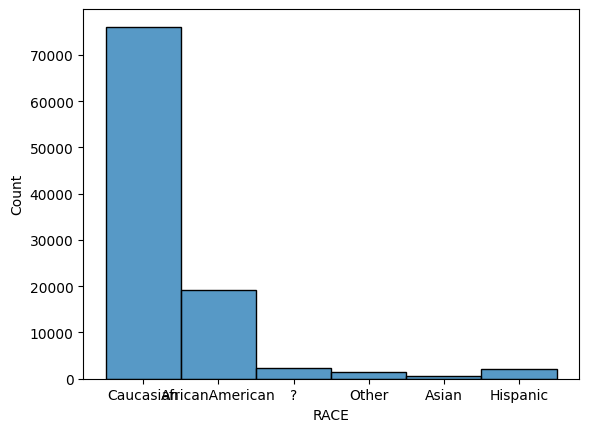

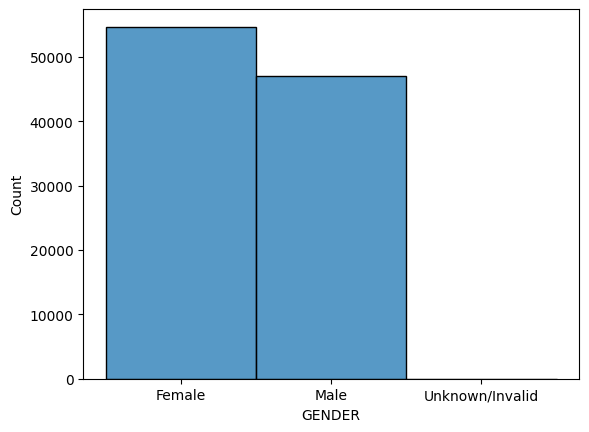

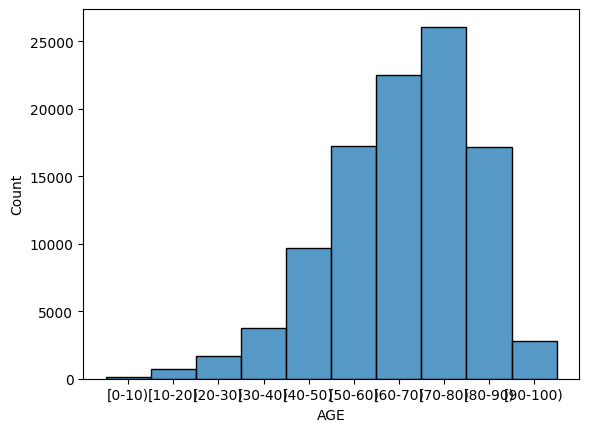

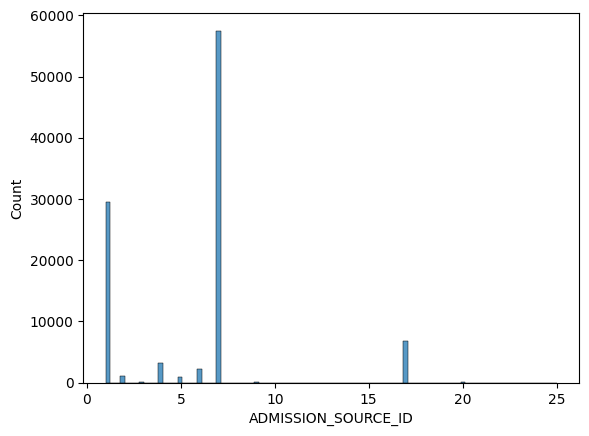

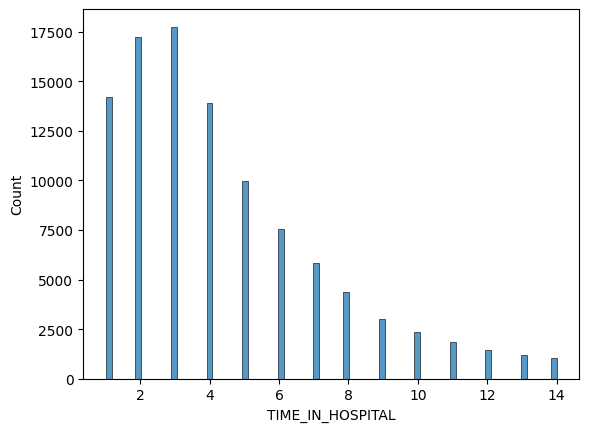

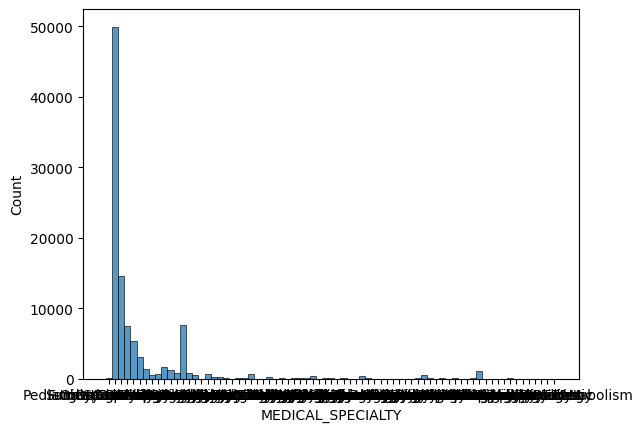

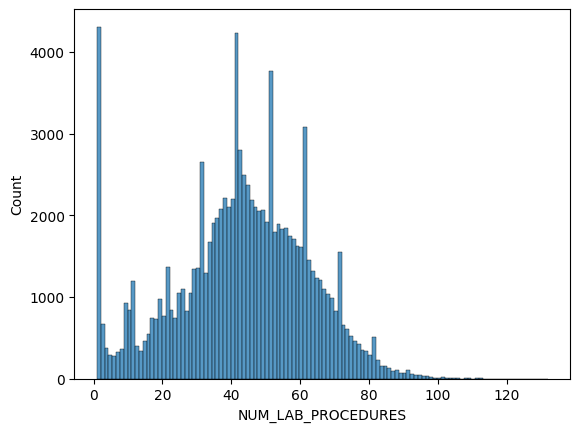

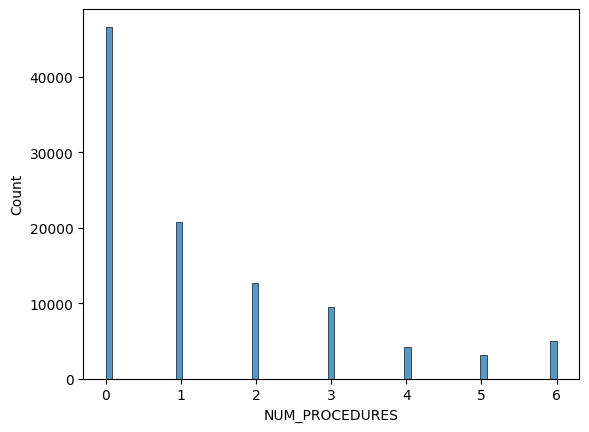

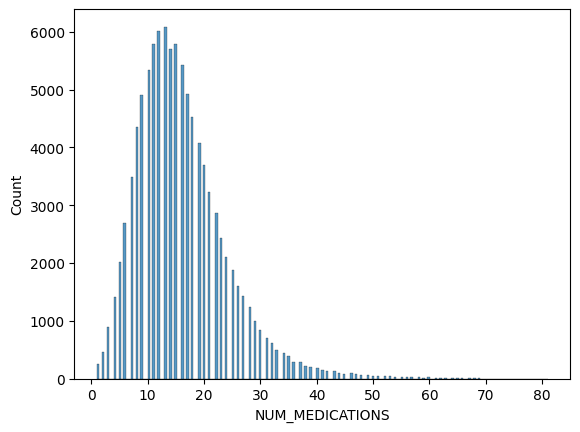

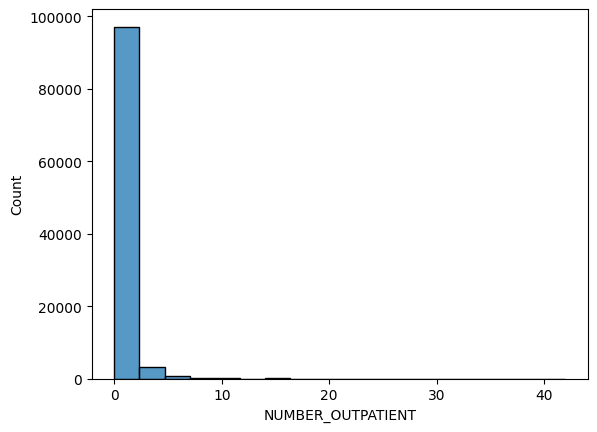

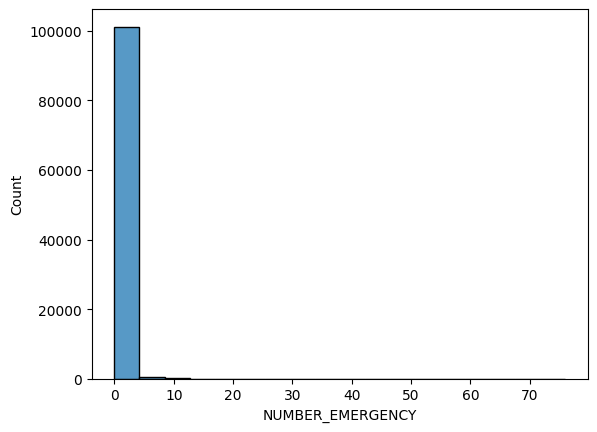

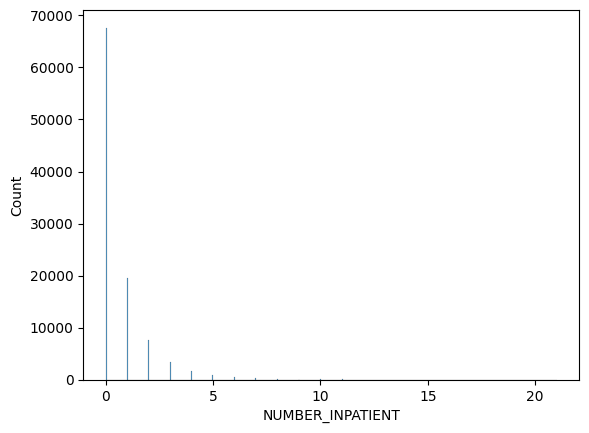

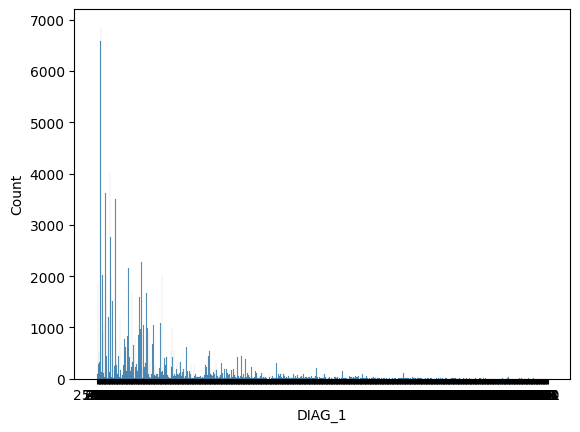

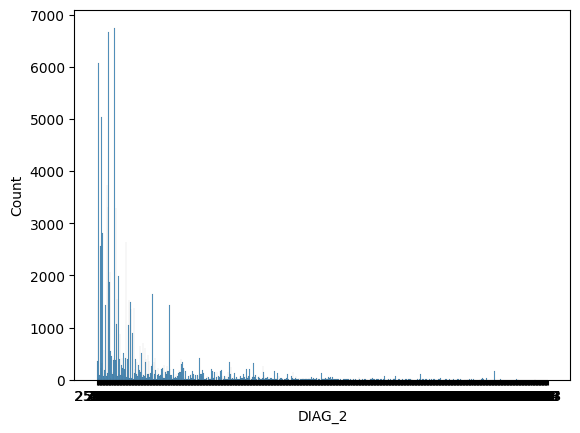

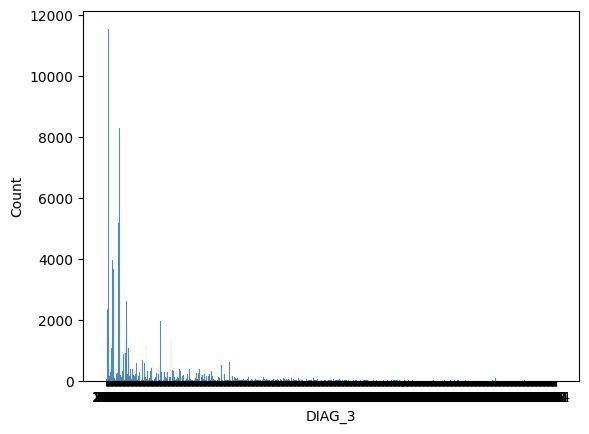

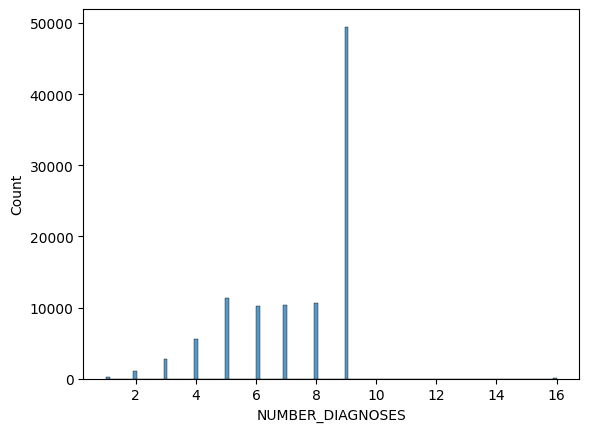

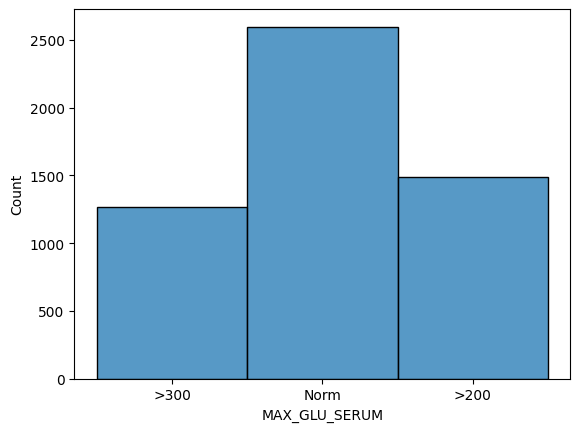

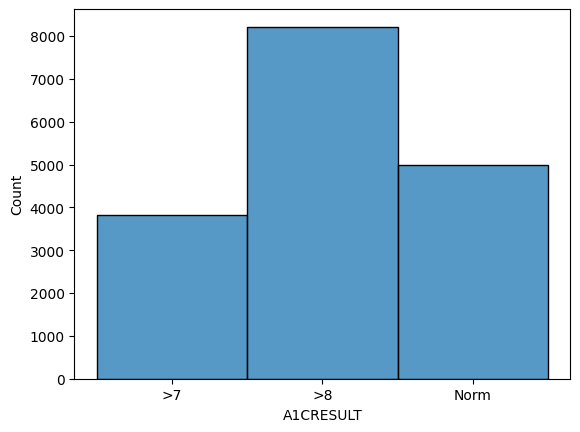

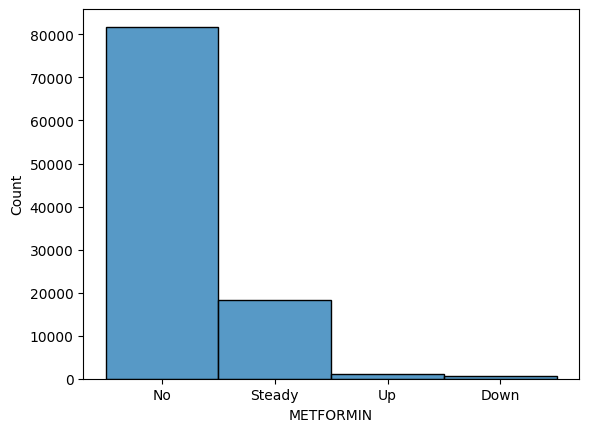

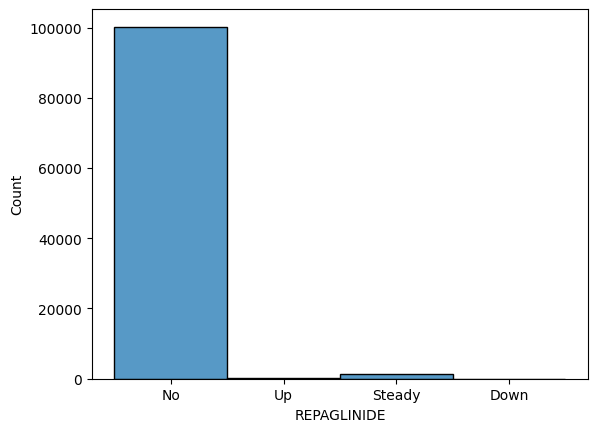

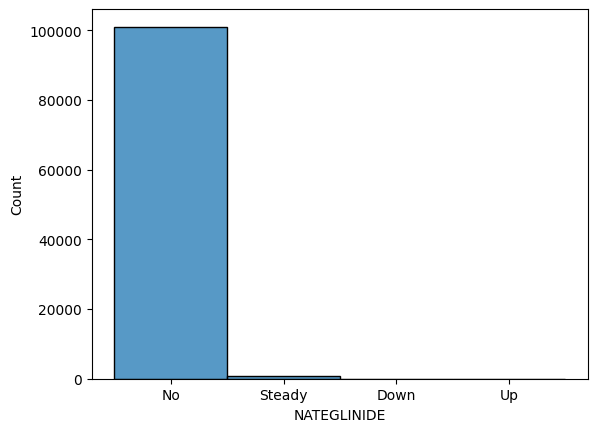

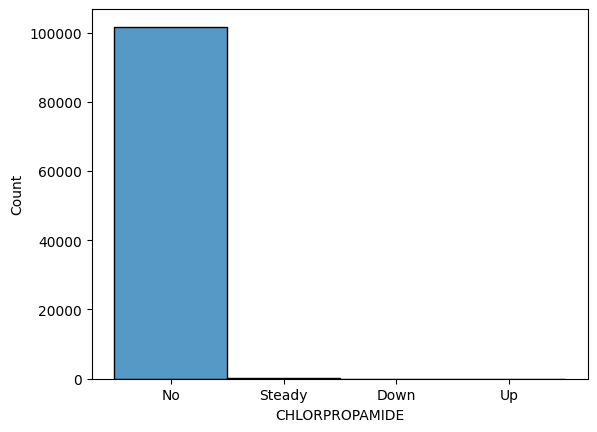

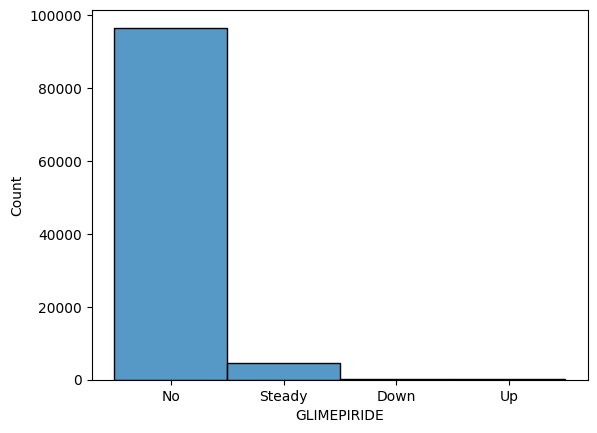

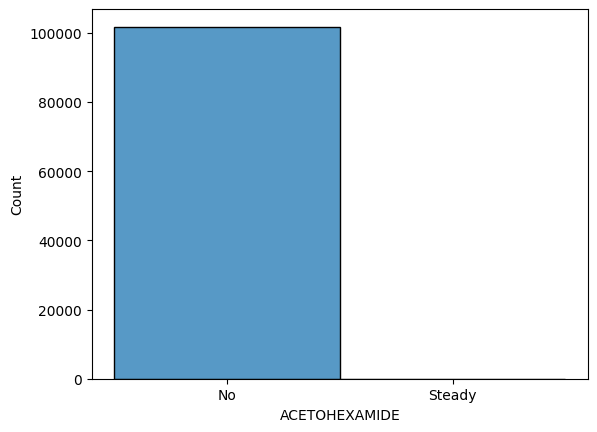

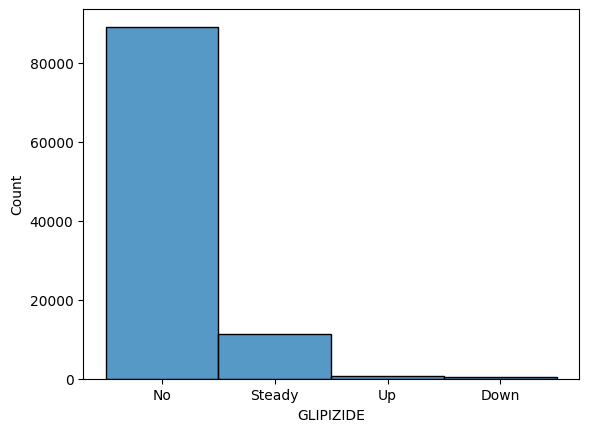

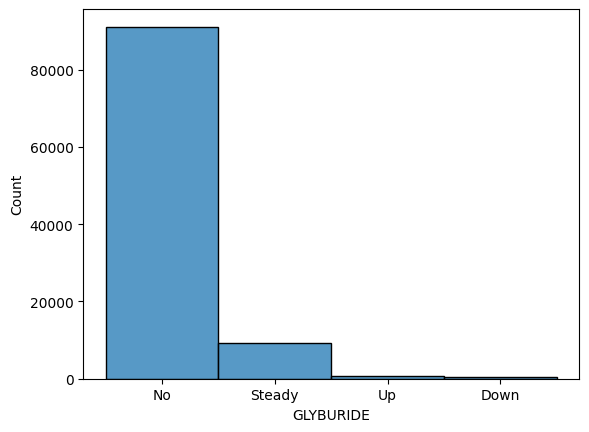

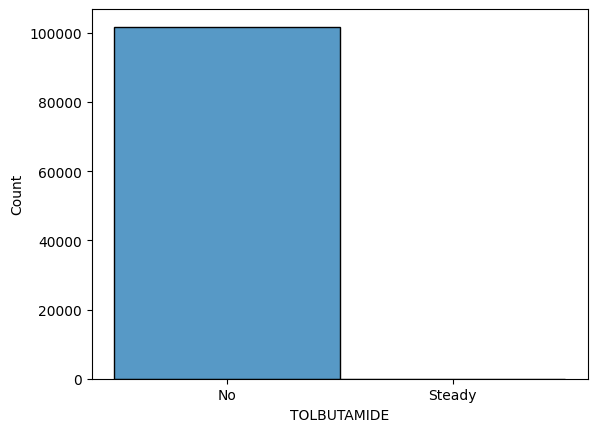

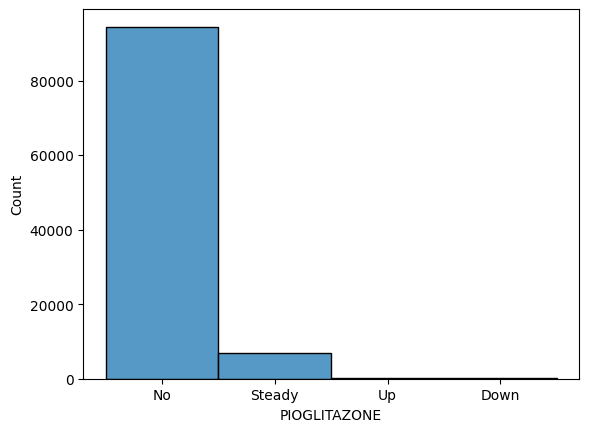

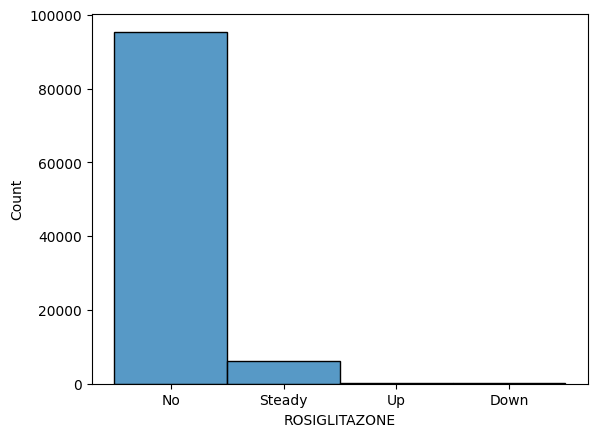

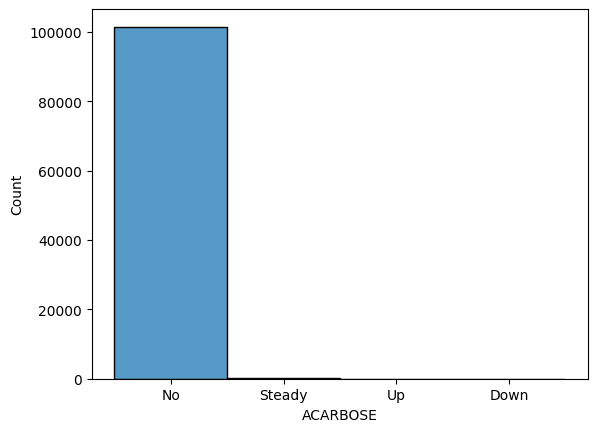

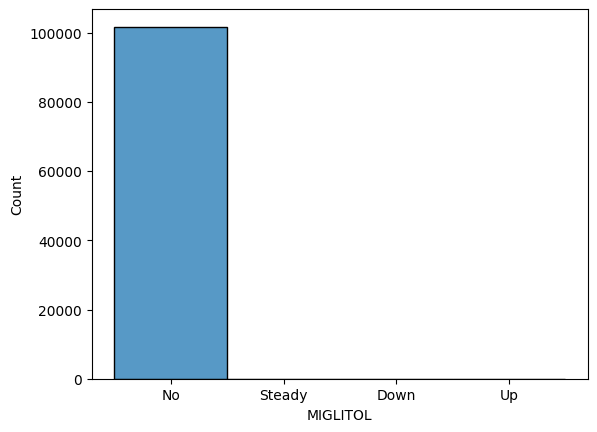

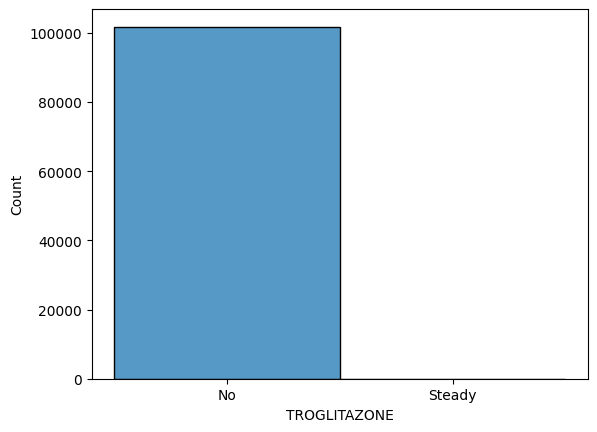

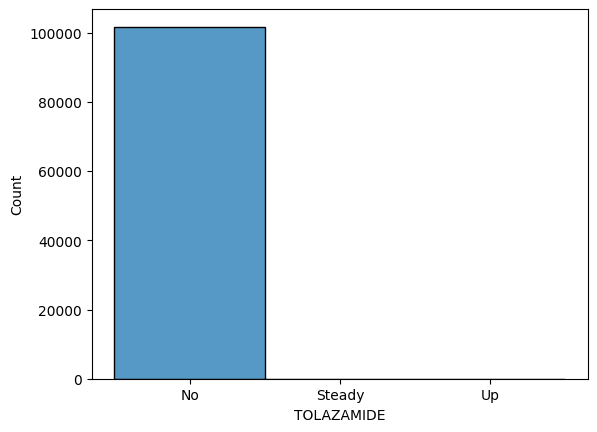

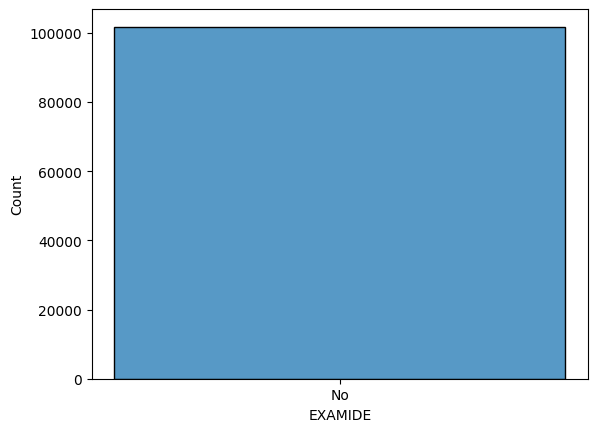

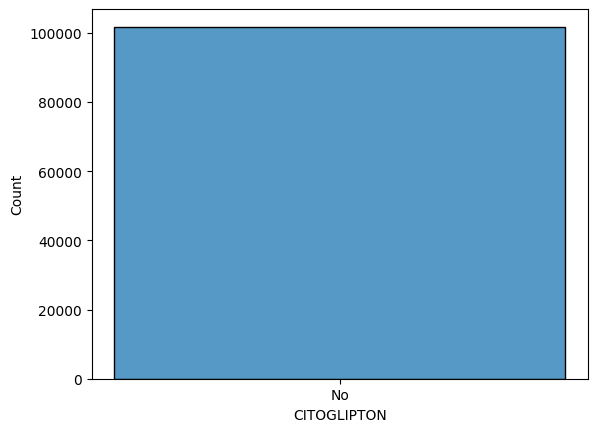

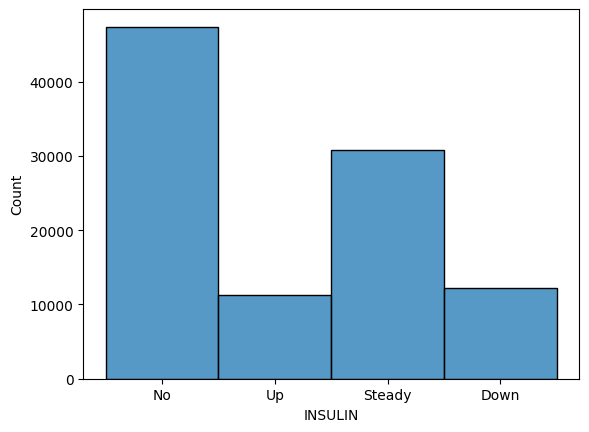

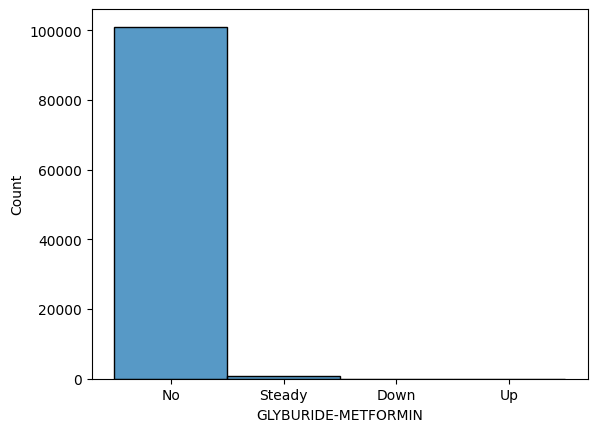

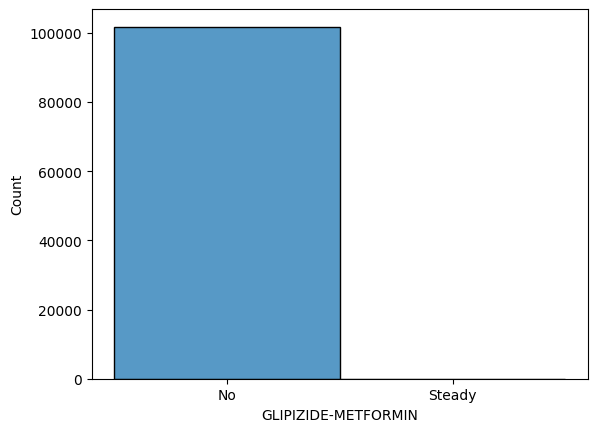

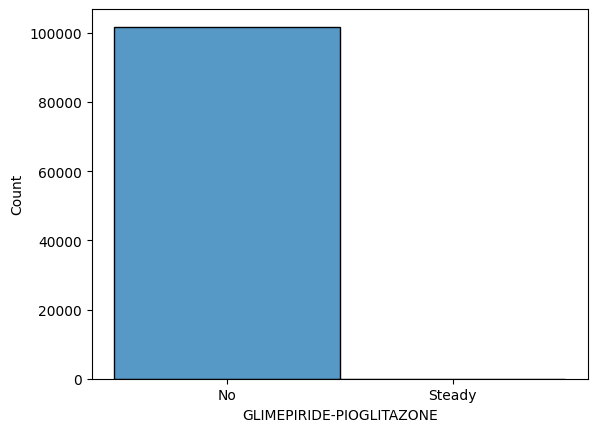

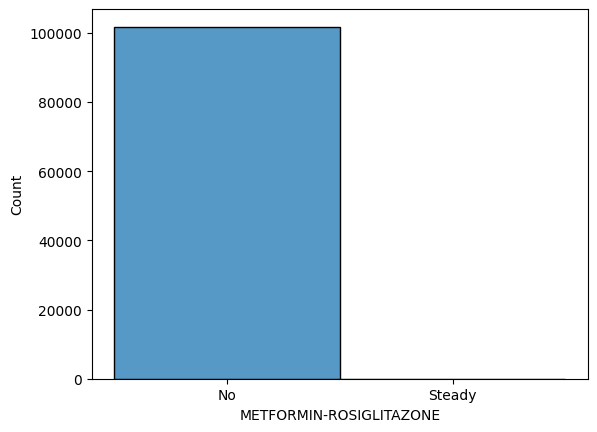

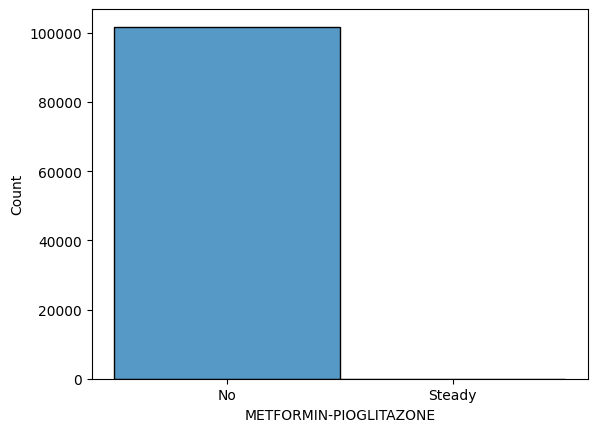

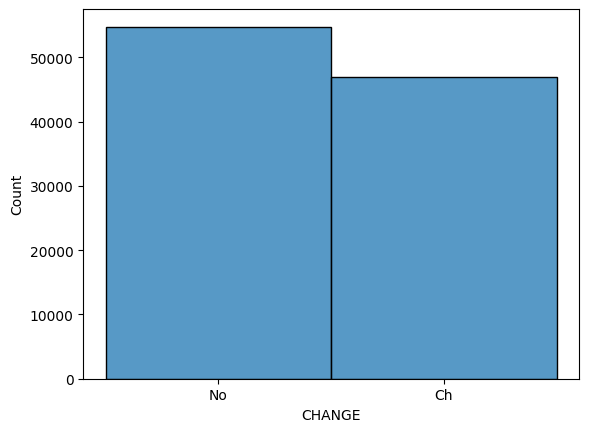

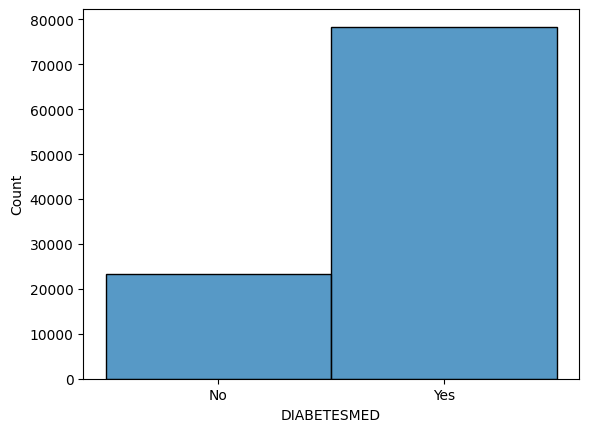

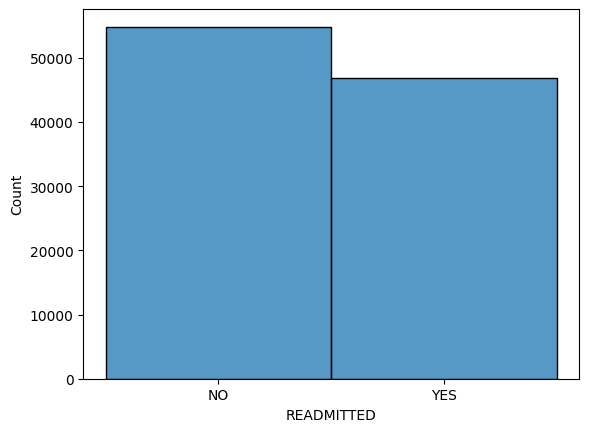

In [ ]:
for col in df.columns:

  sns.histplot(data=df, x=col)
  plt.show()

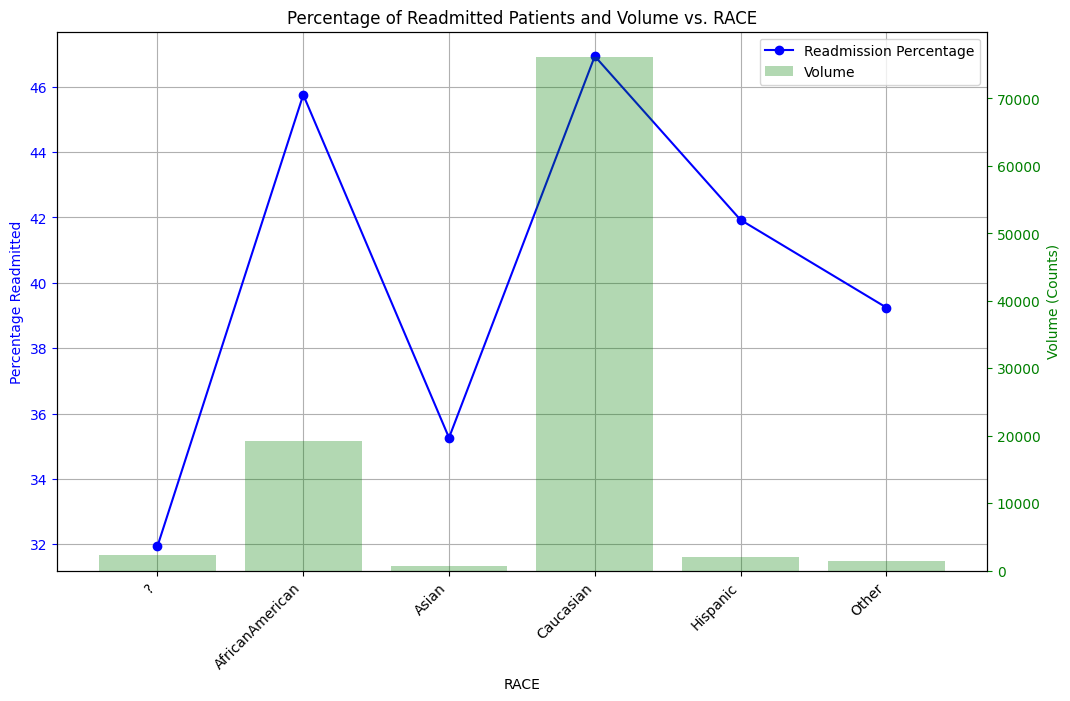

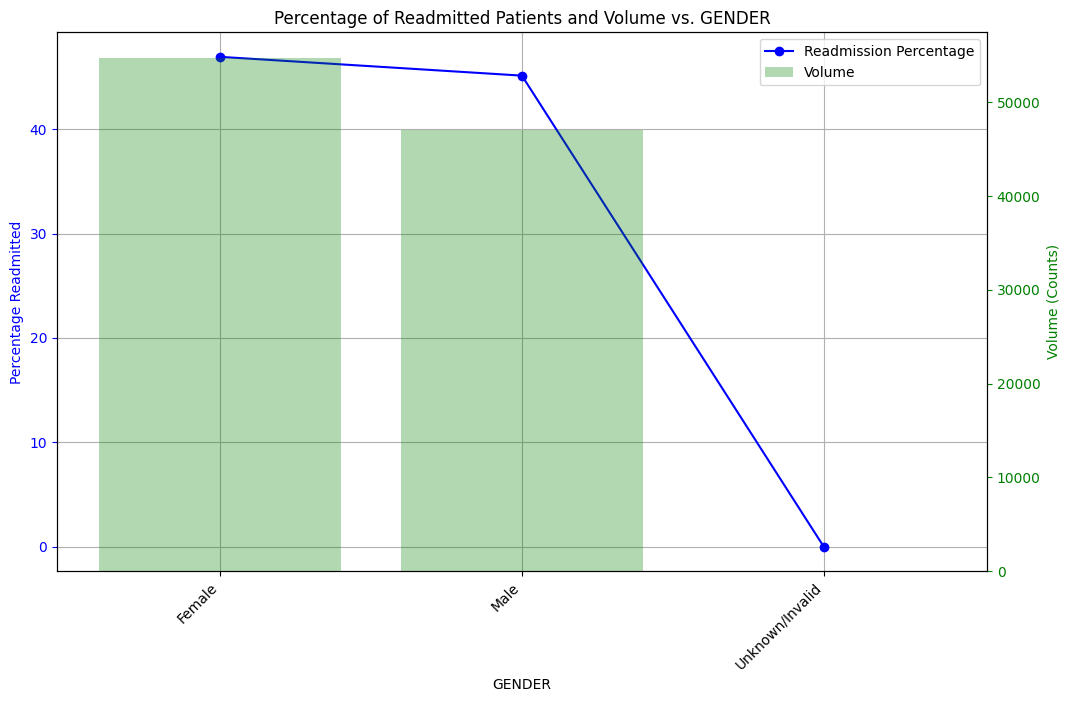

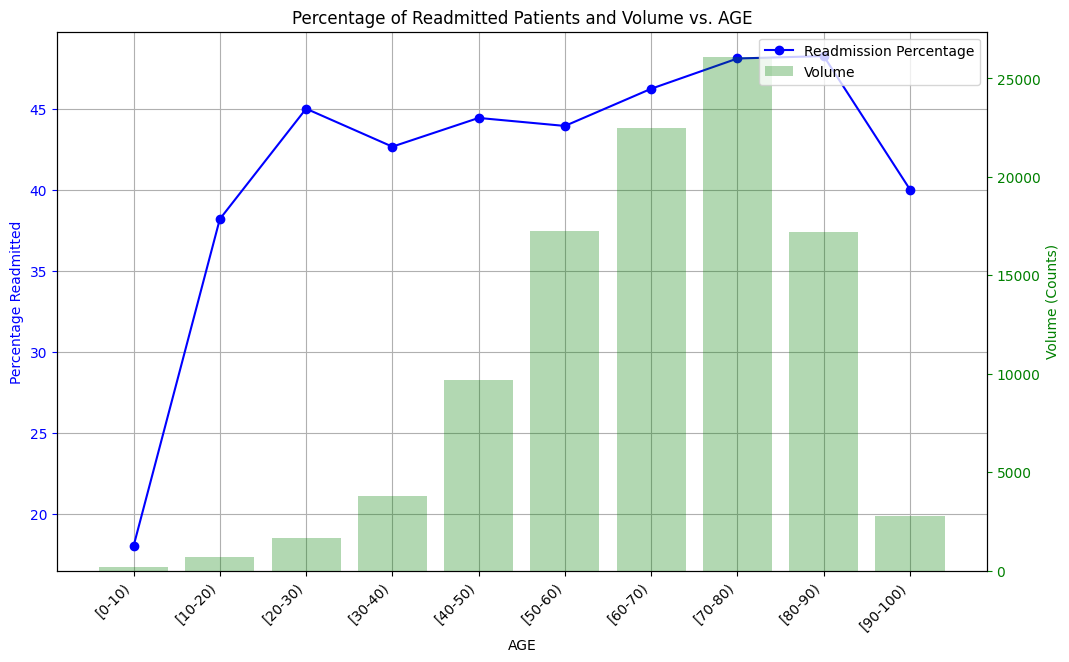

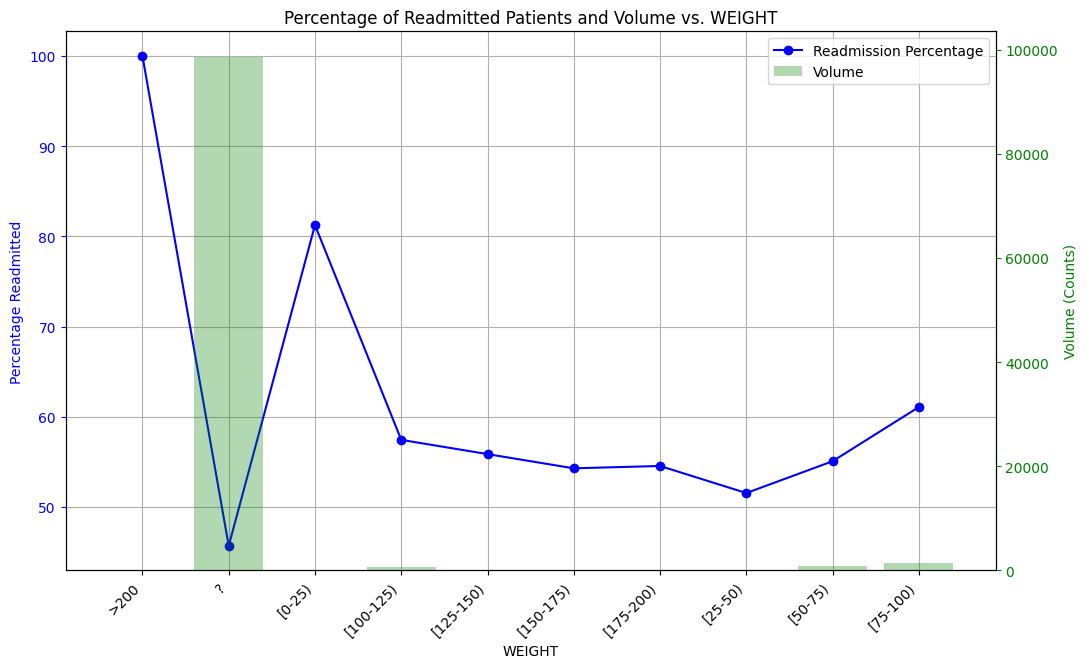

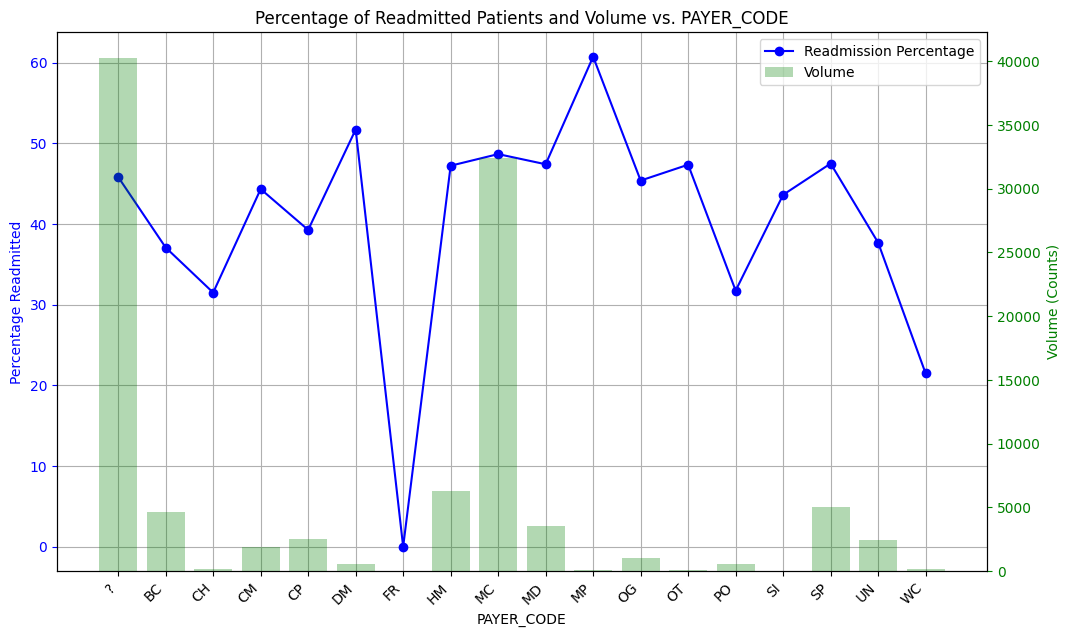

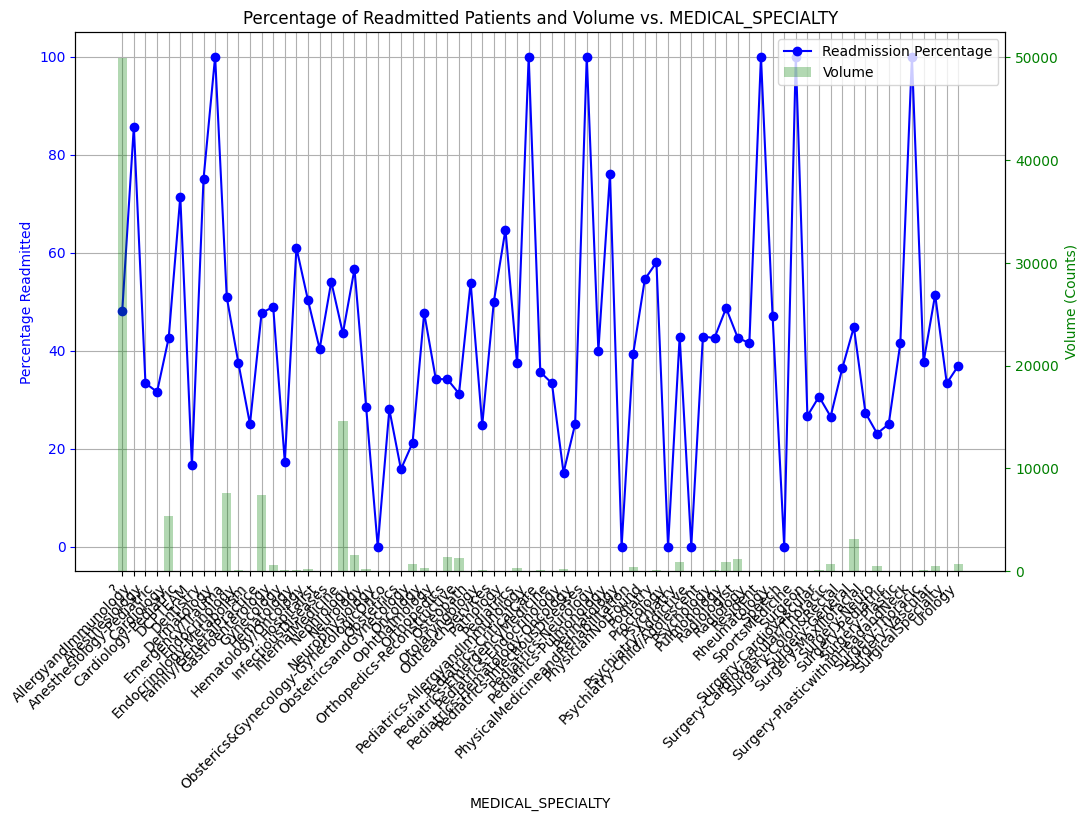

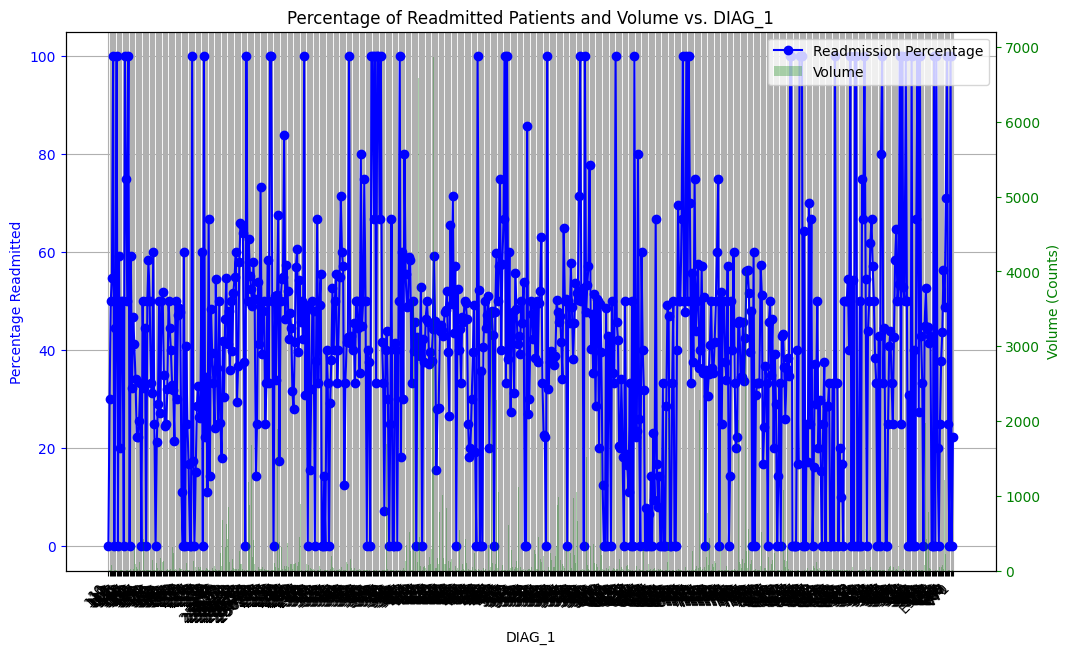

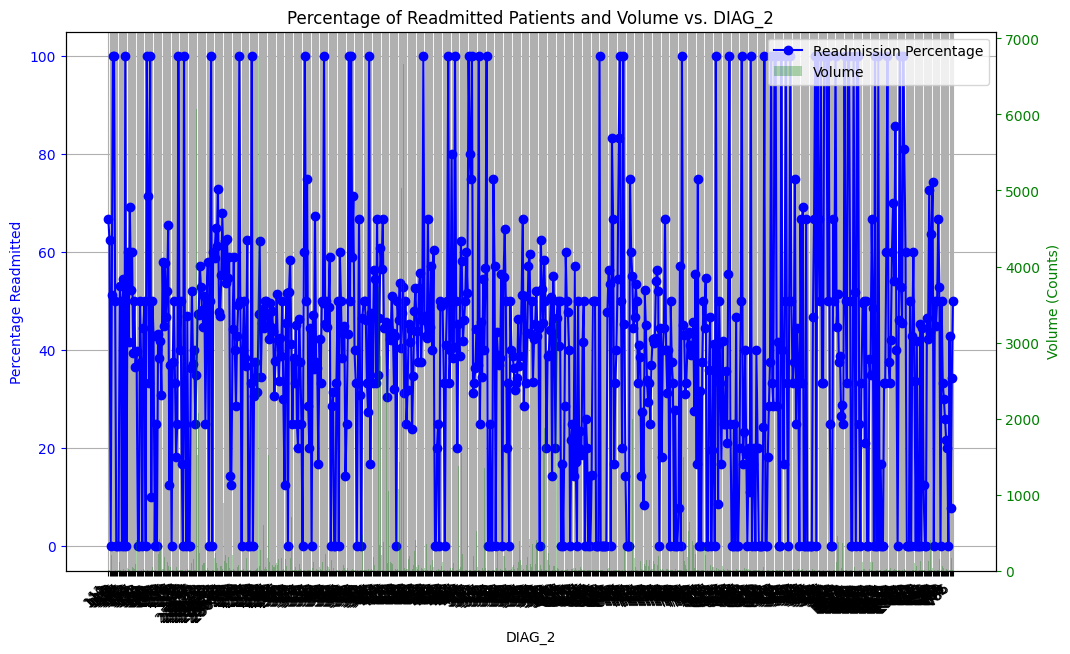

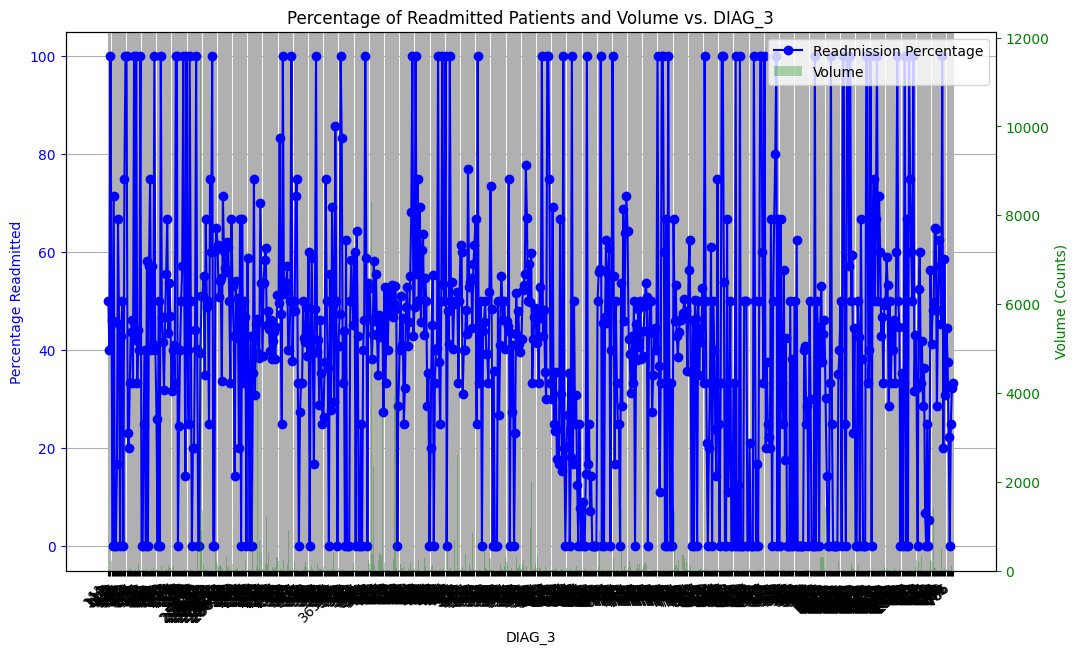

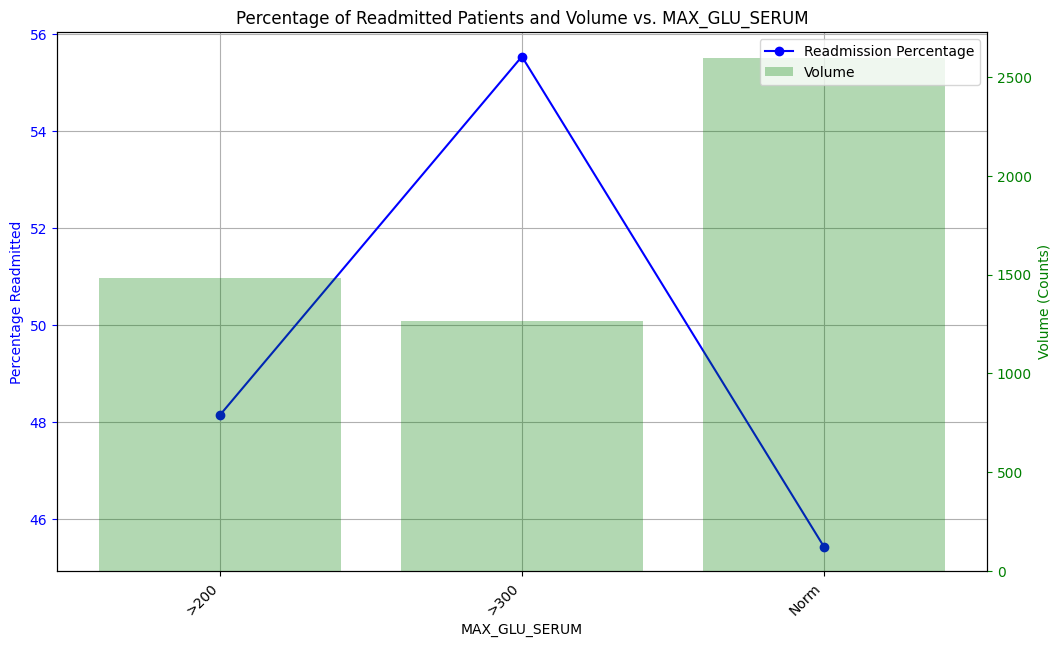

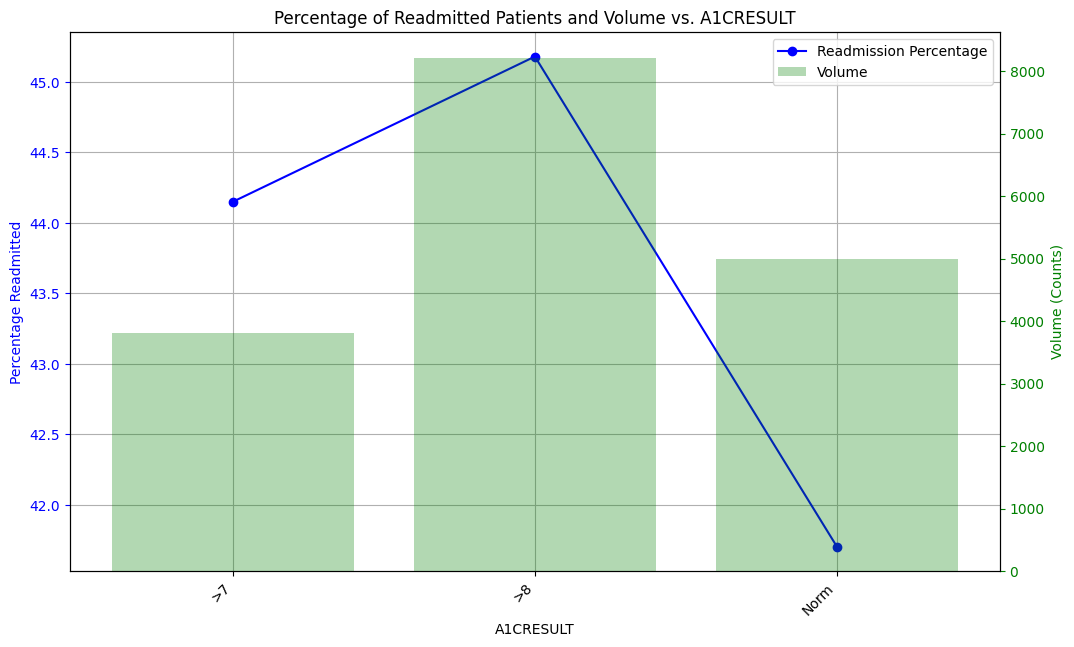

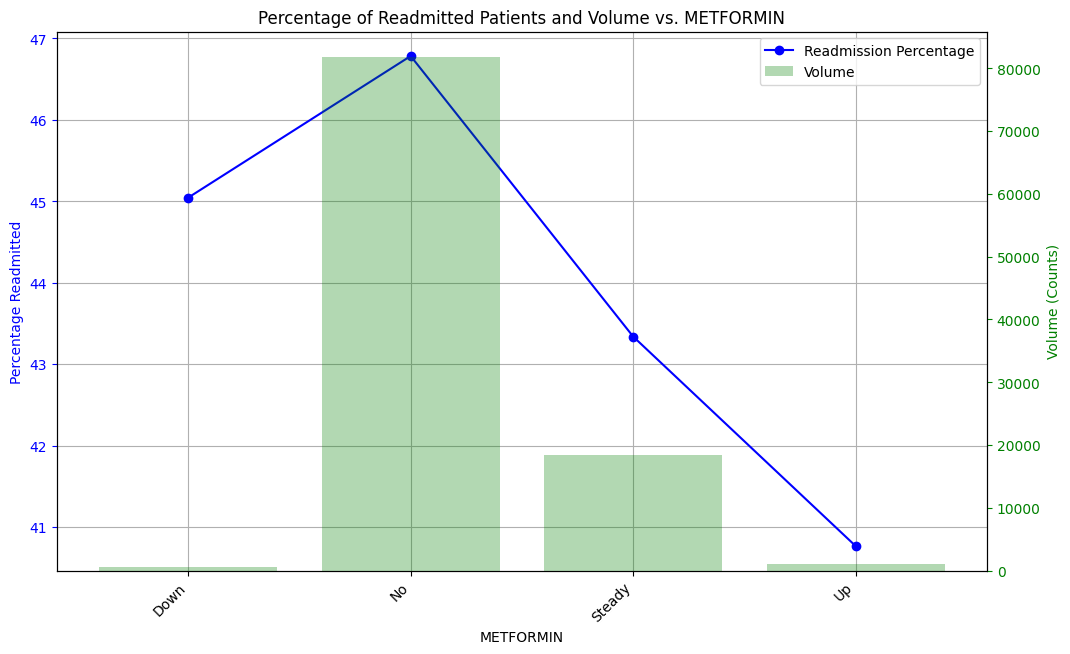

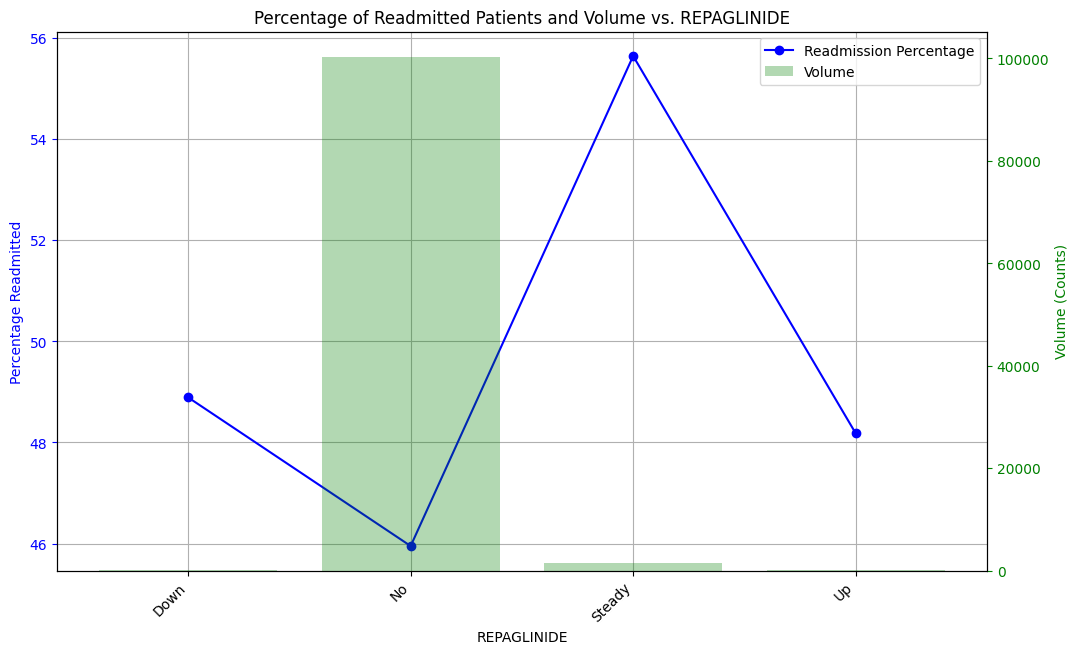

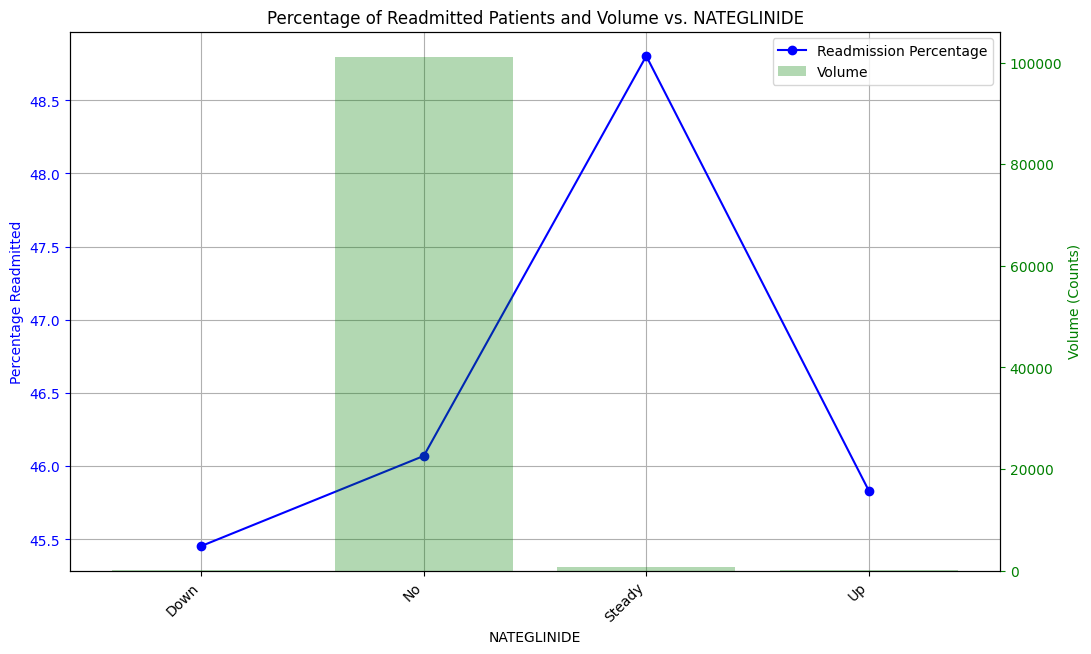

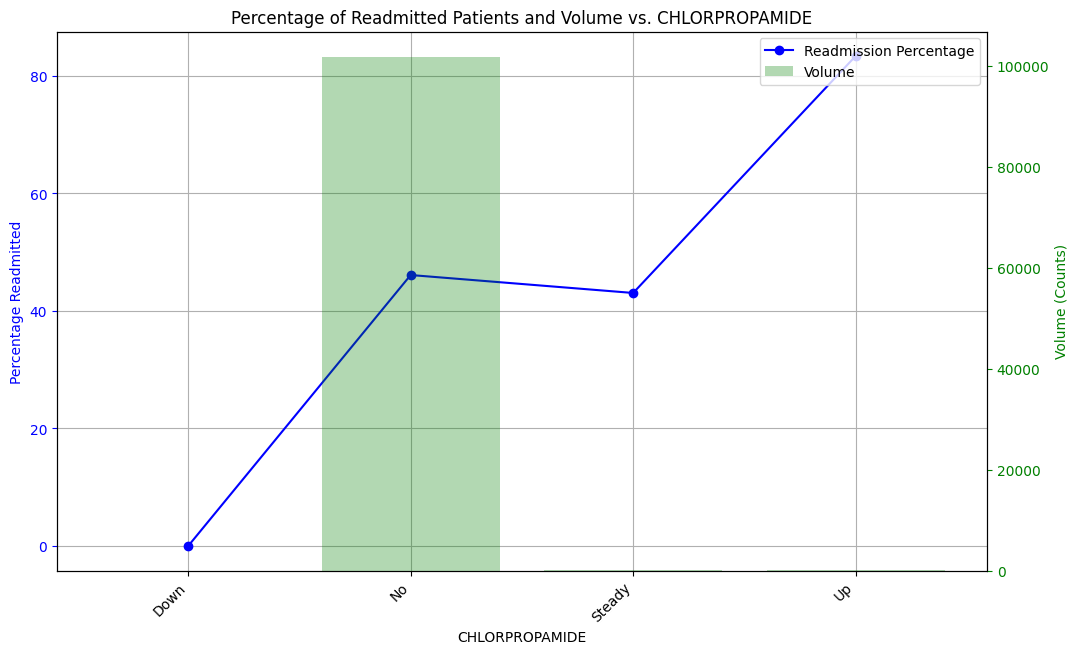

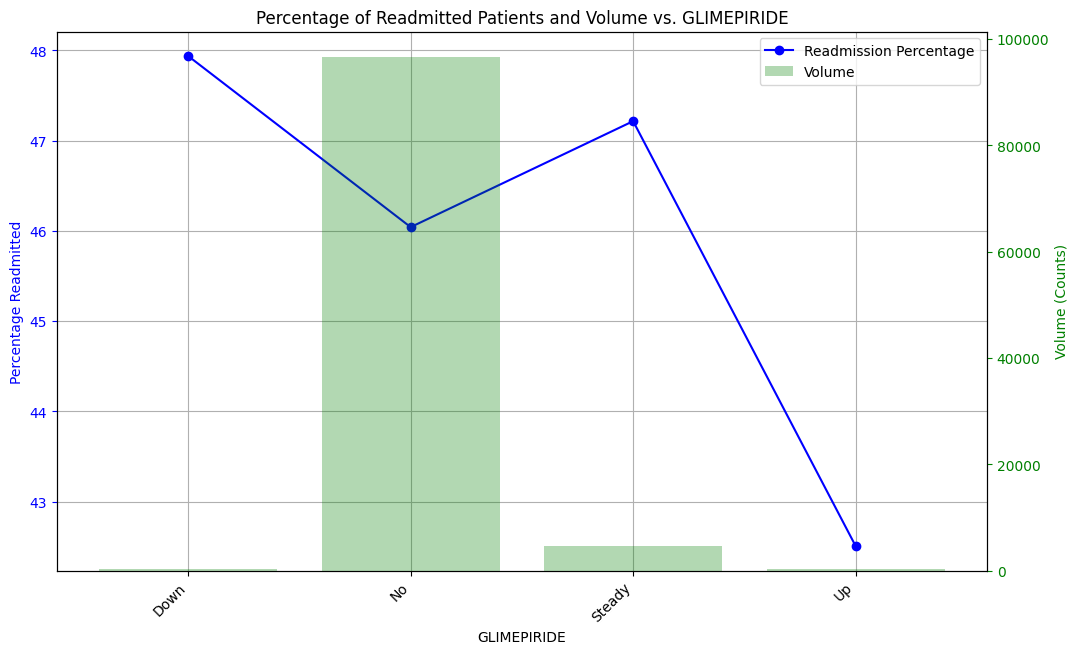

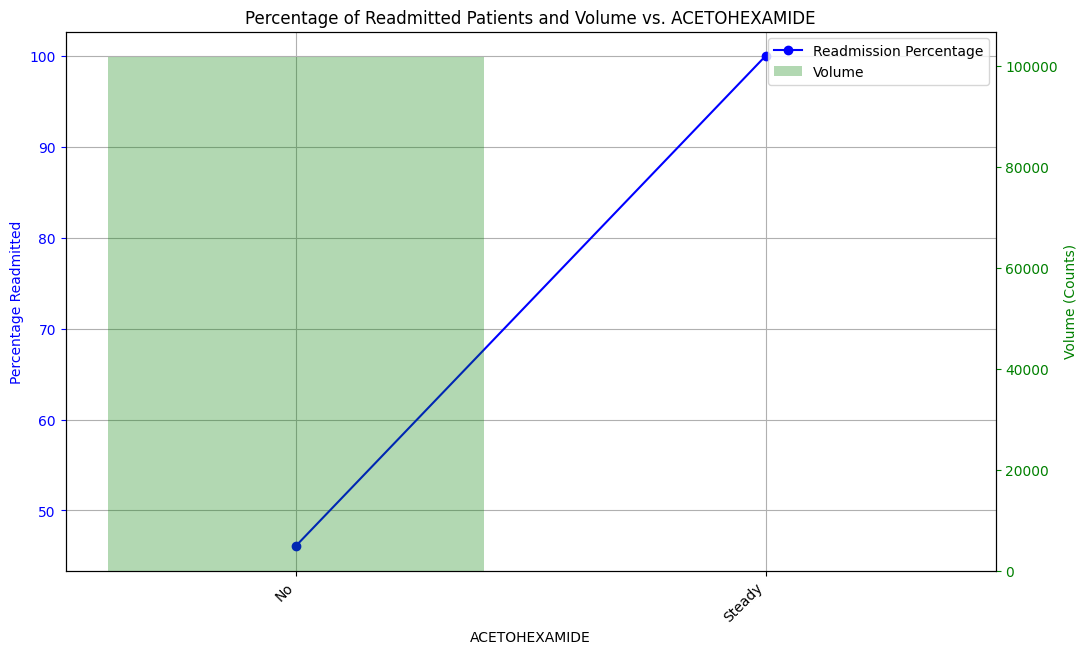

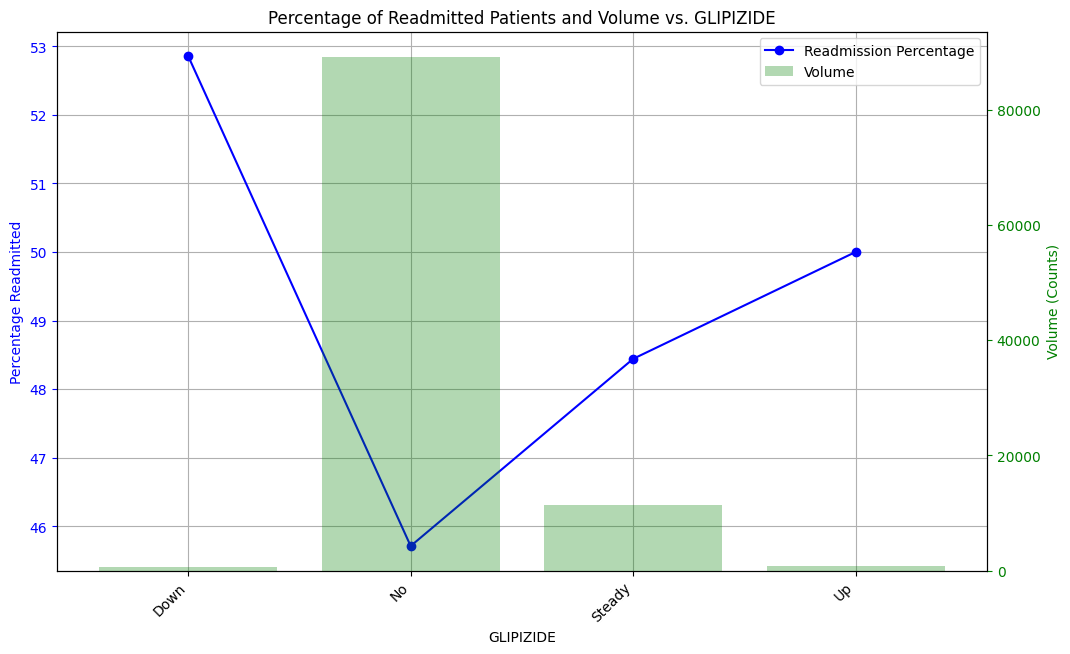

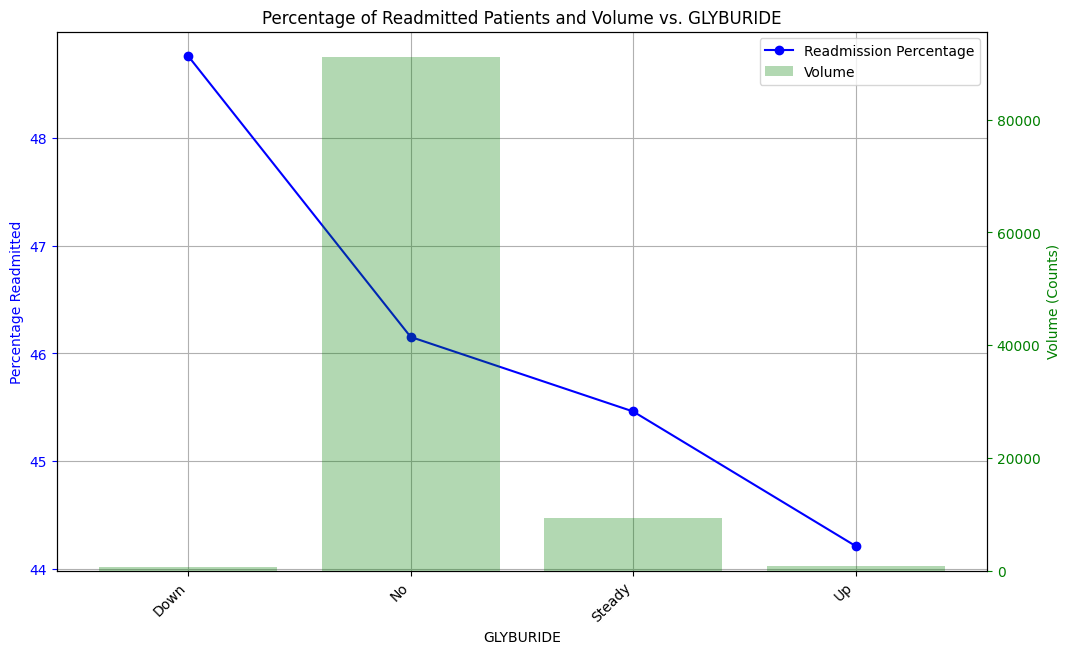

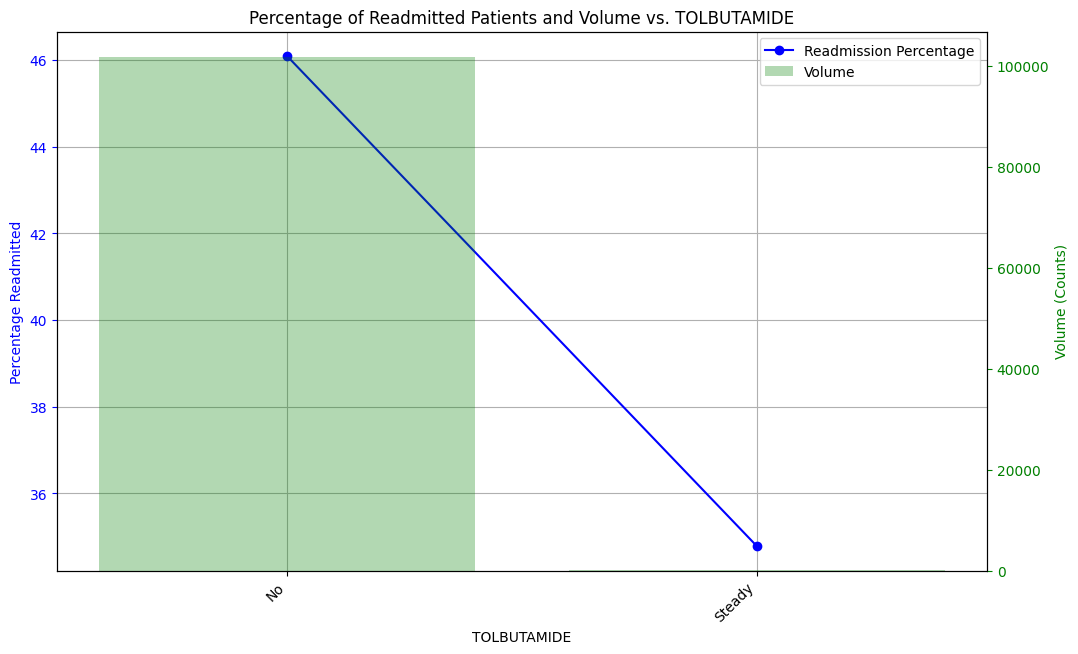

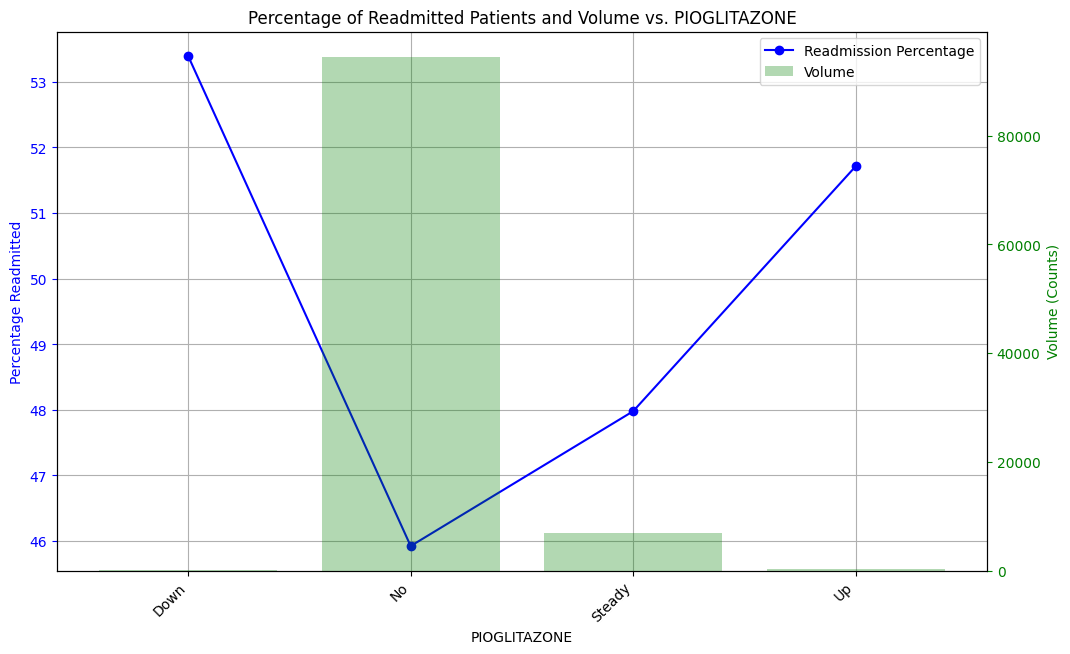

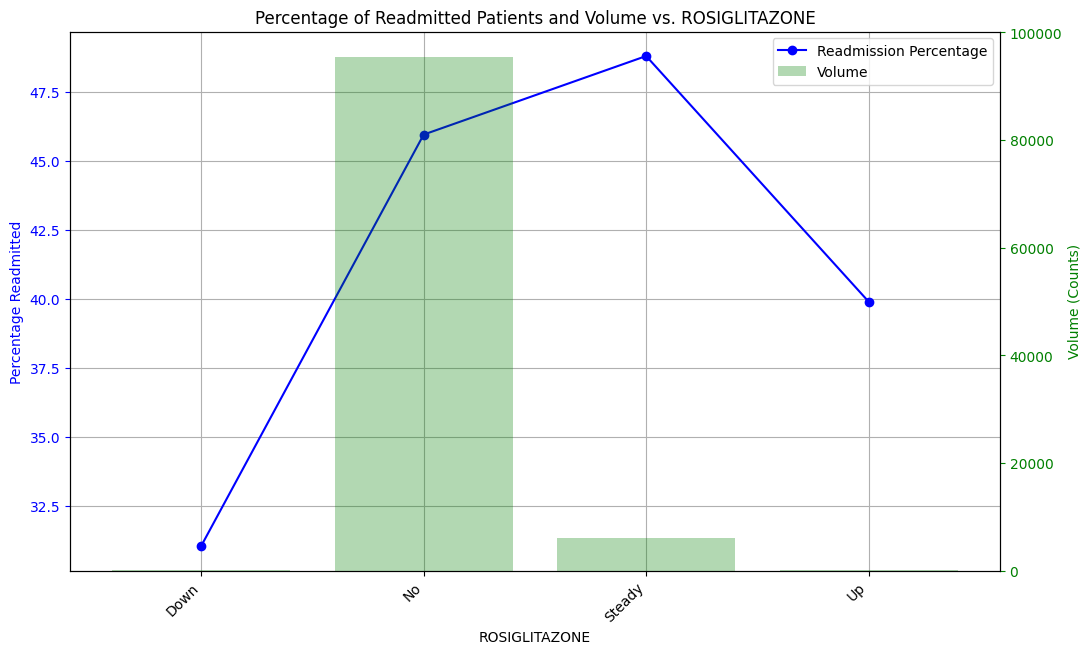

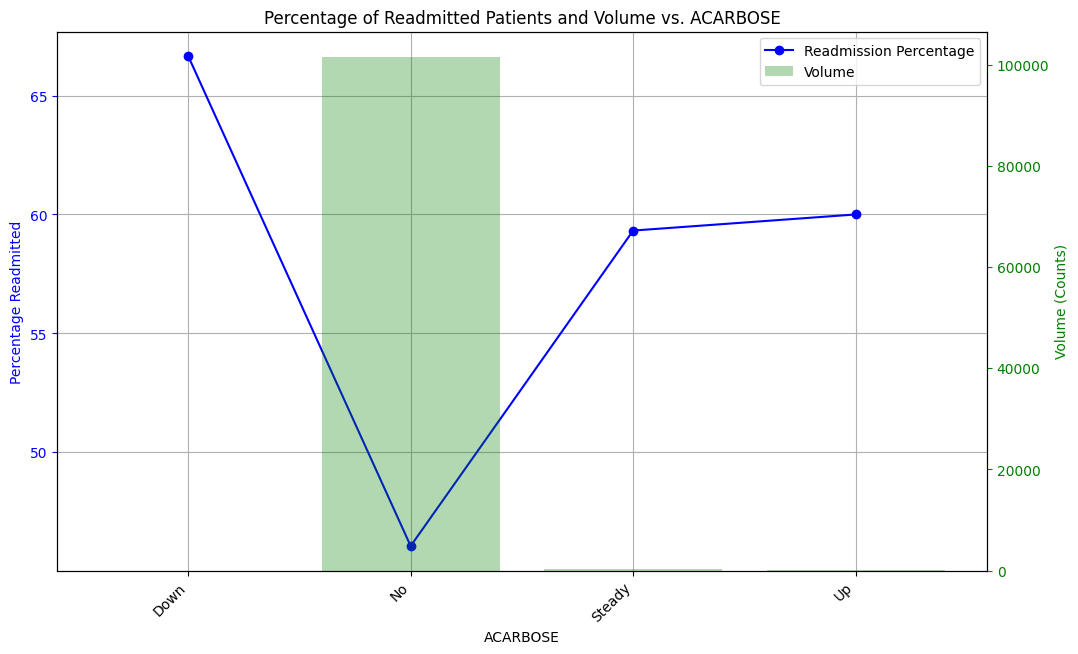

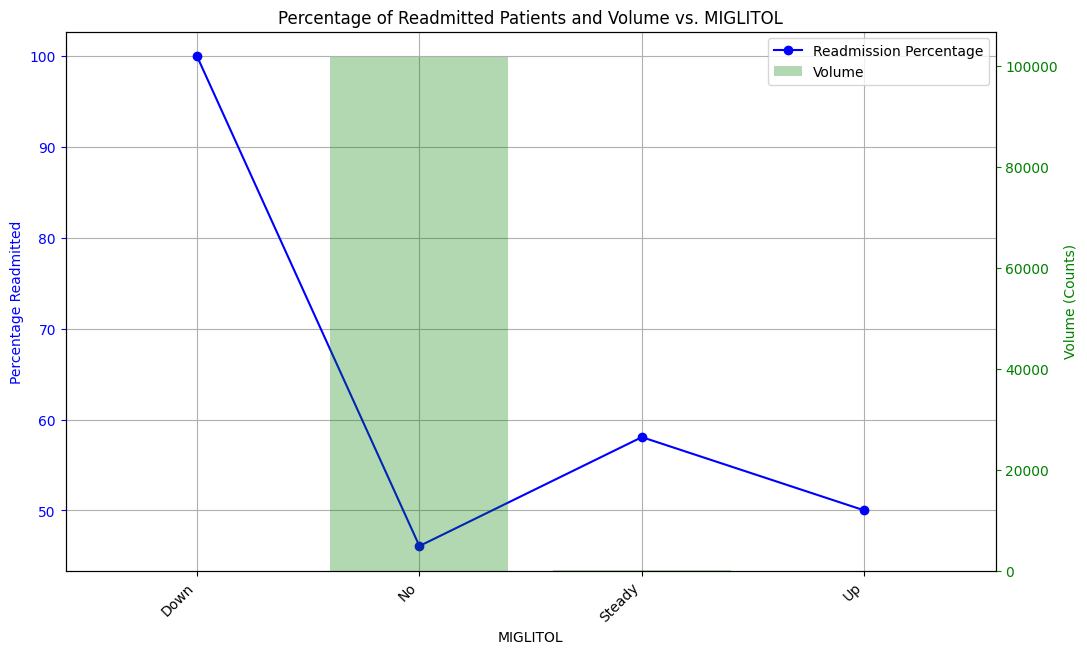

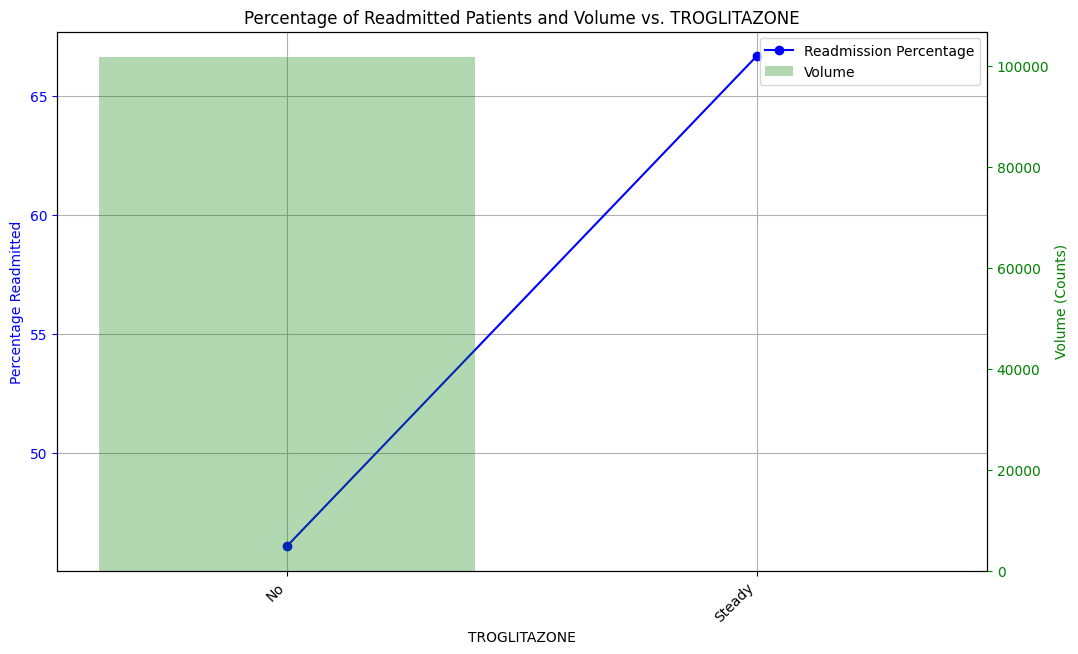

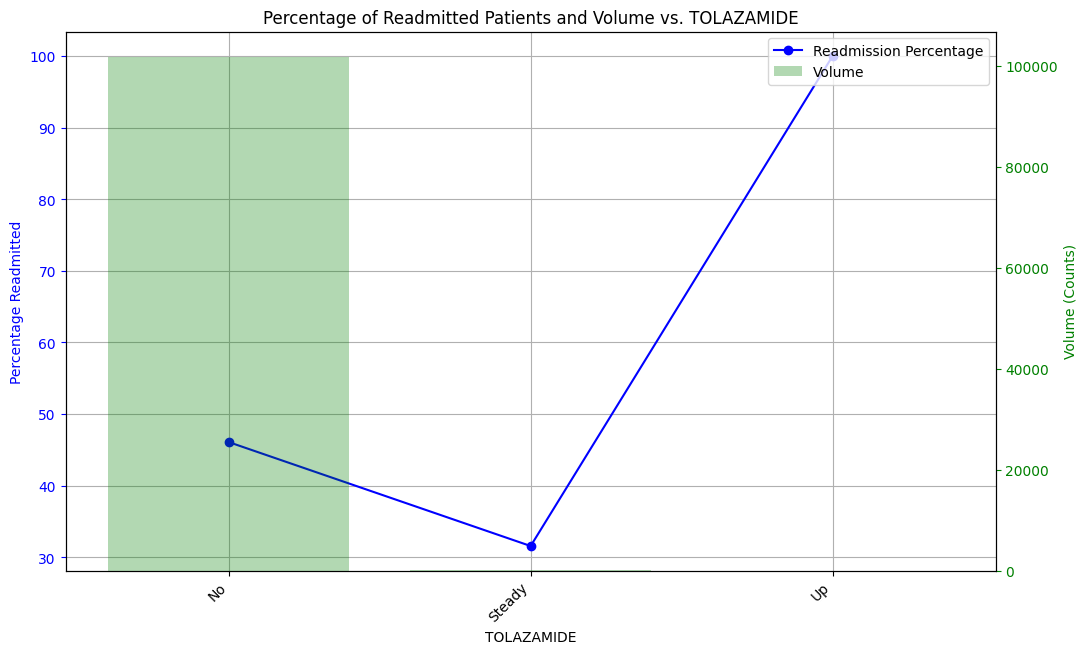

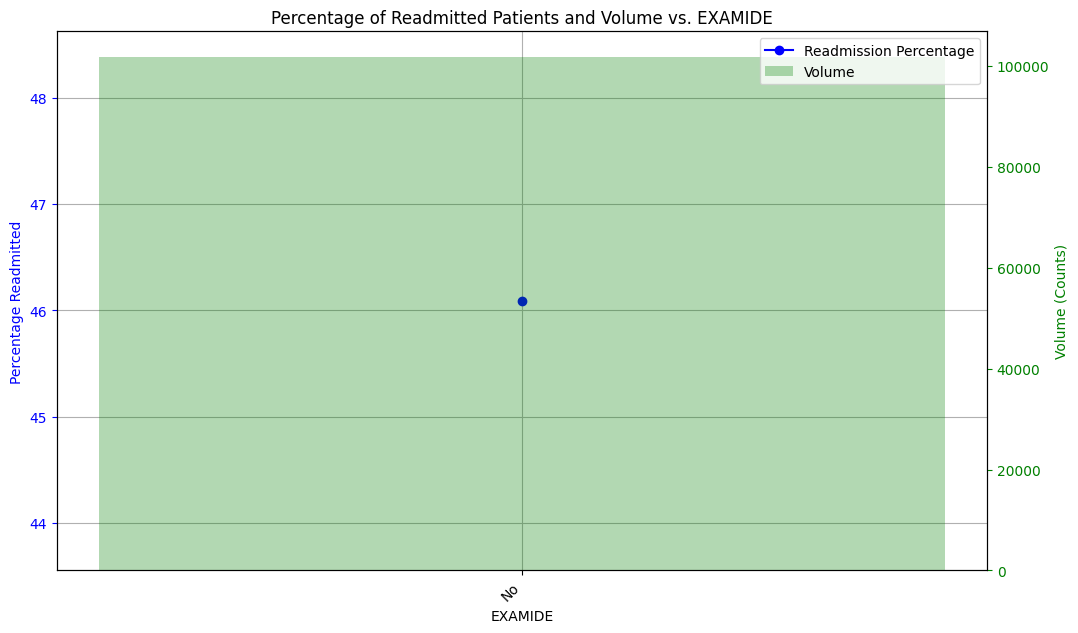

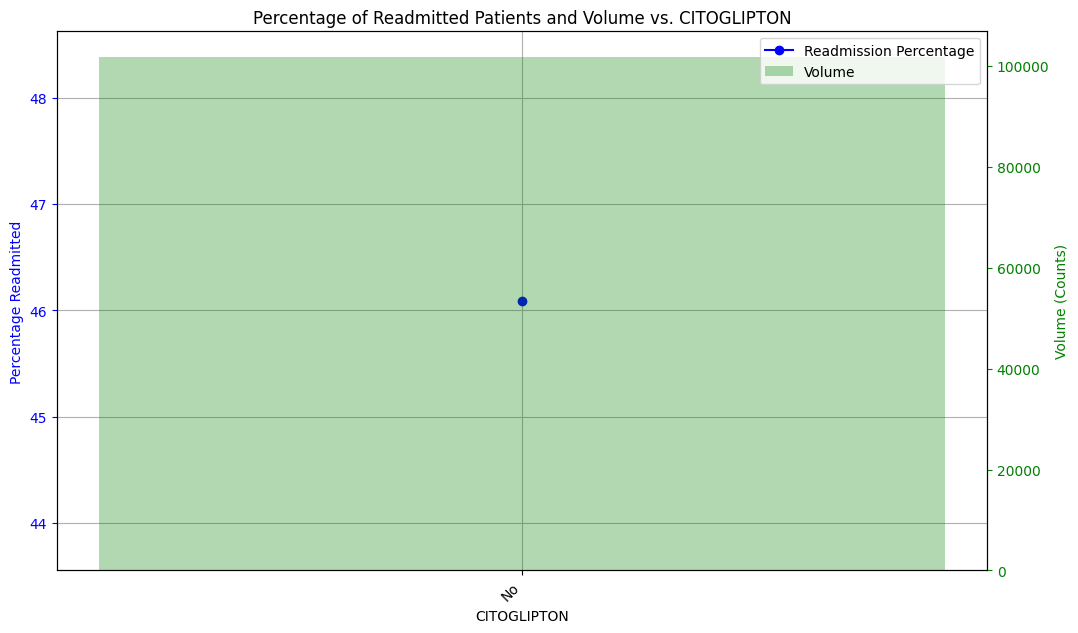

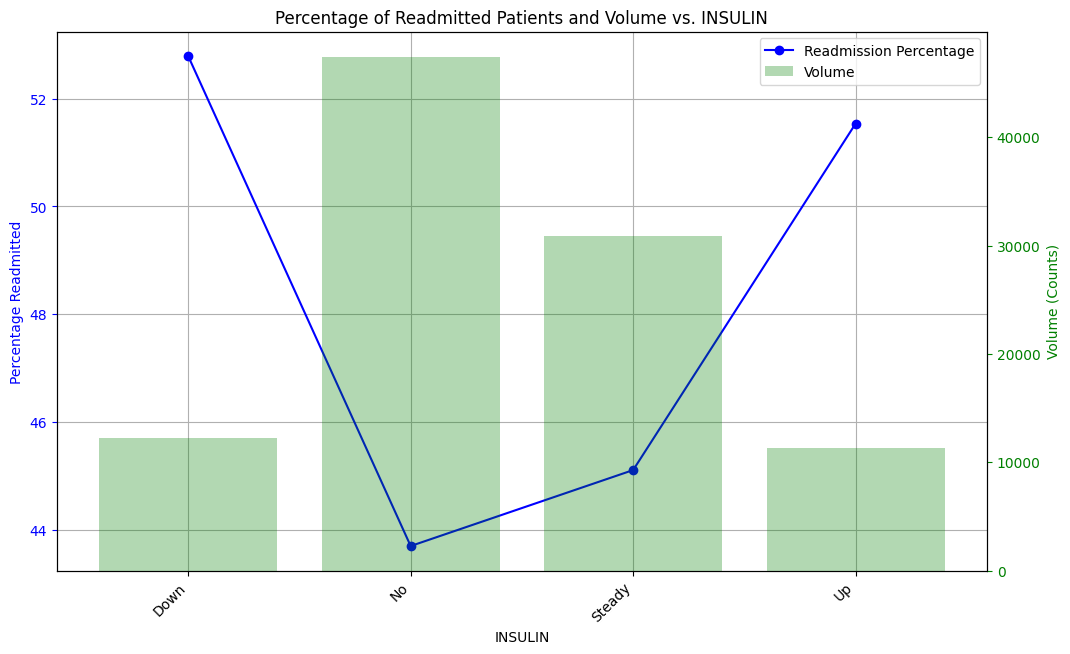

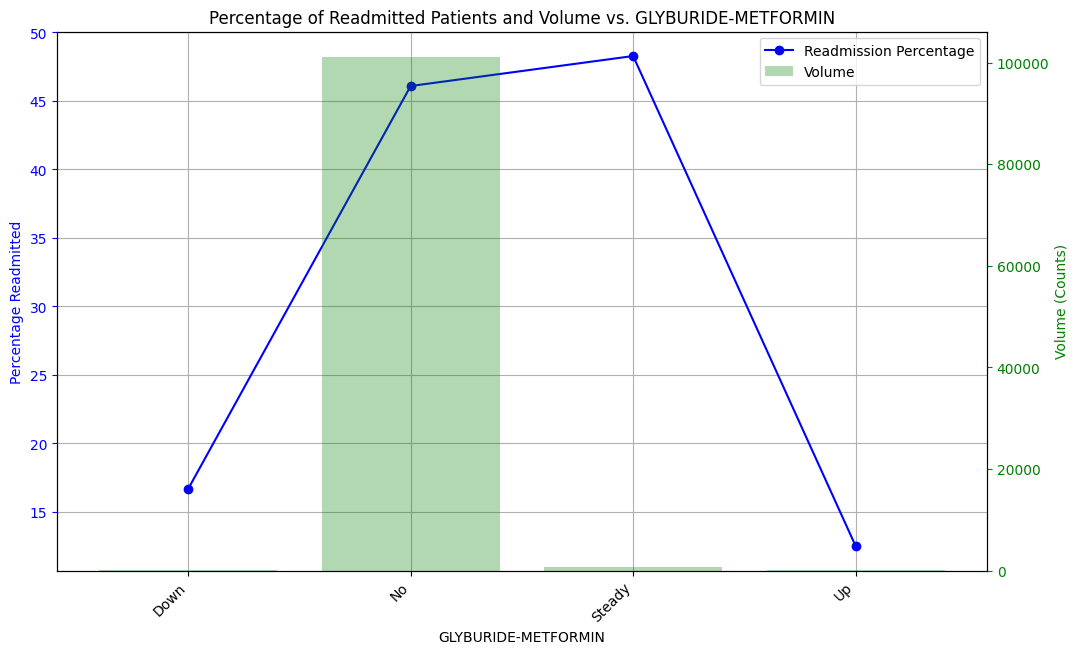

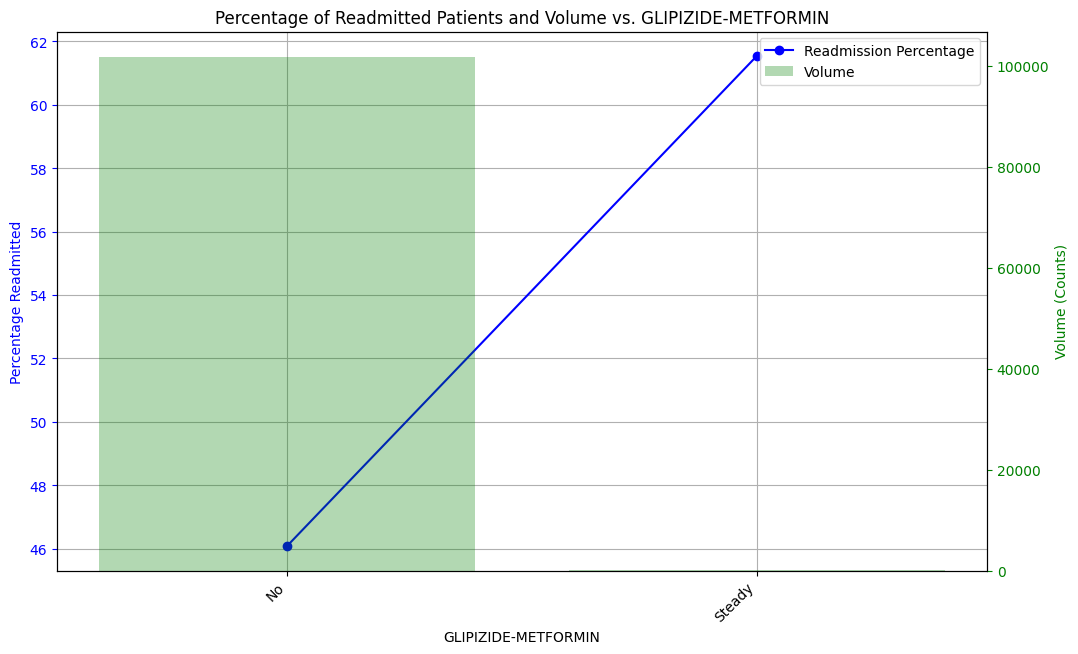

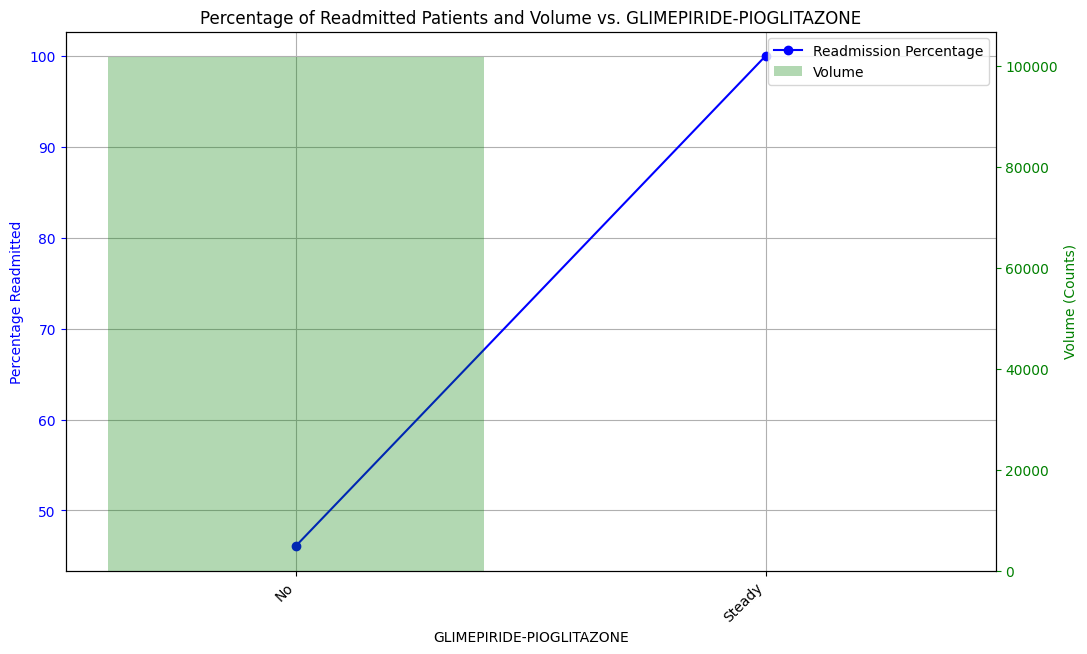

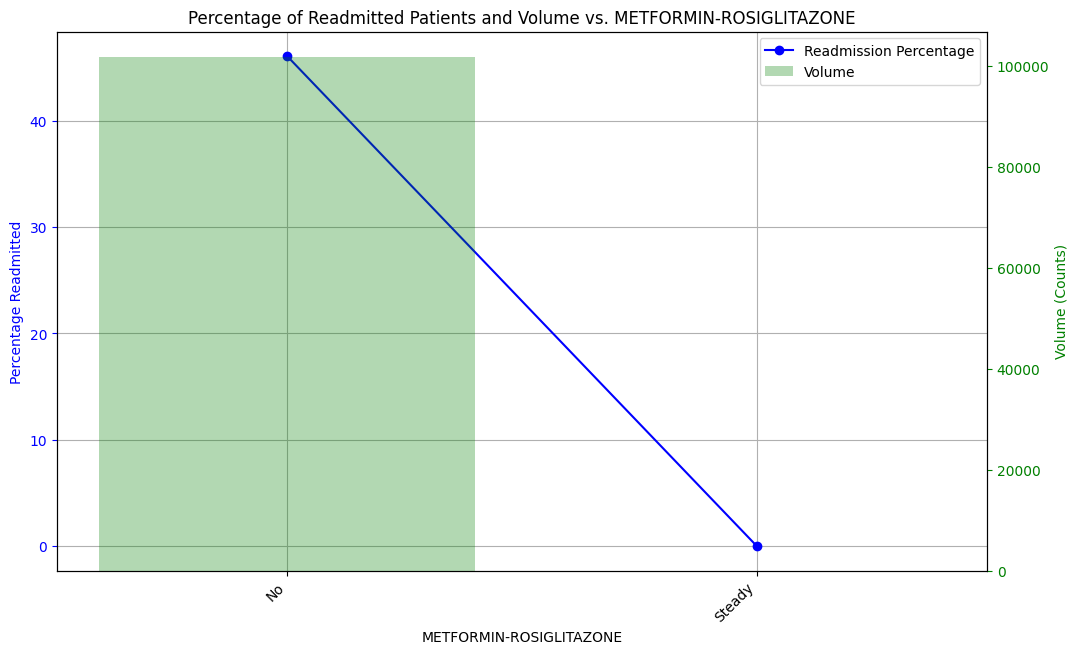

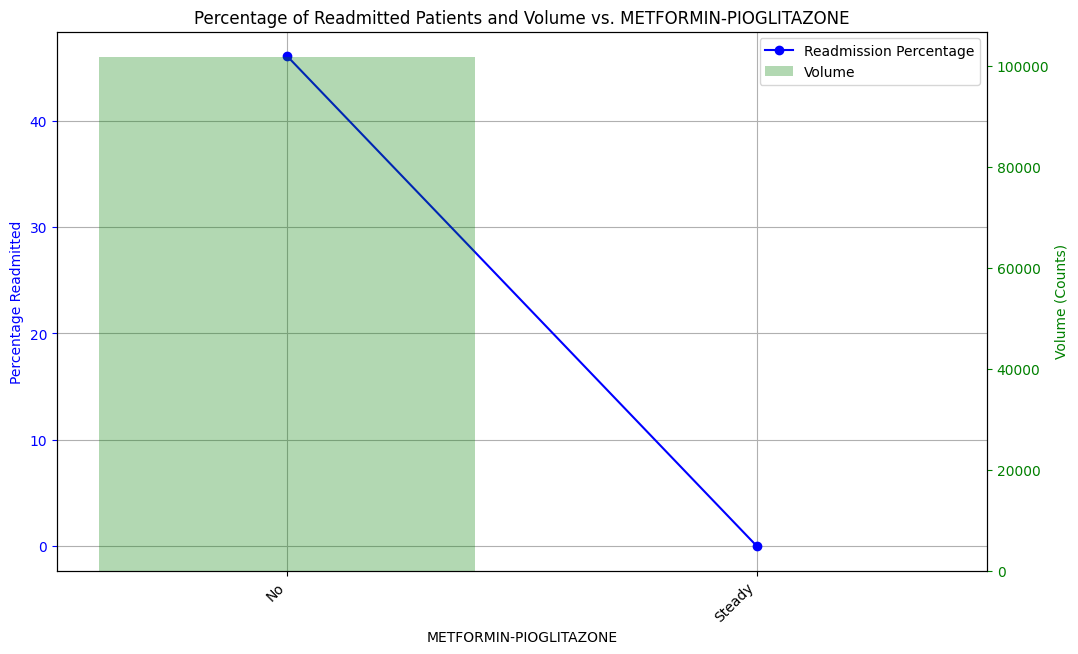

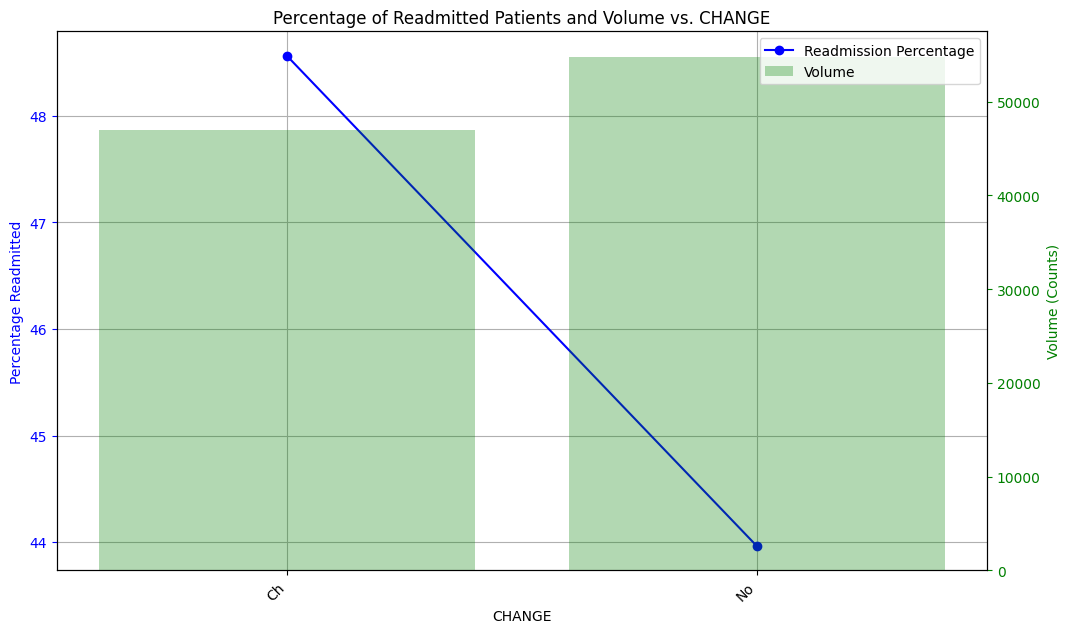

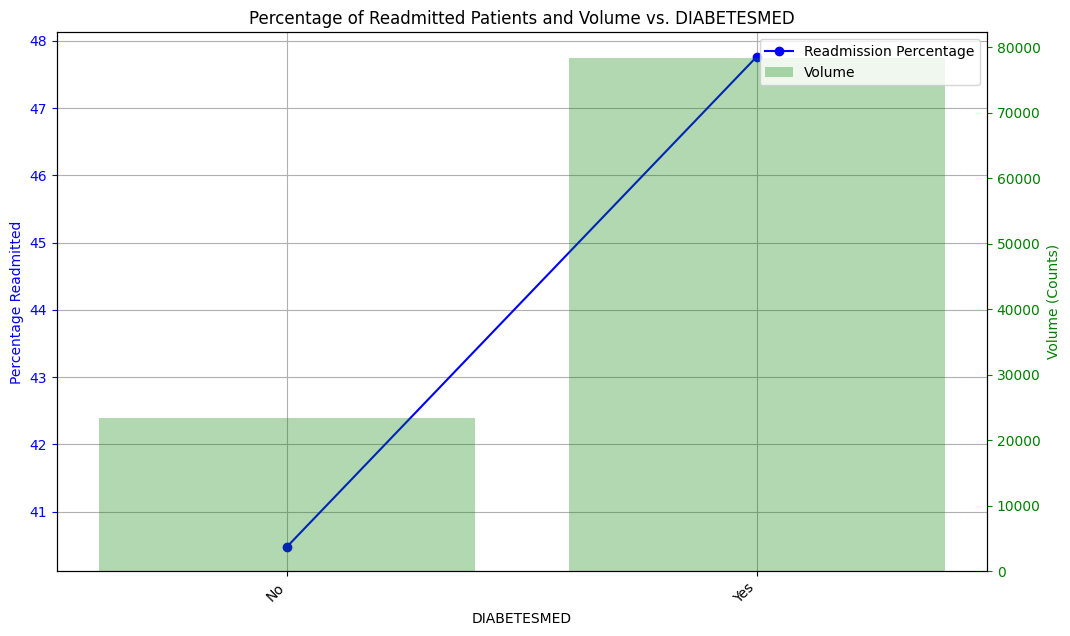

In [ ]:

def plot_readmission_percentage_with_volume_categorical(df, col, readmitted_col='READMITTED'):


    if col == readmitted_col or df[col].dtype == 'int64':
        return

    # Calculate readmission percentages
    readmission_counts = df.groupby(col)[readmitted_col].value_counts(normalize=True).unstack().fillna(0)
    if 'YES' in readmission_counts.columns:
        readmission_percentages = readmission_counts['YES'] * 100
    else:
        readmission_percentages = pd.Series(0, index=readmission_counts.index)

    volume_counts = df[col].value_counts().sort_index()

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(readmission_percentages.index.astype(str), readmission_percentages.values, marker='o', color='b', label='Readmission Percentage')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Percentage Readmitted', color='b')
    ax1.tick_params('y', colors='b')
    plt.xticks(rotation=45, ha='right')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.bar(volume_counts.index.astype(str), volume_counts.values, alpha=0.3, color='g', label='Volume')
    ax2.set_ylabel('Volume (Counts)', color='g')
    ax2.tick_params('y', colors='g')

    # Add legends
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title(f'Percentage of Readmitted Patients and Volume vs. {col}')
    plt.show()

for col in df.columns:
    plot_readmission_percentage_with_volume_categorical(df, col)

In [ ]:
print(df['READMITTED'].unique())


['NO' 'YES']


In [ ]:
df = df.replace("?", np.nan)

# Count missing values per column
missing_counts = df.isna().sum()

# Calculate the proportion of missing values per column
missing_proportions = missing_counts / len(df)

print("Missing Value Counts:\n", missing_counts)
print("\nMissing Value Proportions:\n", missing_proportions)


Missing Value Counts:
 ENCOUNTER_ID                    0
PATIENT_NBR                     0
RACE                         2273
GENDER                          0
AGE                             0
WEIGHT                      98569
ADMISSION_TYPE_ID               0
DISCHARGE_DISPOSITION_ID        0
ADMISSION_SOURCE_ID             0
TIME_IN_HOSPITAL                0
PAYER_CODE                  40256
MEDICAL_SPECIALTY           49949
NUM_LAB_PROCEDURES              0
NUM_PROCEDURES                  0
NUM_MEDICATIONS                 0
NUMBER_OUTPATIENT               0
NUMBER_EMERGENCY                0
NUMBER_INPATIENT                0
DIAG_1                         21
DIAG_2                        358
DIAG_3                       1423
NUMBER_DIAGNOSES                0
MAX_GLU_SERUM               96420
A1CRESULT                   84748
METFORMIN                       0
REPAGLINIDE                     0
NATEGLINIDE                     0
CHLORPROPAMIDE                  0
GLIMEPIRIDE              

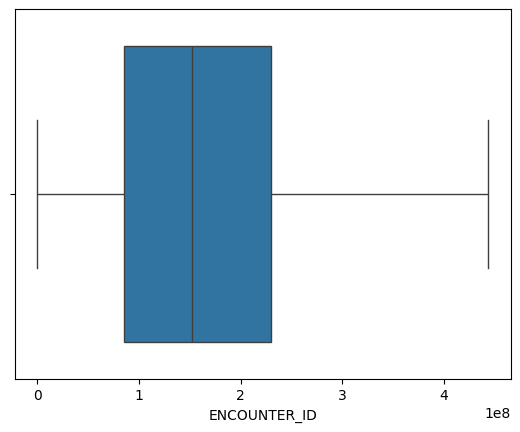

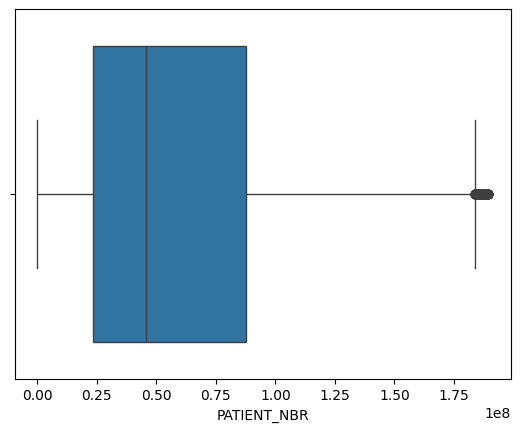

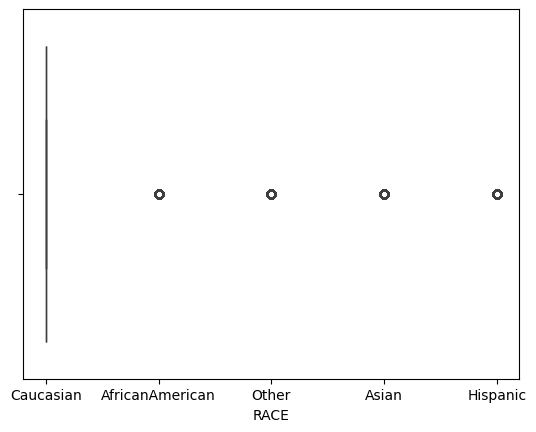

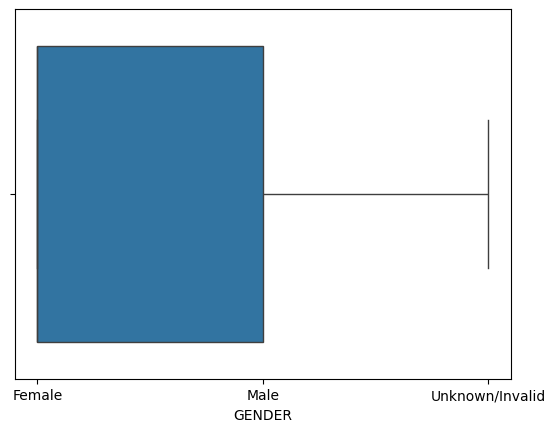

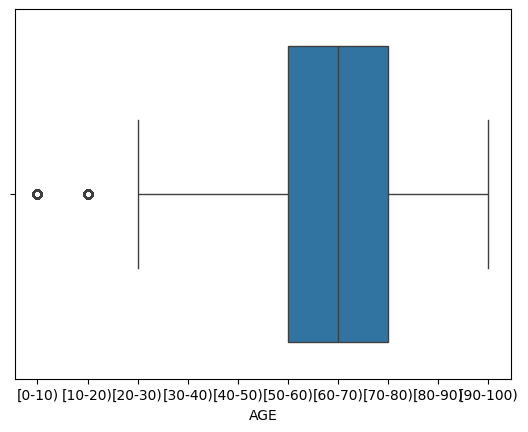

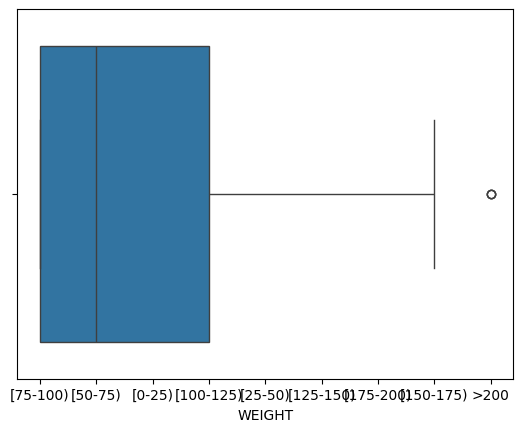

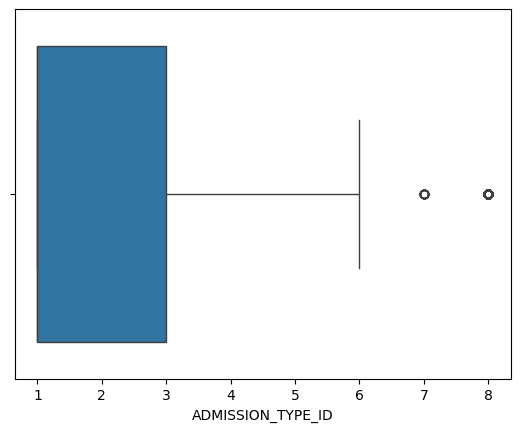

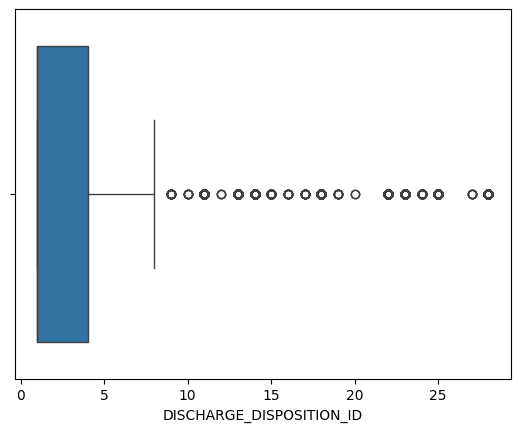

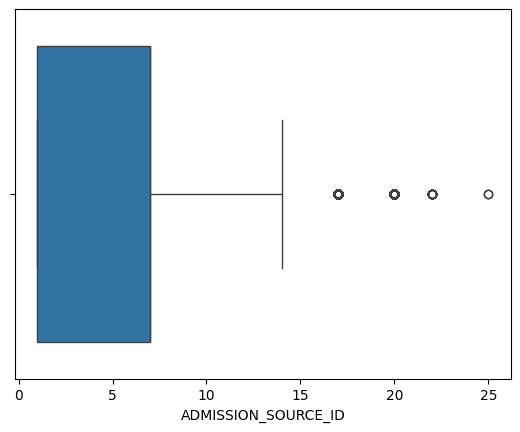

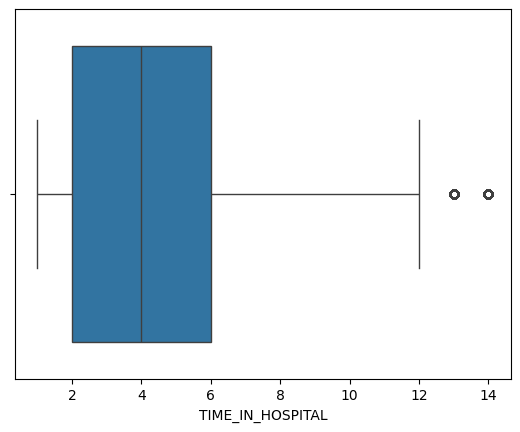

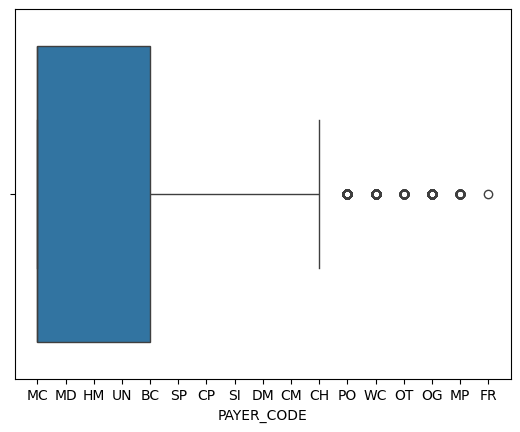

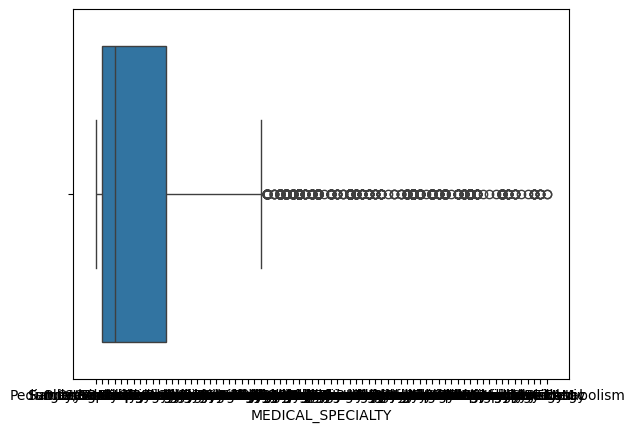

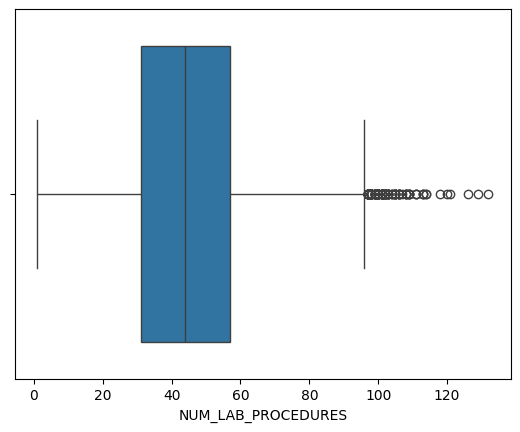

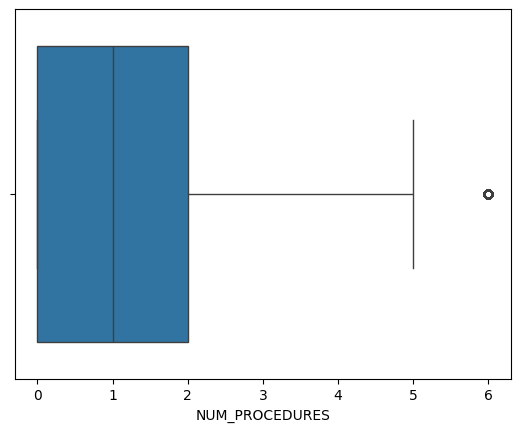

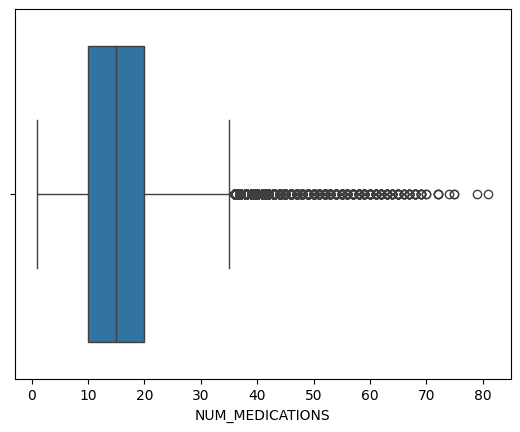

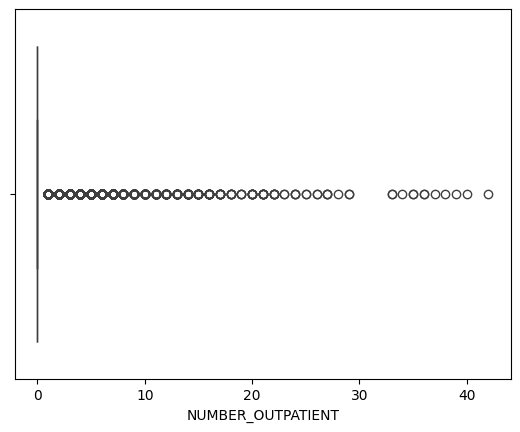

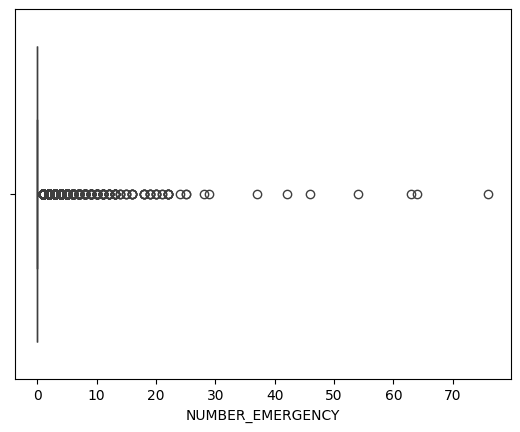

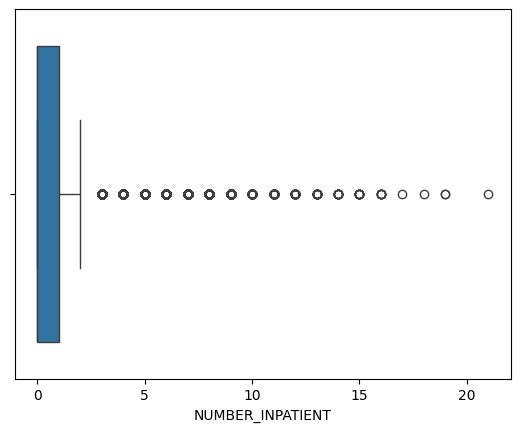

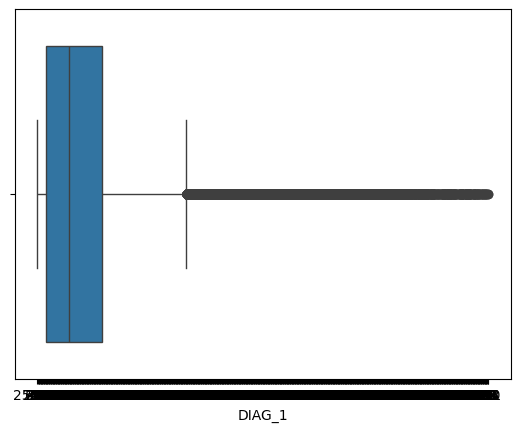

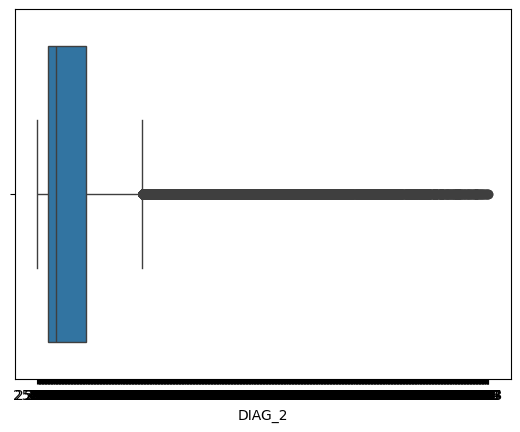

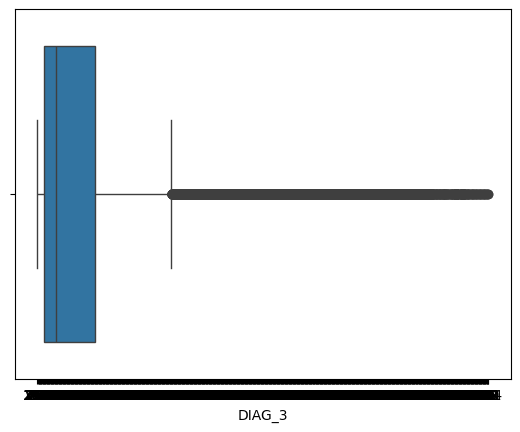

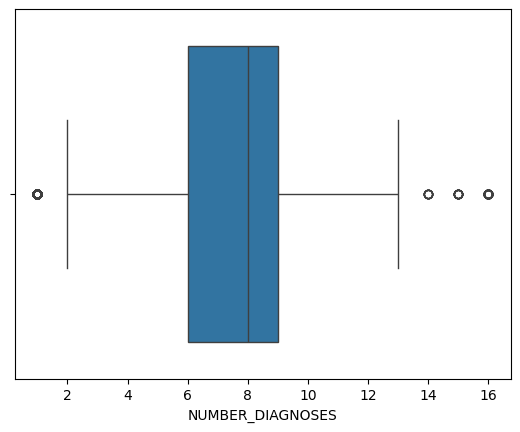

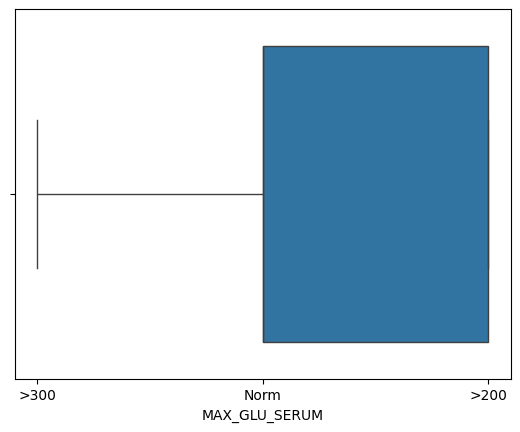

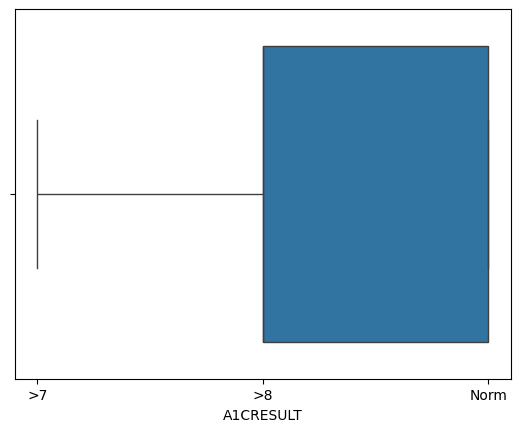

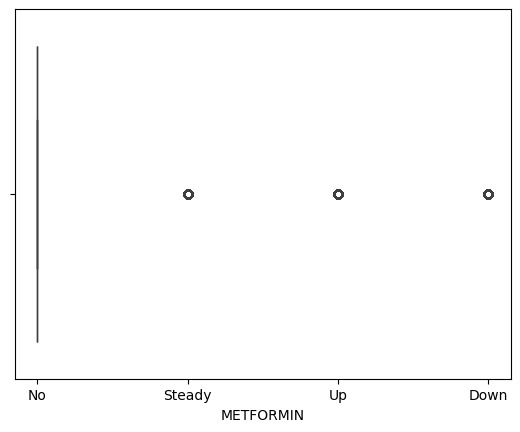

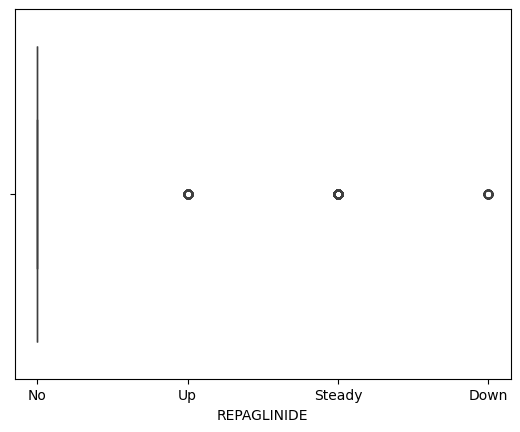

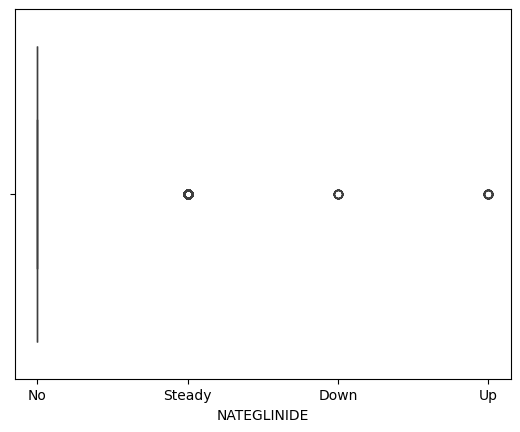

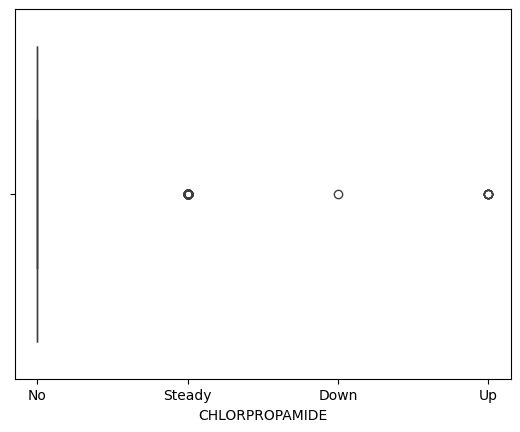

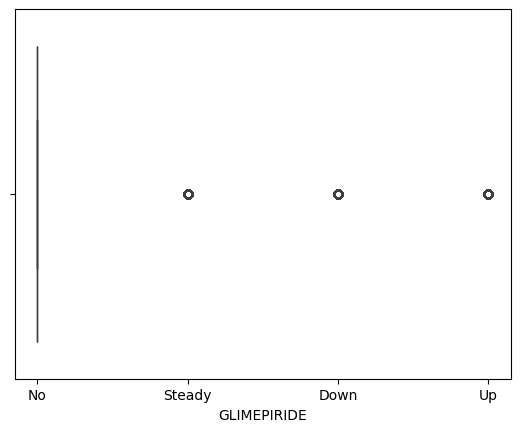

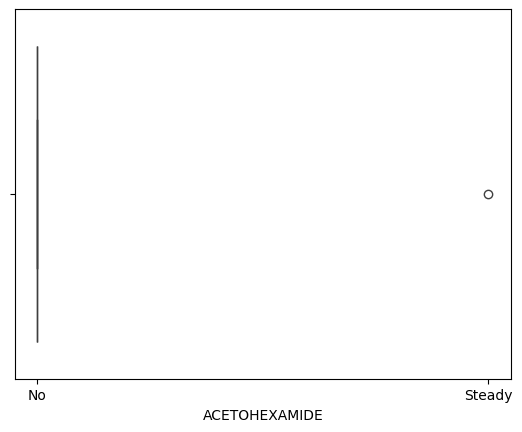

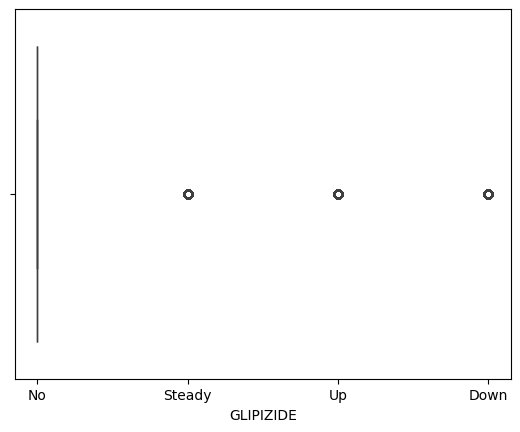

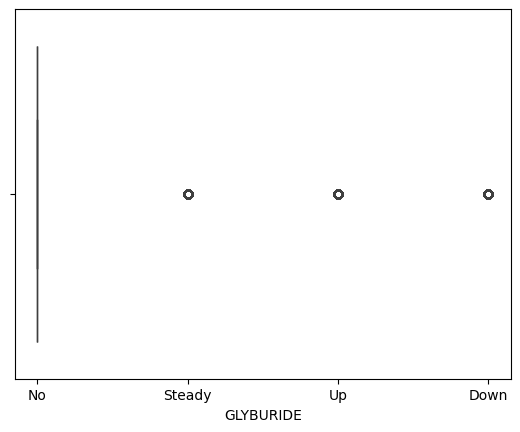

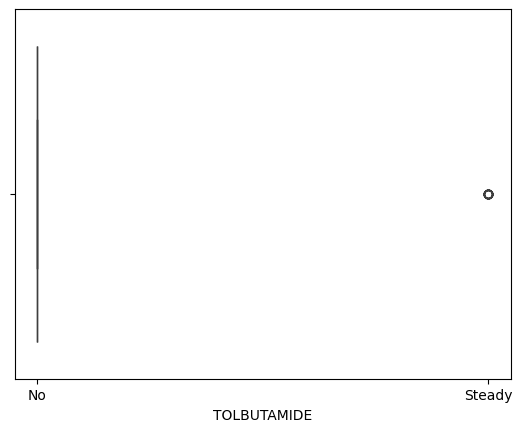

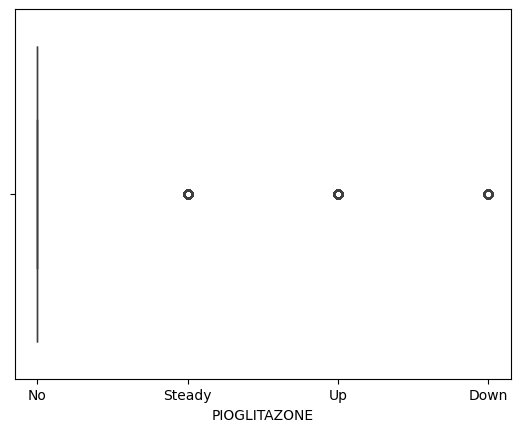

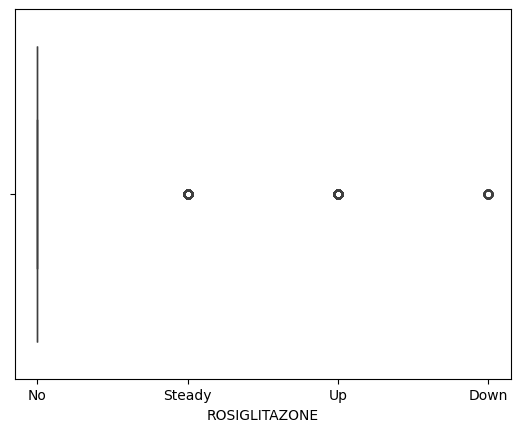

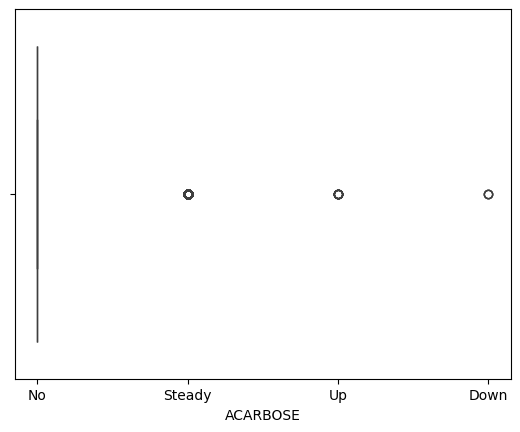

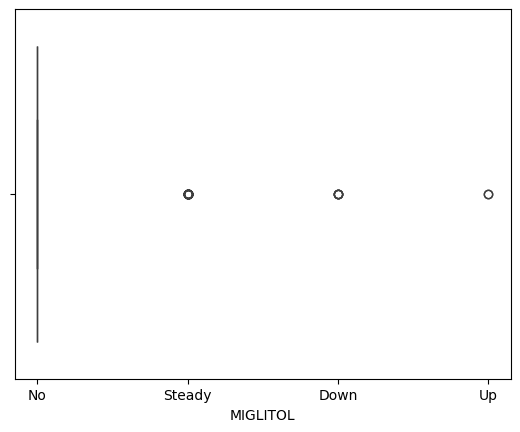

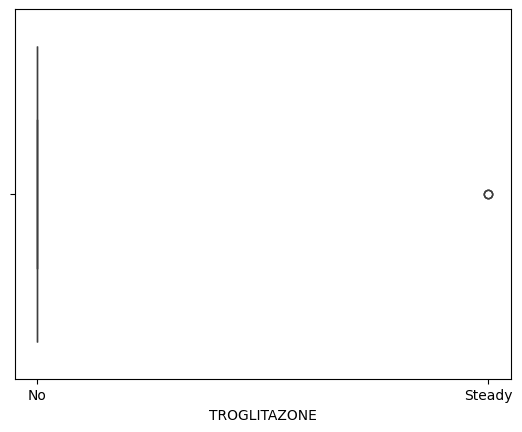

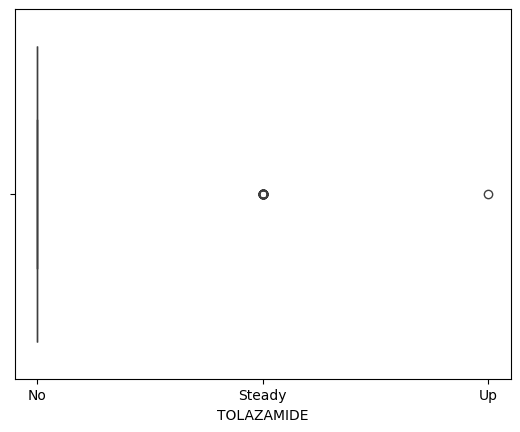

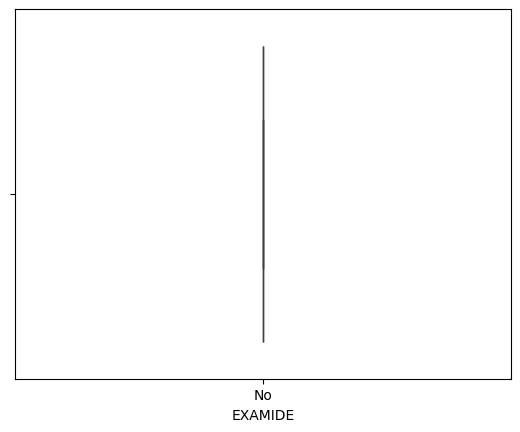

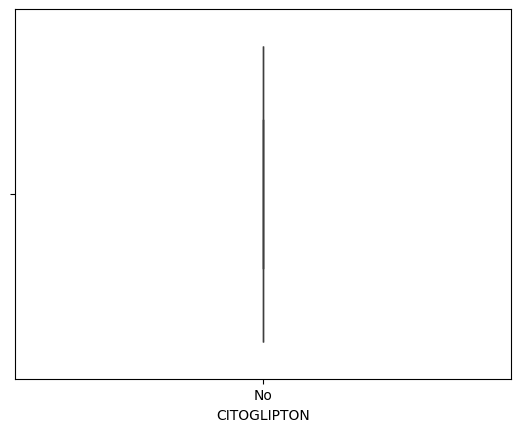

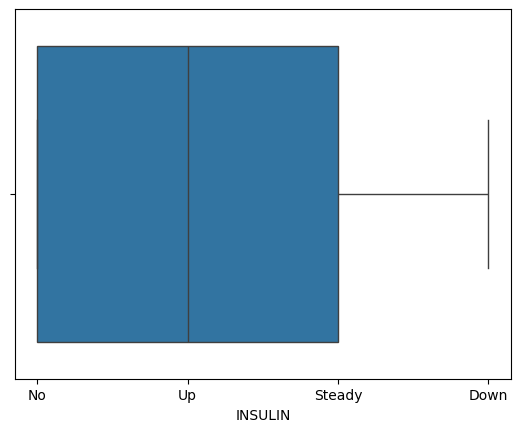

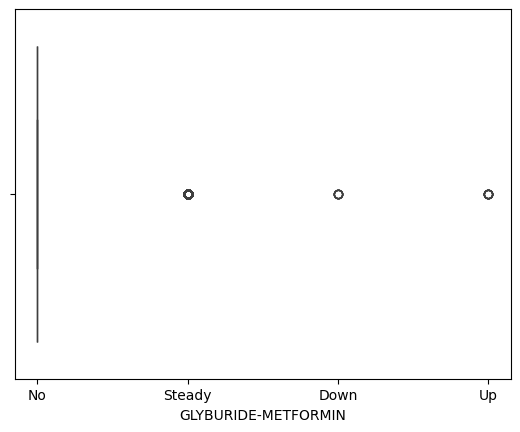

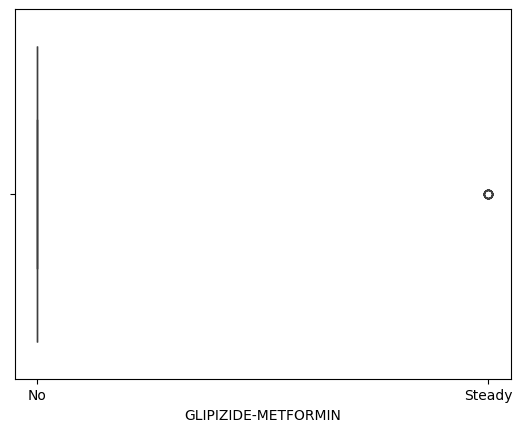

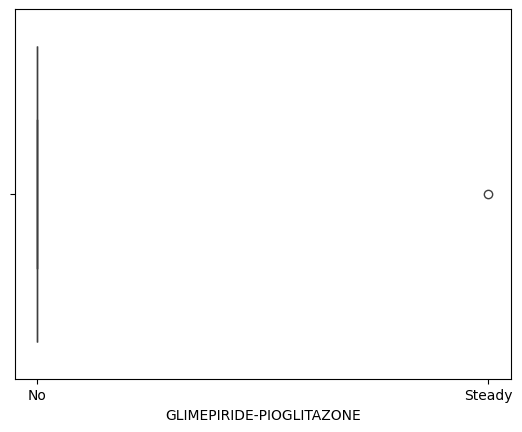

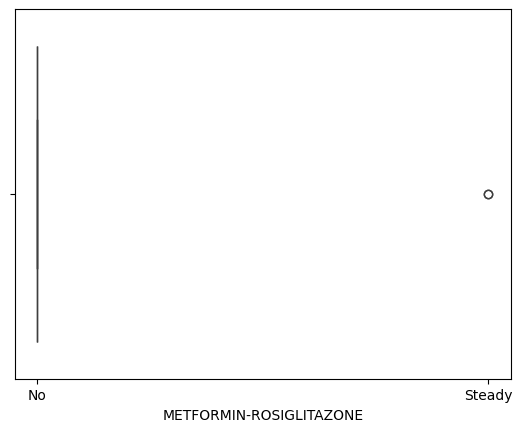

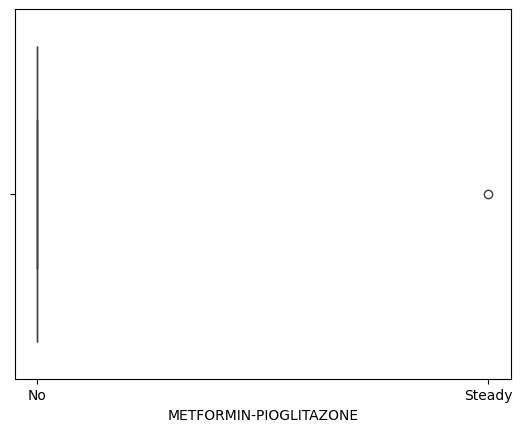

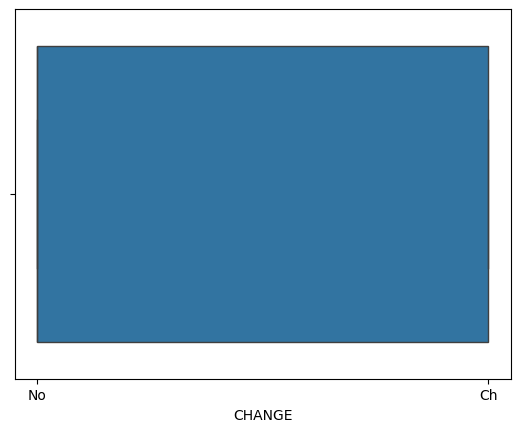

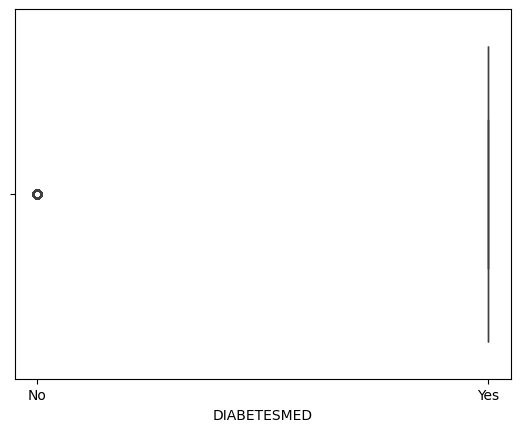

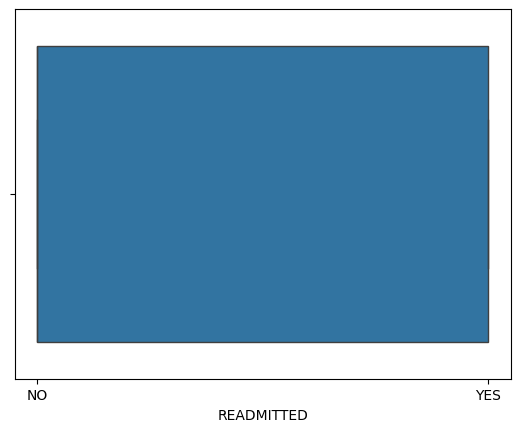

In [ ]:
# check for outliers#
for col in df.columns:
  sns.boxplot(x=df[col])
  plt.show()

In [ ]:
# sample to features ratio of df

n_samples = df.shape[0]
n_features = df.shape[1] - 1

ratio = n_samples / n_features
print(ratio)

2076.8571428571427


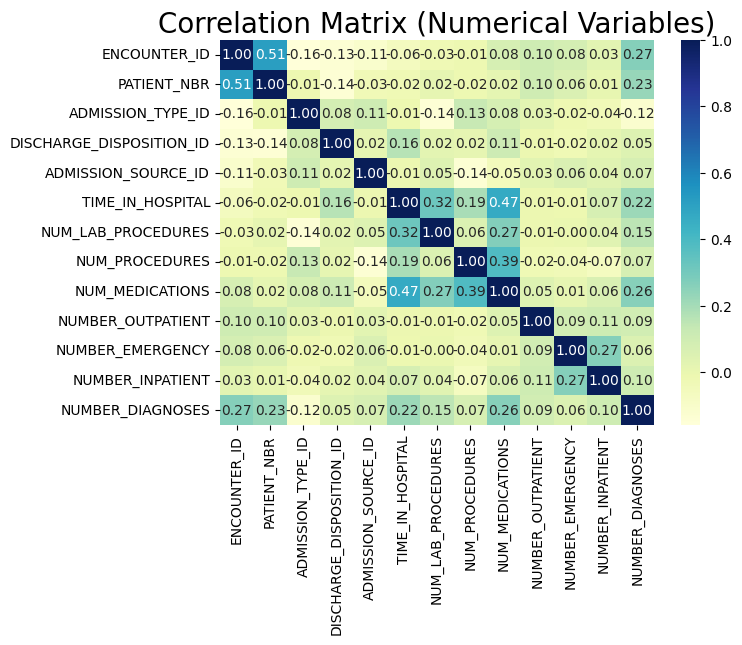

In [ ]:
# correlation for numerical variables

#first get numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != "O"]

# Calculate correlation matrix for numerical columns only
corr_matrix = df[num_cols].corr()

f, ax = plt.subplots(figsize=[7, 5])
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="YlGnBu")
ax.set_title("Correlation Matrix (Numerical Variables)", fontsize=20)
plt.show()

In [ ]:
non_categorical_features = [
    "TIME_IN_HOSPITAL", "NUM_LAB_PROCEDURES", "NUM_PROCEDURES", "NUM_MEDICATIONS", "NUMBER_OUTPATIENT",
    "NUMBER_EMERGENCY", "NUMBER_INPATIENT", "NUMBER_DIAGNOSES"
]

nominal_categorical_features = [
    "RACE", "GENDER", "PAYER_CODE", "MEDICAL_SPECIALTY", "MAX_GLU_SERUM", "A1CRESULT", "METFORMIN",
    "REPAGLINIDE", "NATEGLINIDE", "CHLORPROPAMIDE", "GLIMEPIRIDE", "GLYBURIDE", "PIOGLITAZONE",
    "ROSIGLITAZONE", "ACARBOSE", "MIGLITOL", "INSULIN", "GLYBURIDE-METFORMIN", "GLIPIZIDE", "TOLAZAMIDE"
]

ordinal_categorical_features = ["AGE", "WEIGHT", "ACETOHEXAMIDE", "TOLBUTAMIDE", "TROGLITAZONE",
                                "EXAMIDE", "CITOGLIPTON", "GLIPIZIDE-METFORMIN", "GLIMEPIRIDE-PIOGLITAZONE",
                                "METFORMIN-ROSIGLITAZONE", "METFORMIN-PIOGLITAZONE", "CHANGE", "DIABETESMED"]

pass_through_features = ["ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "ADMISSION_SOURCE_ID","DIAG_1","DIAG_2", "DIAG_3"]



In [ ]:
for feature in nominal_categorical_features:
      print(f"Category counts for {feature}:")
      print(df[feature].value_counts())
      print("-" * 20)


Category counts for RACE:
RACE
Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64
--------------------
Category counts for GENDER:
GENDER
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64
--------------------
Category counts for PAYER_CODE:
PAYER_CODE
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64
--------------------
Category counts for MEDICAL_SPECIALTY:
MEDICAL_SPECIALTY
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
Surgery-General                      3099
                                    ...  
Perinatology                         

In [ ]:
for feature in ordinal_categorical_features:
      print(f"Category counts for {feature}:")
      print(df[feature].value_counts())
      print("-" * 20)


Category counts for AGE:
AGE
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64
--------------------
Category counts for WEIGHT:
WEIGHT
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64
--------------------
Category counts for ACETOHEXAMIDE:
ACETOHEXAMIDE
No        101765
Steady         1
Name: count, dtype: int64
--------------------
Category counts for TOLBUTAMIDE:
TOLBUTAMIDE
No        101743
Steady        23
Name: count, dtype: int64
--------------------
Category counts for TROGLITAZONE:
TROGLITAZONE
No        101763
Steady         3
Name: count, dtype: int64
--------------------
Category counts for EXAMIDE:
EXAMIDE
No    101766
Name: count, dtype: int64
--------------------
Category counts for

In [ ]:
for feature in ["ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "ADMISSION_SOURCE_ID",]:
      print(f"Category counts for {feature}:")
      print(df[feature].value_counts())
      print("-" * 20)

Category counts for ADMISSION_TYPE_ID:
ADMISSION_TYPE_ID
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64
--------------------
Category counts for DISCHARGE_DISPOSITION_ID:
DISCHARGE_DISPOSITION_ID
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64
--------------------
Category counts for ADMISSION_SOURCE_ID:
ADMISSION_SOURCE_ID
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64
--------------------


In [ ]:
columns_to_drop = ['WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'MAX_GLU_SERUM', 'A1CRESULT',
                   'TOLAZAMIDE', 'GLYBURIDE-METFORMIN', 'MIGLITOL' , 'ACARBOSE',
                    'CHLORPROPAMIDE',  'METFORMIN-PIOGLITAZONE',
                   'METFORMIN-ROSIGLITAZONE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'CITOGLIPTON',
                   'EXAMIDE', 'TROGLITAZONE', 'TOLBUTAMIDE', 'ACETOHEXAMIDE','ENCOUNTER_ID' , 'PATIENT_NBR']

In [ ]:
columns_to_group = [ 'ROSIGLITAZONE', 'PIOGLITAZONE', 'GLIMEPIRIDE', 'REPAGLINIDE', 'GLYBURIDE', 'GLIPIZIDE', 'NATEGLINIDE' ]

##  Task 2: Data assembling and initial pre-processing##

In [ ]:
# delete rows with missing values
#delete missing values from race
df = df.dropna(subset=['RACE'])
# delete is diag columns
df = df.dropna(subset=['DIAG_1', 'DIAG_2', 'DIAG_3'])
# drop unknown invalid gender
df = df[df['GENDER'] != 'Unknown/Invalid']


In [ ]:
# reduce features that are imbalanced
columns_to_group = [
    'ROSIGLITAZONE', 'PIOGLITAZONE', 'GLIMEPIRIDE', 'REPAGLINIDE',
    'GLYBURIDE', 'GLIPIZIDE', 'NATEGLINIDE'
]

for col in columns_to_group:
    df[col] = df[col].apply(lambda x: 'Yes' if x != 'No' else 'No')



print(df[columns_to_group].head())

  ROSIGLITAZONE PIOGLITAZONE GLIMEPIRIDE REPAGLINIDE GLYBURIDE GLIPIZIDE  \
1            No           No          No          No        No        No   
2            No           No          No          No        No       Yes   
3            No           No          No          No        No        No   
4            No           No          No          No        No       Yes   
5            No           No          No          No        No        No   

  NATEGLINIDE  
1          No  
2          No  
3          No  
4          No  
5          No  


In [ ]:

def group_minority_categories_average(df, feature, threshold):

    value_counts = df[feature].value_counts()
    minor_categories = value_counts[value_counts < threshold].index.tolist()

    if not minor_categories:
        return df
    minor_values = df[df[feature].isin(minor_categories)][feature]
    if minor_values.empty:
      return df

    average_value = int(round(minor_values.mean()))

    df[feature] = df[feature].apply(lambda x: average_value if x in minor_categories else x)
    return df


features_to_group = ["ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "ADMISSION_SOURCE_ID"]
thresholds = {
    "ADMISSION_TYPE_ID": 1000,
    "DISCHARGE_DISPOSITION_ID": 1000,
    "ADMISSION_SOURCE_ID": 1000,
}

# Group minority categories for each feature
for feature in features_to_group:
    df = group_minority_categories_average(df, feature, thresholds[feature])

for feature in features_to_group:
    print(f"Updated category counts for {feature}:")
    print(df[feature].value_counts())
    print("-" * 20)

Updated category counts for ADMISSION_TYPE_ID:
ADMISSION_TYPE_ID
1    52178
3    18193
2    17543
6     5135
5     4661
8      342
Name: count, dtype: int64
--------------------
Updated category counts for DISCHARGE_DISPOSITION_ID:
DISCHARGE_DISPOSITION_ID
1     57609
3     13564
6     12626
15     3877
18     3624
2      2049
22     1970
11     1606
5      1127
Name: count, dtype: int64
--------------------
Updated category counts for ADMISSION_SOURCE_ID:
ADMISSION_SOURCE_ID
7     57226
1     28355
17     6602
4      2945
6      1893
2      1031
Name: count, dtype: int64
--------------------


In [ ]:
# print unique ADMISSION_SOURCE_ID
print(df['ADMISSION_SOURCE_ID'].unique())

[ 7  2  4  1  6 17]


In [ ]:
def map_diagnosis(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data["temp_diag"] = np.nan
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), "temp_diag"] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), "temp_diag"] = "Digestive"
        data.loc[(data[col]>=250) & (data[col]<251), "temp_diag"] = "Diabetes"
        data.loc[(data[col]>=800) & (data[col]<=999), "temp_diag"] = "Injury"
        data.loc[(data[col]>=710) & (data[col]<=739), "temp_diag"] = "Muscoloskeletal"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), "temp_diag"] = "Genitourinary"
        data.loc[(data[col]>=140) & (data[col]<=239), "temp_diag"] = "Neoplasms"

        data["temp_diag"] = data["temp_diag"].fillna("Other")
        data[col] = data["temp_diag"]
        data = data.drop("temp_diag", axis=1)

    return data

In [ ]:
diabet = map_diagnosis(df,["DIAG_1","DIAG_2","DIAG_3"])


<ipython-input-44-e854a8049a21>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Circulatory' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
<ipython-input-44-e854a8049a21>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Circulatory' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
<ipython-input-44-e854a8049a21>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Circulatory' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc

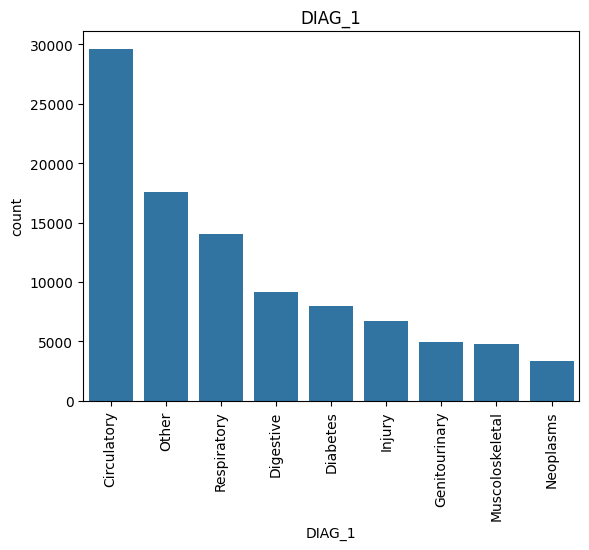

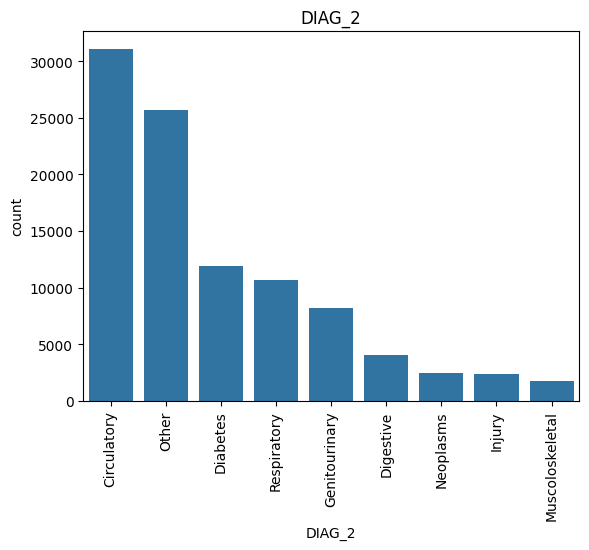

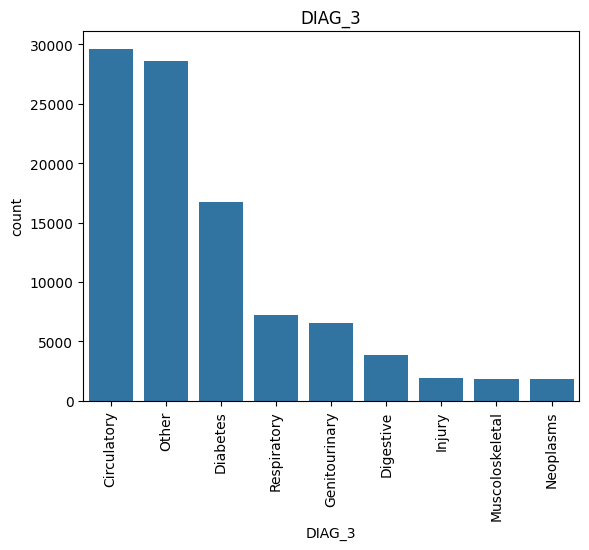

In [ ]:
def plot_diags(col,data):
    sns.countplot(x = col, data = data,
            order = data[f"{col}"].value_counts().index)
    plt.xticks(rotation = 90)
    plt.title(col)
    plt.show()

diag_cols = ["DIAG_1","DIAG_2","DIAG_3"]

for diag in diag_cols:
    plot_diags(diag,diabet)

In [ ]:
df['DIAG_2'] = diabet['DIAG_2']

In [ ]:
df['DIAG_3'] = diabet['DIAG_3']

In [ ]:
non_categorical_features = [
    "TIME_IN_HOSPITAL", "NUM_LAB_PROCEDURES", "NUM_PROCEDURES", "NUM_MEDICATIONS", "NUMBER_OUTPATIENT",
    "NUMBER_EMERGENCY", "NUMBER_INPATIENT", "NUMBER_DIAGNOSES"
]

nominal_categorical_features = [
    "RACE", "GENDER",  "METFORMIN",
       "GLYBURIDE",
      "INSULIN",  "GLIPIZIDE", "DIAG_1", "DIAG_2", "DIAG_3"
]

ordinal_categorical_features = ["AGE",

                                 "CHANGE", "DIABETESMED", 'ROSIGLITAZONE', 'PIOGLITAZONE', 'GLIMEPIRIDE', 'REPAGLINIDE', 'GLYBURIDE', 'GLIPIZIDE', 'NATEGLINIDE']



pass_through_features = ["ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "ADMISSION_SOURCE_ID"]


In [ ]:
#print unique values in diag_2
df['DIAG_2'].unique()


array(['Diabetes', 'Neoplasms', 'Circulatory', 'Respiratory', 'Other',
       'Injury', 'Muscoloskeletal', 'Genitourinary', 'Digestive'],
      dtype=object)

In [ ]:
# drop columns from df
df = df.drop(columns_to_drop, axis=1)



In [ ]:
df, _ = train_test_split(df, train_size=0.1, stratify=df['READMITTED'], random_state=42)


In [ ]:
def train_test_split_df(df: pd.DataFrame, test_ratio=0.2, target_col="READMITTED", random_state=42):
    df_data = df.drop(columns=[target_col])
    df_target = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        df_data, df_target, test_size=test_ratio, random_state=random_state
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test= train_test_split_df(df)



In [ ]:
X_train['DIAG_1'].unique()

array(['Muscoloskeletal', 'Circulatory', 'Other', 'Injury', 'Respiratory',
       'Genitourinary', 'Neoplasms', 'Diabetes', 'Digestive'],
      dtype=object)

In [ ]:
y_train = y_train.map({'NO': 0, 'YES': 1})
y_test = y_test.map({'NO': 0, 'YES': 1})


In [ ]:
print("Training set size: ", len(X_train))
print("Test set size: ",len(X_test))

Training set size:  7844
Test set size:  1961


In [ ]:
X_train.shape

(7844, 29)

In [ ]:
age_categories = ['[0-10)','[10-20)','[20-30)','[30-40)','[40-50)','[50-60)','[60-70)','[70-80)','[80-90)','[90-100)']
change_categories = ["No", "Ch"]
diabetesmed_categories = ["No","Yes"]
rosiglitazone_categories = ['No', 'Yes']
pioglitazone_categories = ['No', 'Yes']
glimepiride_categories = ['No', 'Yes']
repaglinide_categories = ['No', 'Yes']
glyburide_categories = ['No', 'Yes']
glipizide_categories = ['No', 'Yes']
nateglinide_categories = ['No', 'Yes']


#ordinal_categories = [age_order, weight_order,ace_order,tol_order,
                        #    trog_order,examide_order, cit_order, glip_order, glim_order,metr_order,
#                            metp_order,change_order, diabetes_order ]


ordinal_categories = [
    age_categories, change_categories, diabetesmed_categories,
    rosiglitazone_categories, pioglitazone_categories, glimepiride_categories,
    repaglinide_categories, glyburide_categories, glipizide_categories,
    nateglinide_categories
]







In [ ]:
non_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

nominal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ]
)

ordinal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=ordinal_categories)),
    ]
)


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", non_categorical_transformer, non_categorical_features),
        ("nominal_cat", nominal_categorical_transformer, nominal_categorical_features),
        ("ordinal_cat", ordinal_categorical_transformer, ordinal_categorical_features),
        ("pass_through", "passthrough", pass_through_features),
    ]
)

preprocessor.fit_transform(X_train)

array([[-0.4732458 , -1.7995115 , -0.20855428, ...,  3.        ,
         6.        ,  1.        ],
       [-1.1508291 , -2.10050343,  1.55047777, ...,  3.        ,
         1.        ,  1.        ],
       [-0.4732458 , -0.39488244, -0.20855428, ...,  8.        ,
         1.        ,  1.        ],
       ...,
       [-0.13445416,  0.30743208, -0.20855428, ...,  5.        ,
         3.        ,  1.        ],
       [-0.13445416, -0.24438647,  1.55047777, ...,  1.        ,
         1.        ,  7.        ],
       [ 2.23708737,  1.31073855,  2.72316581, ...,  1.        ,
         1.        ,  7.        ]])

In [ ]:
df_data = preprocessor.fit_transform(X_train)

In [ ]:
preprocessor.fit_transform(X_train).shape

(7844, 58)

#Task 3#

In [ ]:
#3.1. Metrics
# accuracy, precision, receall, f1, roc-auc, confusion matrix

In [ ]:
#3.2 SVC, decision tree and random forest

In [ ]:
#3.3
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc






In [ ]:
models = {
    "SVC": {
        "model": SVC(random_state=42, probability=True),
        "params": {
            "svc__C": [0.1, 1, 10],
            "svc__kernel": ["linear"],
        },
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "randomforest__n_estimators": [50, 100, 200],
            "randomforest__max_depth": [None, 10, 20],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000, solver='saga'),
        "params": {
            "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
            "logisticregression__penalty": ['l1', 'l2'],
        },
    },
}

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
grid_search_results = {}
best_model_results = []  # List to store best model results

for model_name, model_info in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        (model_name.lower(), model_info["model"]),
    ])

    grid_search = GridSearchCV(pipeline, model_info["params"], cv=cv, scoring="accuracy", n_jobs=-1, verbose=0, return_train_score=True)
    grid_search.fit(X_train, y_train)

    grid_search_results[model_name] = grid_search.cv_results_
    results[model_name] = {}

    # Extract and print the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print("-" * 20)

    for i in range(len(grid_search.cv_results_['params'])):
        params = grid_search.cv_results_['params'][i]
        mean_test_score = grid_search.cv_results_['mean_test_score'][i]
        std_test_score = grid_search.cv_results_['std_test_score'][i]
        mean_train_score = grid_search.cv_results_['mean_train_score'][i]
        std_train_score = grid_search.cv_results_['std_train_score'][i]

        best_model = grid_search.best_estimator_.set_params(**params)
        best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_curve = auc(fpr, tpr)

        results[model_name][i] = {
            "params": params,
            "cv_mean_accuracy": mean_test_score,
            "cv_std_accuracy": std_test_score,
            "cv_mean_train_accuracy": mean_train_score,
            "cv_std_train_accuracy": std_train_score,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "y_prob": y_prob,
            "fpr": fpr,
            "tpr": tpr,
            "roc_auc_curve": roc_auc_curve,
        }

    best_index = grid_search.best_index_
    best_result = results[model_name][best_index]

    best_model_results.append({
        "Model": model_name,
        "Best Parameters": best_result['params'],
        "CV Mean Accuracy": best_result['cv_mean_accuracy'],
        "CV Std Accuracy": best_result['cv_std_accuracy'],
        "Test Accuracy": best_result['accuracy'],
        "Test Precision": best_result['precision'],
        "Test Recall": best_result['recall'],
        "Test F1-score": best_result['f1'],
        "Test ROC-AUC": best_result['roc_auc'],
        "Confusion Matrix": best_result['confusion_matrix']
    })



# Create DataFrame from best model results
best_model_df = pd.DataFrame(best_model_results)

print("\nBest Model Results:")
print(best_model_df)

Model: SVC
Best Parameters: {'svc__C': 1, 'svc__kernel': 'linear'}
--------------------
Model: RandomForest
Best Parameters: {'randomforest__max_depth': 10, 'randomforest__n_estimators': 100}
--------------------
Model: LogisticRegression
Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
--------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model Results:
                Model                                    Best Parameters  \
0                 SVC             {'svc__C': 1, 'svc__kernel': 'linear'}   
1        RandomForest  {'randomforest__max_depth': 10, 'randomforest_...   
2  LogisticRegression  {'logisticregression__C': 0.1, 'logisticregres...   

   CV Mean Accuracy  CV Std Accuracy  Test Accuracy  Test Precision  \
0          0.610914         0.011662       0.575217        0.634921   
1          0.631565         0.011777       0.594595        0.612540   
2          0.617670         0.010312       0.587965        0.610052   

   Test Recall  Test F1-score  Test ROC-AUC          Confusion Matrix  
0     0.256684       0.365575      0.645088  [[888, 138], [695, 240]]  
1     0.407487       0.489403      0.667138  [[785, 241], [554, 381]]  
2     0.376471       0.465608      0.645806  [[801, 225], [583, 352]]  


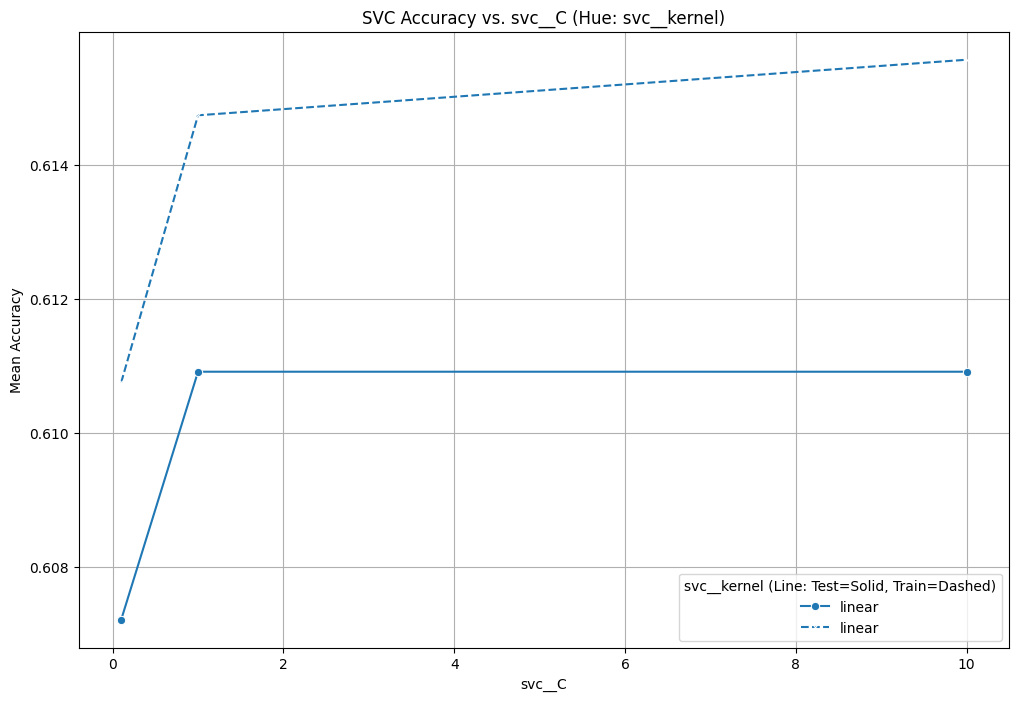

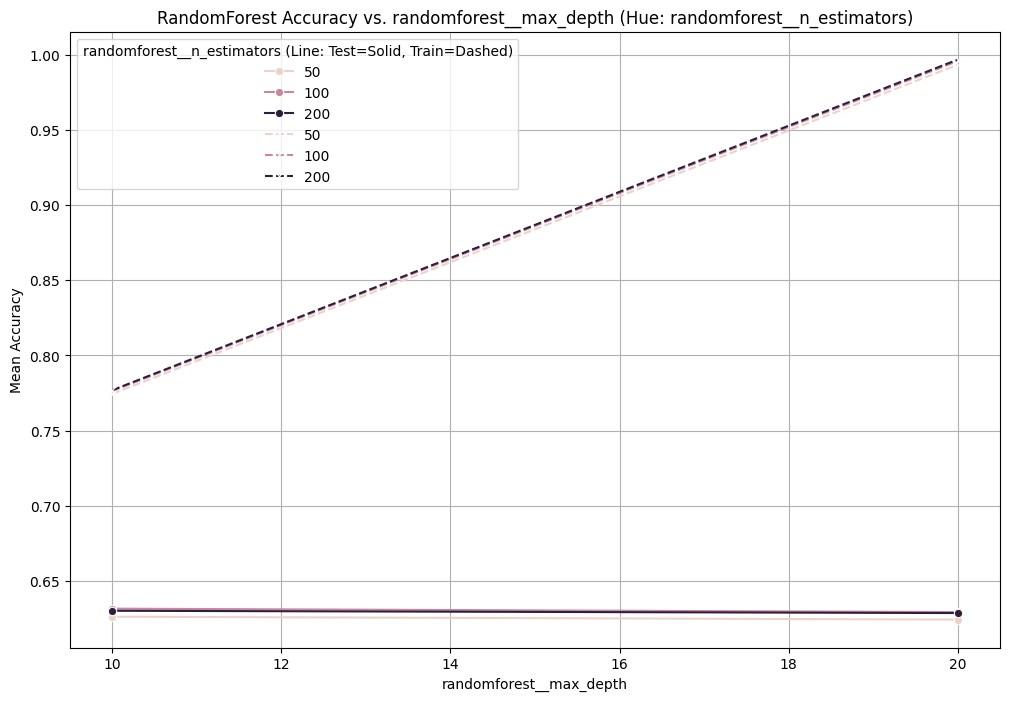

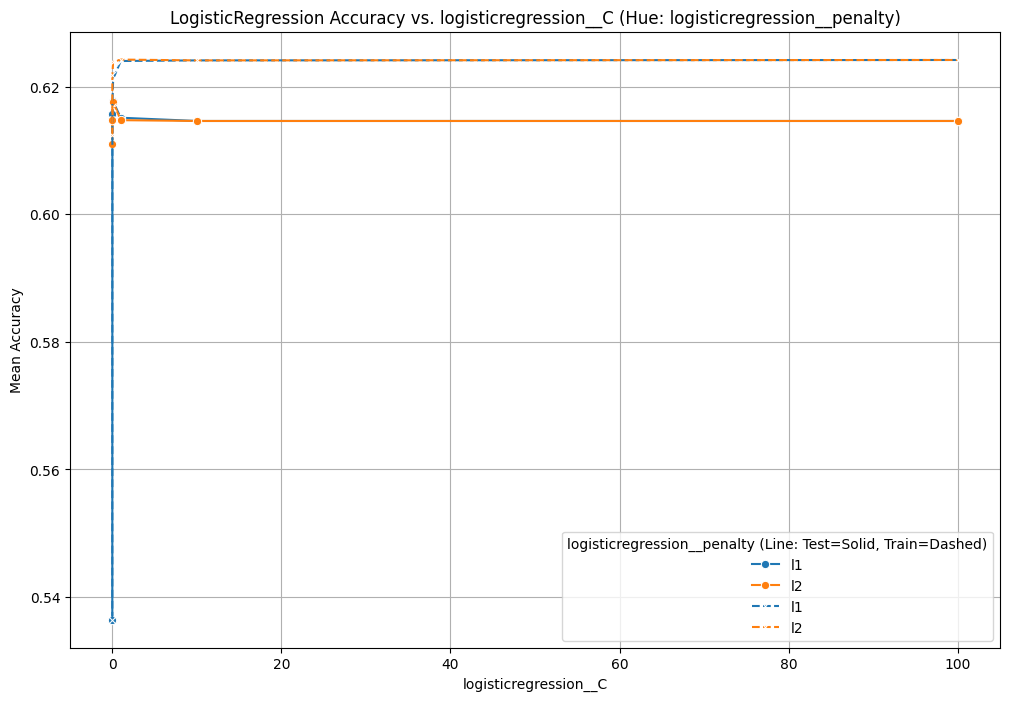

In [ ]:


def plot_hyperparameter_performance(grid_search_result, model_name):
    params = grid_search_result['params']
    results = pd.DataFrame(grid_search_result)

    # Extract hyperparameter names
    param_names = list(params[0].keys())

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame(params)
    plot_data['mean_test_accuracy'] = results['mean_test_score']
    if 'mean_train_score' in results:
        plot_data['mean_train_accuracy'] = results['mean_train_score']

    # Determine plot type based on number of hyperparameters
    if len(param_names) == 1:
        param_name = param_names[0]
        plt.figure(figsize=(10, 6))
        sns.lineplot(x=param_name, y='mean_test_accuracy', data=plot_data, marker='o', label='Test Accuracy')
        if 'mean_train_accuracy' in plot_data:
            sns.lineplot(x=param_name, y='mean_train_accuracy', data=plot_data, marker='x', label='Train Accuracy')
        plt.title(f'{model_name} Accuracy vs. {param_name}')
        plt.grid(True)
        plt.legend()
        plt.ylabel("Mean Accuracy")
        plt.show()
    elif len(param_names) == 2:
        # Two hyperparameters: line plot with hue
        x_param, hue_param = param_names

        if 'n_estimators' in x_param and 'max_depth' in hue_param:
            x_param, hue_param = 'randomforest__n_estimators', 'randomforest__max_depth'
        elif 'C' in x_param and 'kernel' in hue_param:
            x_param, hue_param = 'svc__C', 'svc__kernel'
        elif 'C' in x_param and 'penalty' in hue_param:
            x_param, hue_param = 'logisticregression__C', 'logisticregression__penalty'

        plt.figure(figsize=(12, 8))
        sns.lineplot(x=x_param, y='mean_test_accuracy', hue=hue_param, data=plot_data, marker='o', errorbar=None)
        if 'mean_train_accuracy' in plot_data:
            sns.lineplot(x=x_param, y='mean_train_accuracy', hue=hue_param, data=plot_data, marker='x', linestyle='--', errorbar=None)
        plt.title(f'{model_name} Accuracy vs. {x_param} (Hue: {hue_param})')
        plt.grid(True)
        plt.legend(title=f'{hue_param} (Line: Test=Solid, Train=Dashed)')
        plt.ylabel("Mean Accuracy")
        plt.show()
    else:
        print(f"Cannot plot more than 2 hyperparameters for {model_name}.")

# Generate Plots
for model_name, grid_result in grid_search_results.items():
    plot_hyperparameter_performance(grid_result, model_name)

In [ ]:
table_data = []
for model_name, model_results in results.items():
    for i, result in model_results.items():
        train_mean = result['cv_mean_train_accuracy']
        test_mean = result['cv_mean_accuracy']
        test_std = result['cv_std_accuracy']
        train_std = result['cv_std_train_accuracy']
        table_data.append({
            "Model": model_name,
            "Params": result['params'],
            "CV Mean Accuracy": f"{train_mean:.4f} ± {train_std:.4f}",
            "Test Mean Accuracy": f"{test_mean:.4f} ± {test_std:.4f}",
        })

results_table = pd.DataFrame(table_data)
print(results_table)

                 Model                                             Params  \
0                  SVC           {'svc__C': 0.1, 'svc__kernel': 'linear'}   
1                  SVC             {'svc__C': 1, 'svc__kernel': 'linear'}   
2                  SVC            {'svc__C': 10, 'svc__kernel': 'linear'}   
3         RandomForest  {'randomforest__max_depth': None, 'randomfores...   
4         RandomForest  {'randomforest__max_depth': None, 'randomfores...   
5         RandomForest  {'randomforest__max_depth': None, 'randomfores...   
6         RandomForest  {'randomforest__max_depth': 10, 'randomforest_...   
7         RandomForest  {'randomforest__max_depth': 10, 'randomforest_...   
8         RandomForest  {'randomforest__max_depth': 10, 'randomforest_...   
9         RandomForest  {'randomforest__max_depth': 20, 'randomforest_...   
10        RandomForest  {'randomforest__max_depth': 20, 'randomforest_...   
11        RandomForest  {'randomforest__max_depth': 20, 'randomforest_...   

In [ ]:
grid_search_results['LogisticRegression']

{'mean_fit_time': array([ 0.2132185 ,  0.68387814,  0.35471325,  1.75057964,  2.37879701,
         3.64464931,  4.39528728,  8.04141617, 12.15820661, 10.34030867,
        13.60895891,  9.92671738]),
 'std_fit_time': array([0.01547729, 0.0312877 , 0.02639446, 0.39089852, 1.11552134,
        0.41941016, 0.3095116 , 0.58964787, 2.07025205, 0.64074585,
        0.92836351, 1.31808618]),
 'mean_score_time': array([0.02919078, 0.03397551, 0.0309598 , 0.04402437, 0.03047762,
        0.03896785, 0.04227252, 0.02956195, 0.04157276, 0.03631673,
        0.04371533, 0.03141971]),
 'std_score_time': array([0.00070654, 0.00861731, 0.0026351 , 0.01250383, 0.00073002,
        0.01201881, 0.01329634, 0.00127922, 0.01262181, 0.01198235,
        0.01237773, 0.00661754]),
 'param_logisticregression__C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 10.0,
                    10.0, 100.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                  

In [ ]:
print("\nBest Model Results:")
print(best_model_df)


Best Model Results:
                Model                                    Best Parameters  \
0                 SVC             {'svc__C': 1, 'svc__kernel': 'linear'}   
1        RandomForest  {'randomforest__max_depth': 10, 'randomforest_...   
2  LogisticRegression  {'logisticregression__C': 0.1, 'logisticregres...   

   CV Mean Accuracy  CV Std Accuracy  Test Accuracy  Test Precision  \
0          0.610914         0.011639       0.575727        0.635884   
1          0.631565         0.011777       0.594595        0.612540   
2          0.617670         0.010312       0.587965        0.610052   

   Test Recall  Test F1-score  Test ROC-AUC          Confusion Matrix  
0     0.257754       0.366819      0.645137  [[888, 138], [694, 241]]  
1     0.407487       0.489403      0.667138  [[785, 241], [554, 381]]  
2     0.376471       0.465608      0.645806  [[801, 225], [583, 352]]  


In [ ]:
pd.set_option('display.max_colwidth', None)


In [ ]:
print("\nBest Model Parameters:")
print(best_model_df['Best Parameters'])


Best Model Parameters:
0               {'svc__C': 1, 'svc__kernel': 'linear'}
1    {'randomforest__max_depth': 10, 'randomforest_...
2    {'logisticregression__C': 0.1, 'logisticregres...
Name: Best Parameters, dtype: object


## Task 4 ##

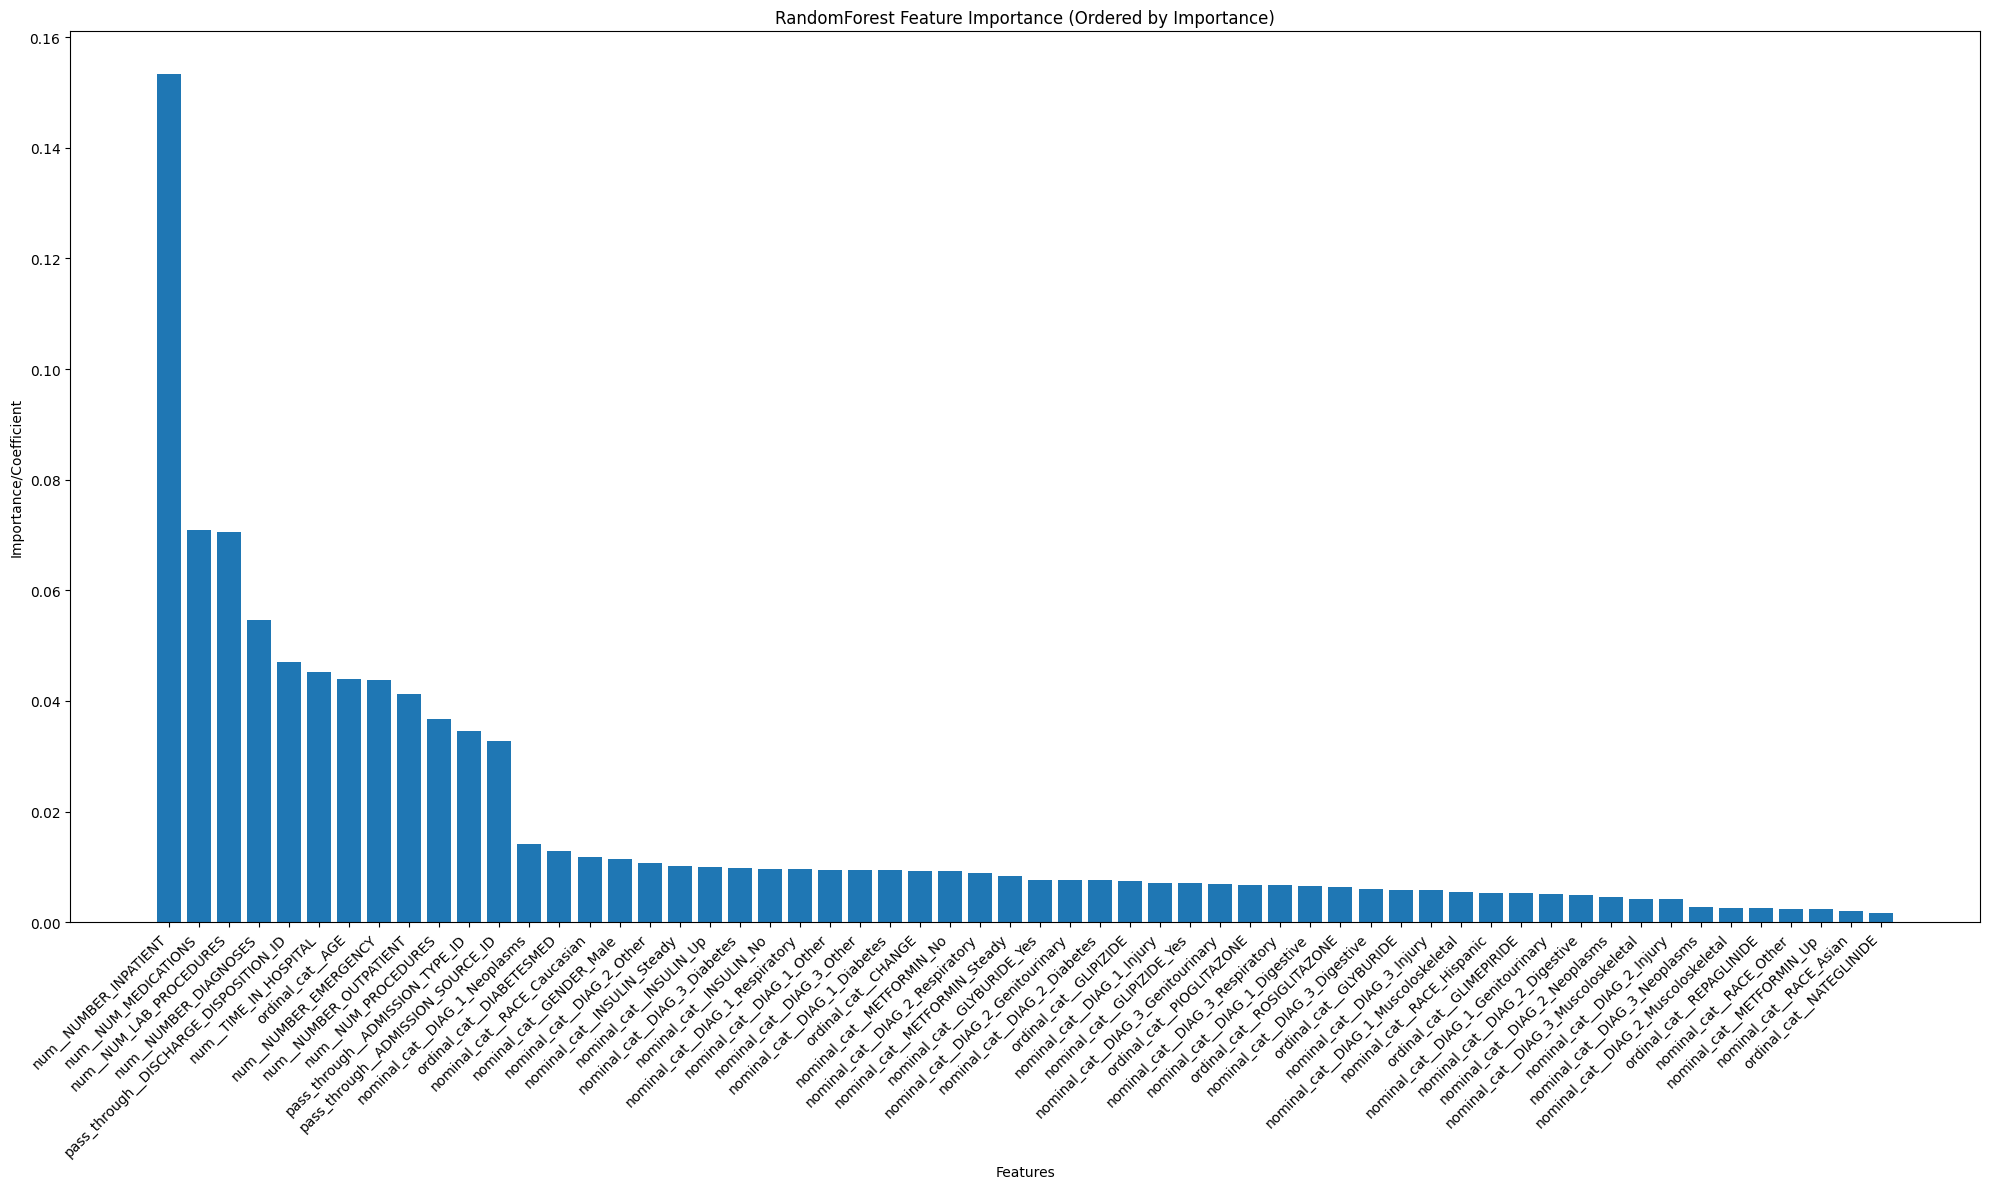

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


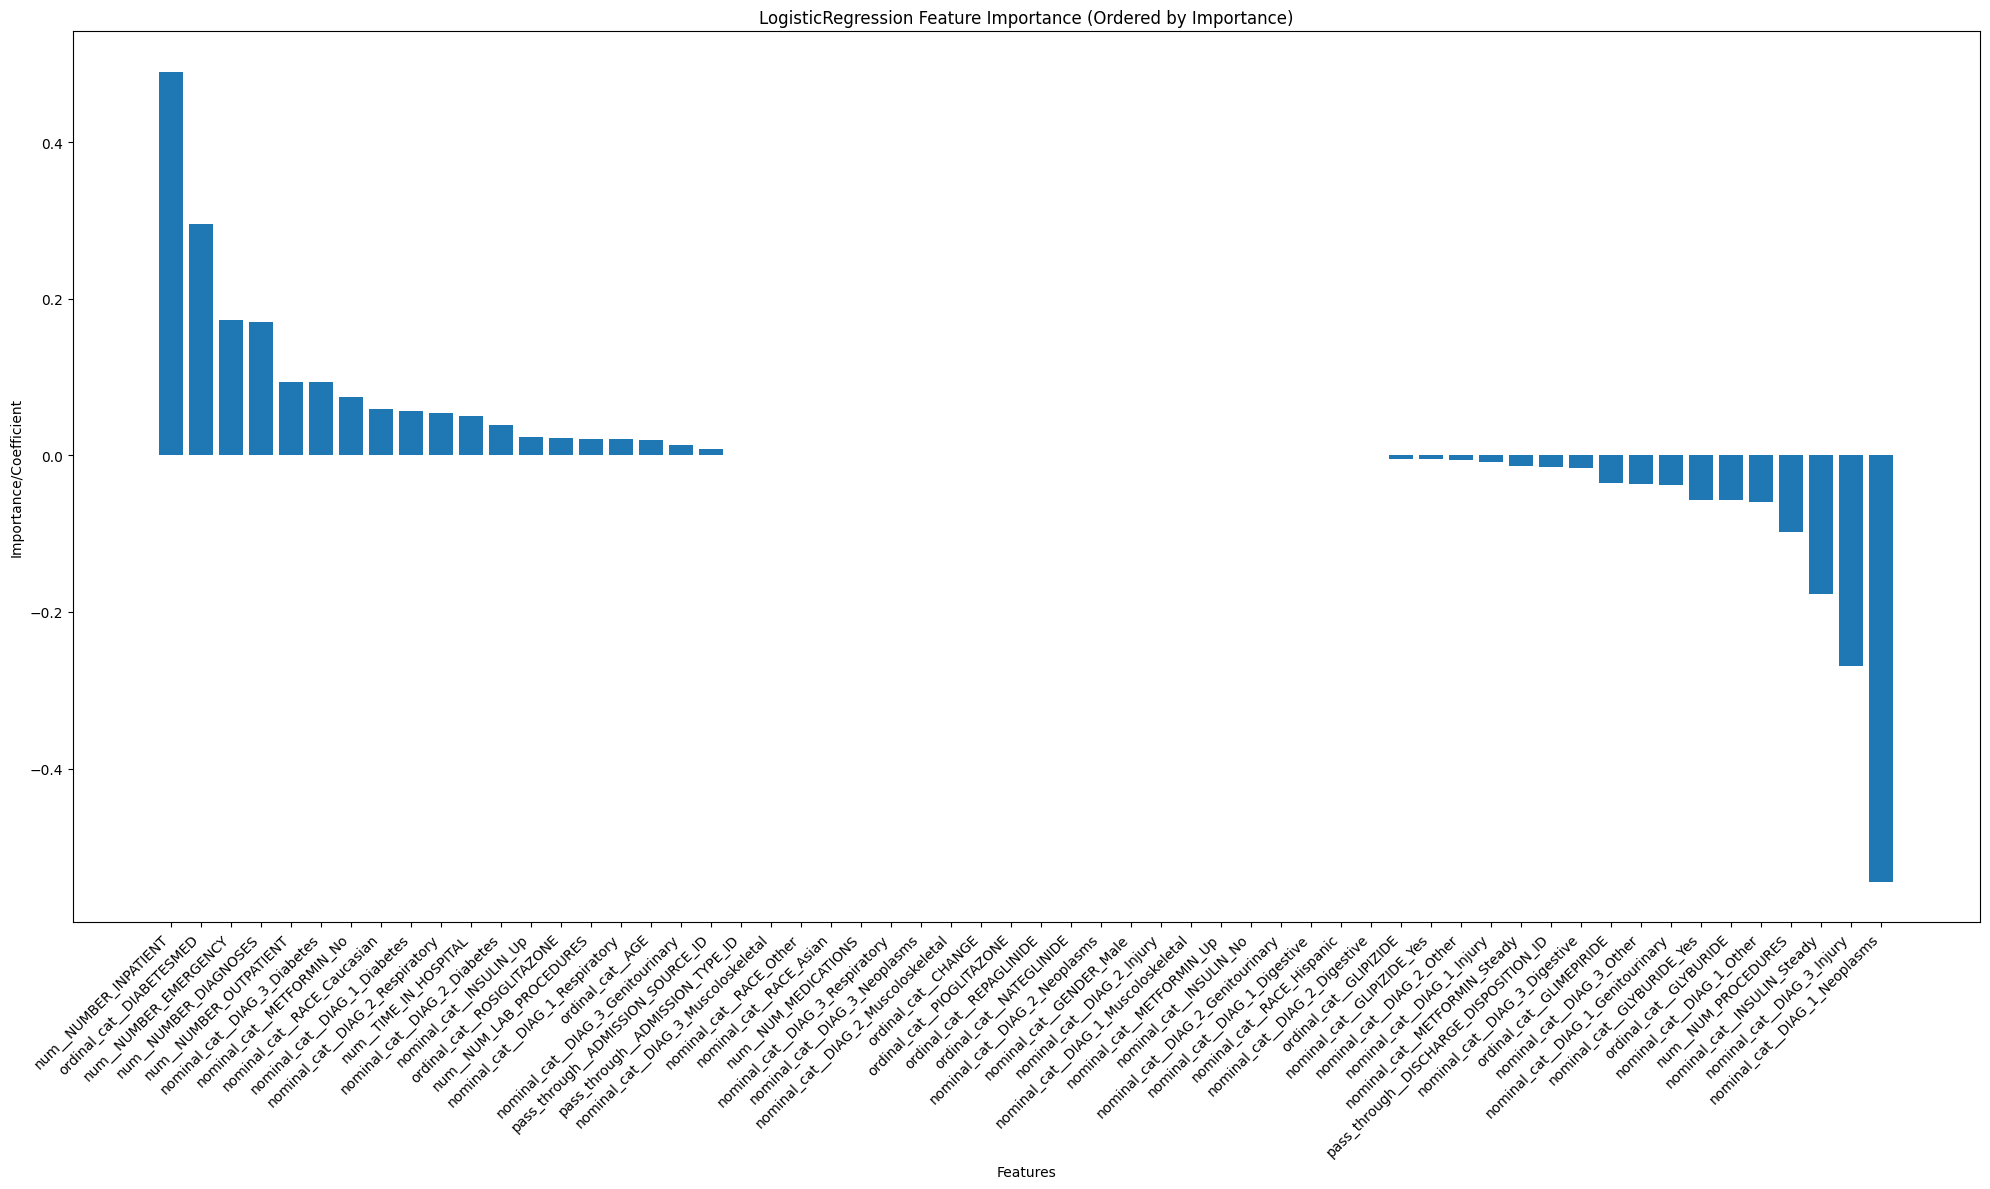

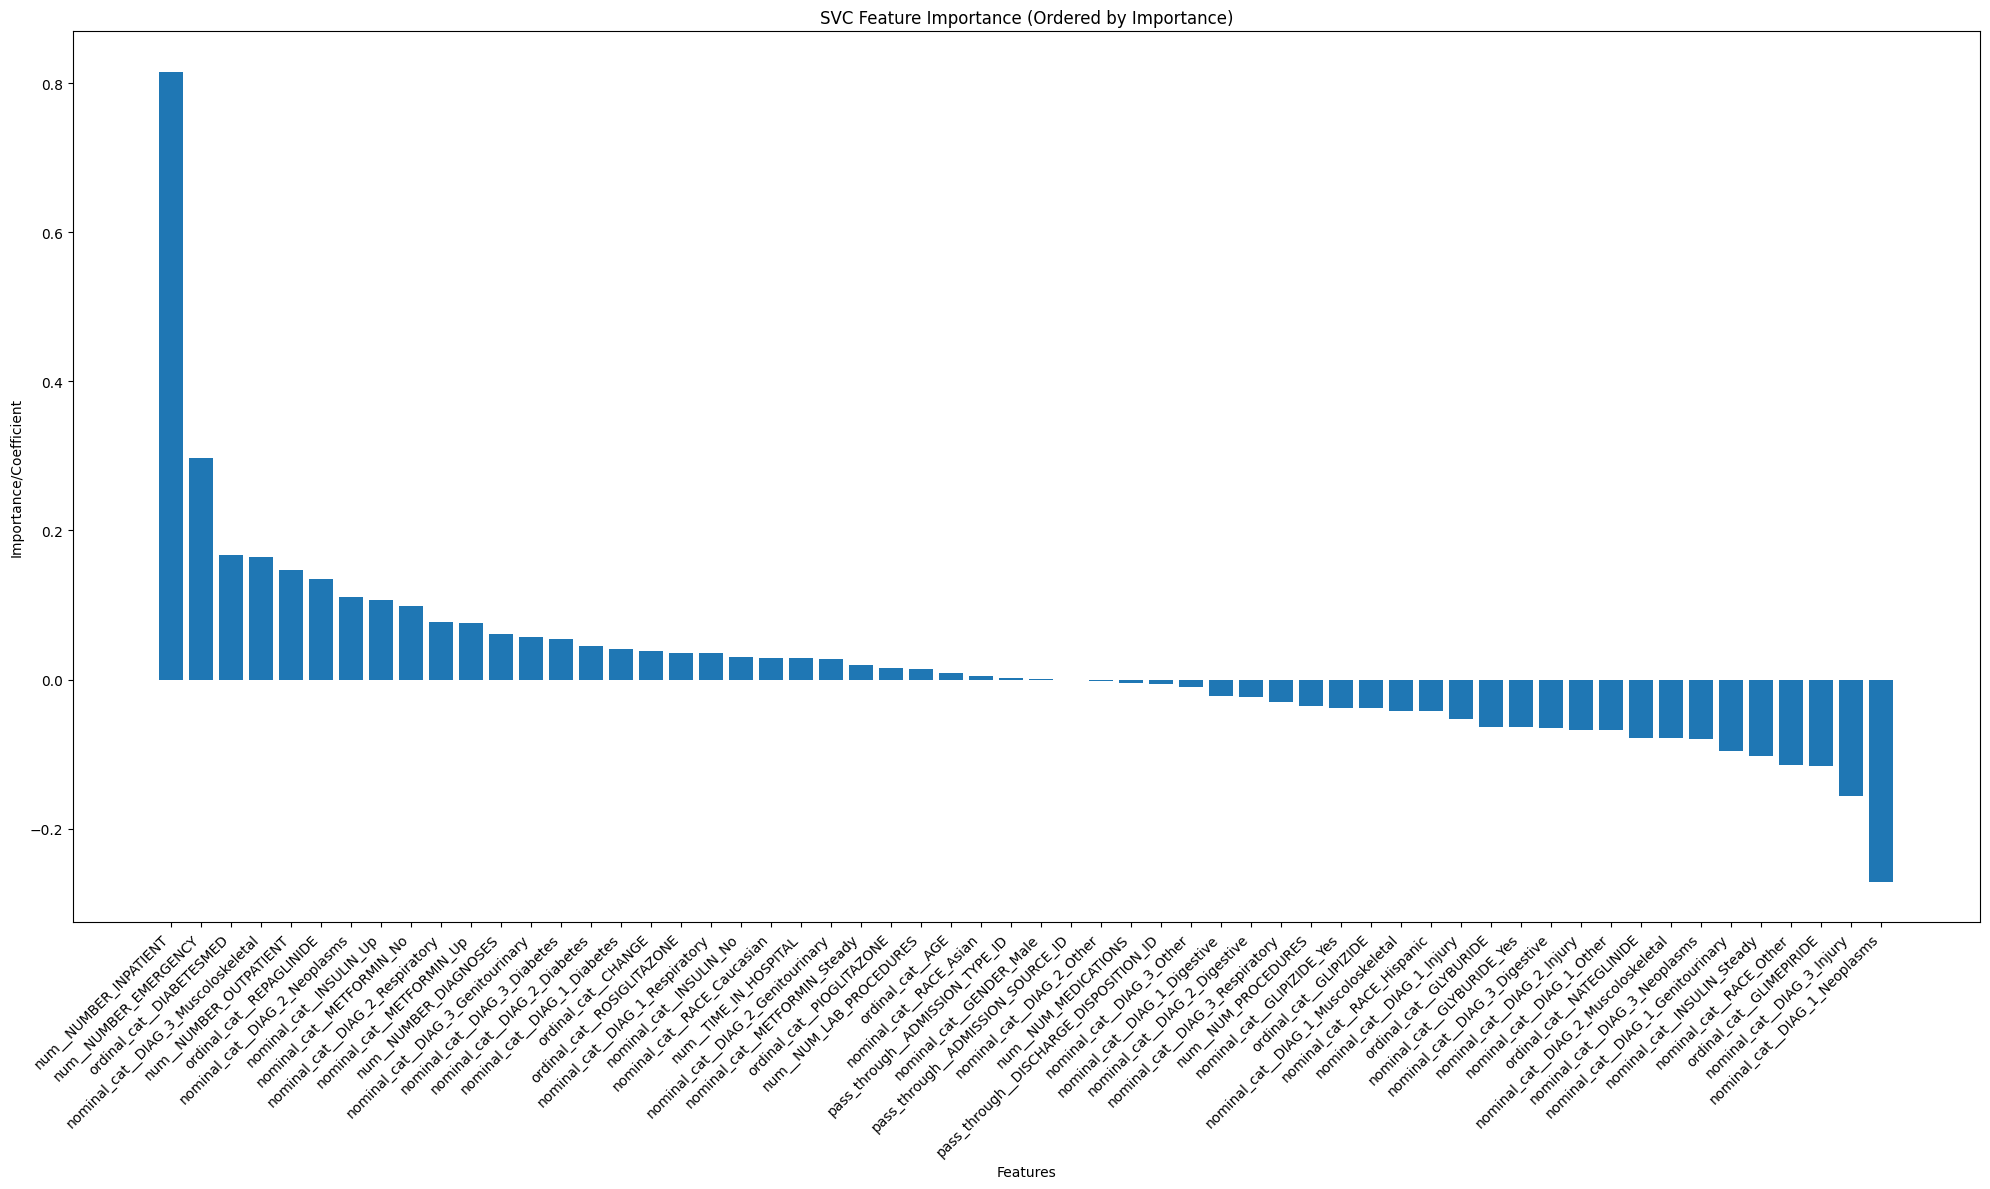

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np

def plot_feature_importance(best_model, model_name, feature_names, preprocessor, X_train, y_train):

    # Remove the prefixes from the parameter names
    model_params = {key.split("__")[-1]: value for key, value in best_model.items()}

    if model_name == "RandomForest":

        model = RandomForestClassifier(**model_params)
        pipeline = Pipeline([("preprocessor", preprocessor), ("randomforest", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        feature_importance = pipeline.named_steps["randomforest"].feature_importances_
    elif model_name == "LogisticRegression":
        model = LogisticRegression(**model_params, solver = 'saga')
        pipeline = Pipeline([("preprocessor", preprocessor), ("logisticregression", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        coefs = pipeline.named_steps["logisticregression"].coef_[0]
        feature_importance = coefs
    elif model_name == "SVC":
        model = SVC(**model_params, probability=True)
        pipeline = Pipeline([("preprocessor", preprocessor), ("svc", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        coefs = pipeline.named_steps["svc"].coef_[0]
        feature_importance = coefs
    else:
        print(f"Feature importance plotting not implemented for {model_name}.")
        return

    feature_importance_df = pd.DataFrame({'Feature': feature_names_after_transform, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(20, 12))

    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])

    plt.xlabel("Features")
    plt.ylabel("Importance/Coefficient")
    plt.title(f"{model_name} Feature Importance (Ordered by Importance)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

best_params = pd.Series([
    {'svc__C': 1, 'svc__kernel': 'linear'},
    {'randomforest__max_depth': 10, 'randomforest__n_estimators': 100},
    {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
], name="Best Parameters")

results = {
    "RandomForest": {"best_params": best_params[1]},
    "LogisticRegression": {"best_params": best_params[2]},
    "SVC": {"best_params": best_params[0]}
}

feature_names = X_train.columns.tolist()

for model_name, result in results.items():
    if model_name in ["RandomForest", "LogisticRegression", "SVC"]:
        plot_feature_importance(result['best_params'], model_name, feature_names, preprocessor, X_train, y_train)

In [ ]:
def plot_feature_importance(best_model, model_name, feature_names, preprocessor, X_train, y_train):

    model_params = {key.split("__")[-1]: value for key, value in best_model.items()}

    if model_name == "RandomForest":
        model = RandomForestClassifier(**model_params)
        pipeline = Pipeline([("preprocessor", preprocessor), ("randomforest", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        feature_importance = pipeline.named_steps["randomforest"].feature_importances_
    elif model_name == "LogisticRegression":
        model = LogisticRegression(**model_params, solver = 'saga')
        pipeline = Pipeline([("preprocessor", preprocessor), ("logisticregression", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        coefs = pipeline.named_steps["logisticregression"].coef_[0]
        feature_importance = coefs
    elif model_name == "SVC":
        model = SVC(**model_params, probability=True)
        pipeline = Pipeline([("preprocessor", preprocessor), ("svc", model)])
        pipeline.fit(X_train, y_train)

        feature_names_after_transform = pipeline.named_steps['preprocessor'].get_feature_names_out()

        coefs = pipeline.named_steps["svc"].coef_[0]
        feature_importance = coefs
    else:
        print(f"Feature importance plotting not implemented for {model_name}.")
        return

    feature_importance_df = pd.DataFrame({'Feature': feature_names_after_transform, 'Importance': feature_importance})

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f"\nFeature Importance for {model_name}:")
    print(feature_importance_df)

best_params = pd.Series([
    {'svc__C': 1, 'svc__kernel': 'linear'},
    {'randomforest__max_depth': 10, 'randomforest__n_estimators': 100},
    {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
], name="Best Parameters")

results = {
    "RandomForest": {"best_params": best_params[1]},
    "LogisticRegression": {"best_params": best_params[2]},
    "SVC": {"best_params": best_params[0]}
}


feature_names = X_train.columns.tolist()

for model_name, result in results.items():
    if model_name in ["RandomForest", "LogisticRegression", "SVC"]:
        plot_feature_importance(result['best_params'], model_name, feature_names, preprocessor, X_train, y_train)


Feature Importance for RandomForest:
                                   Feature  Importance
6                    num__NUMBER_INPATIENT    0.154545
1                  num__NUM_LAB_PROCEDURES    0.070571
3                     num__NUM_MEDICATIONS    0.068573
7                    num__NUMBER_DIAGNOSES    0.053722
0                    num__TIME_IN_HOSPITAL    0.049530
56  pass_through__DISCHARGE_DISPOSITION_ID    0.045338
5                    num__NUMBER_EMERGENCY    0.044965
45                        ordinal_cat__AGE    0.044600
4                   num__NUMBER_OUTPATIENT    0.043351
2                      num__NUM_PROCEDURES    0.035220
57       pass_through__ADMISSION_SOURCE_ID    0.034051
55         pass_through__ADMISSION_TYPE_ID    0.032305
47                ordinal_cat__DIABETESMED    0.012840
26           nominal_cat__DIAG_1_Neoplasms    0.011821
12                nominal_cat__GENDER_Male    0.011410
9              nominal_cat__RACE_Caucasian    0.011286
19                 nominal_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Feature Importance for LogisticRegression:
                                   Feature  Importance
6                    num__NUMBER_INPATIENT    0.489970
47                ordinal_cat__DIABETESMED    0.295357
5                    num__NUMBER_EMERGENCY    0.173184
7                    num__NUMBER_DIAGNOSES    0.170363
4                   num__NUMBER_OUTPATIENT    0.093549
37            nominal_cat__DIAG_3_Diabetes    0.093428
13               nominal_cat__METFORMIN_No    0.075440
9              nominal_cat__RACE_Caucasian    0.059787
21            nominal_cat__DIAG_1_Diabetes    0.057162
36         nominal_cat__DIAG_2_Respiratory    0.054332
0                    num__TIME_IN_HOSPITAL    0.049797
29            nominal_cat__DIAG_2_Diabetes    0.039386
19                 nominal_cat__INSULIN_Up    0.023763
48              ordinal_cat__ROSIGLITAZONE    0.022215
1                  num__NUM_LAB_PROCEDURES    0.020701
28         nominal_cat__DIAG_1_Respiratory    0.020548
45                   

## Task 5 ##

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


best_rf_params = {'max_depth': 10, 'n_estimators': 100}

best_rf_model = RandomForestClassifier(random_state=42, **best_rf_params)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("randomforest", best_rf_model)
])

pipeline.fit(X_train, y_train)

feature_importances = pipeline.named_steps['randomforest'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out(input_features=X_train.columns)

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_15_features = feature_importance_df['Feature'].head(15).tolist()








In [ ]:
top_15_features

['num__NUMBER_INPATIENT',
 'num__NUM_MEDICATIONS',
 'num__NUM_LAB_PROCEDURES',
 'num__NUMBER_DIAGNOSES',
 'pass_through__DISCHARGE_DISPOSITION_ID',
 'ordinal_cat__AGE',
 'num__TIME_IN_HOSPITAL',
 'num__NUMBER_OUTPATIENT',
 'num__NUMBER_EMERGENCY',
 'num__NUM_PROCEDURES',
 'pass_through__ADMISSION_SOURCE_ID',
 'pass_through__ADMISSION_TYPE_ID',
 'nominal_cat__DIAG_1_Neoplasms',
 'nominal_cat__RACE_Caucasian',
 'nominal_cat__INSULIN_Steady']

In [ ]:
X_train

RACE  GENDER      AGE  ADMISSION_TYPE_ID  \
73474        Caucasian    Male  [60-70)                  3   
95861  AfricanAmerican    Male  [50-60)                  3   
63559        Caucasian  Female  [50-60)                  8   
49239        Caucasian    Male  [60-70)                  1   
63475        Caucasian  Female  [70-80)                  3   
...                ...     ...      ...                ...   
27835        Caucasian  Female  [50-60)                  1   
74447        Caucasian  Female  [50-60)                  1   
52528        Caucasian    Male  [80-90)                  5   
43747        Caucasian    Male  [60-70)                  1   
25131        Caucasian    Male  [50-60)                  1   

       DISCHARGE_DISPOSITION_ID  ADMISSION_SOURCE_ID  TIME_IN_HOSPITAL  \
73474                         6                    1                 3   
95861                         1                    1                 1   
63559                         1                    1                 3   
49239                         1                    7                 4   
63475                         1                    7                 2   
...                         ...                  ...               ...   
27835                         1                    7                 4   
74447                         1                    7                 3   
52528                         3                    1                 4   
43747                         1                    7                 4   
25131                         1                    7                11   

       NUM_LAB_PROCEDURES  NUM_PROCEDURES  NUM_MEDICATIONS  ...  NATEGLINIDE  \
73474                   7               1               25  ...           No   
95861                   1               4               10  ...           No   
63559                  35               1               13  ...           No   
49239                  31               0                5  ...           No   
63475                  11               0                5  ...           No   
...                   ...             ...              ...  ...          ...   
27835                  73               2               27  ...           No   
74447                  39               2               16  ...           No   
52528                  49               1               16  ...           No   
43747                  38               4               14  ...           No   
25131                  69               6               31  ...           No   

       GLIMEPIRIDE  GLIPIZIDE GLYBURIDE PIOGLITAZONE ROSIGLITAZONE  INSULIN  \
73474           No         No        No           No            No       No   
95861           No         No        No           No            No       No   
63559           No         No        No           No            No   Steady   
49239           No         No        No          Yes            No       No   
63475           No         No        No           No            No       No   
...            ...        ...       ...          ...           ...      ...   
27835           No         No        No           No           Yes     Down   
74447           No         No        No           No            No   Steady   
52528           No         No        No           No            No       No   
43747          Yes         No        No          Yes            No       No   
25131           No         No        No           No            No   Steady   

      CHANGE DIABETESMED        temp_diag  
73474     No          No  Muscoloskeletal  
95861     No          No      Circulatory  
63559     No         Yes            Other  
49239     No         Yes           Injury  
63475     No          No      Respiratory  
...      ...         ...              ...  
27835     Ch         Yes      Circulatory  
74447     Ch         Yes        Digestive  
52528     No          No        Neoplasms  
43747     Ch         Yes          

In [ ]:
def extract_selected_features(X_train, top_15_features):

    try:
        X_train_selected = X_train[top_15_features]
        return X_train_selected
    except KeyError as e:
        print(f"Error: Details: {e}")

        return pd.DataFrame()



columns = ['RACE', 'GENDER', 'AGE', 'ADMISSION_TYPE_ID',
       'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID', 'TIME_IN_HOSPITAL',
       'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS',
       'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'DIAG_1',
       'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES', 'METFORMIN', 'REPAGLINIDE',
       'NATEGLINIDE', 'GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE', 'PIOGLITAZONE',
       'ROSIGLITAZONE', 'INSULIN', 'CHANGE', 'DIABETESMED', 'temp_diag']



top_15_features = [
    'NUMBER_INPATIENT',
    'NUM_MEDICATIONS',
    'NUM_LAB_PROCEDURES',
    'NUMBER_DIAGNOSES',
    'DISCHARGE_DISPOSITION_ID',
    'AGE',
    'TIME_IN_HOSPITAL',
    'NUMBER_OUTPATIENT',
    'NUMBER_EMERGENCY',
    'NUM_PROCEDURES',
    'ADMISSION_SOURCE_ID',
    'ADMISSION_TYPE_ID',
    'RACE',
    'INSULIN'
]

X_train_selected = extract_selected_features(X_train, top_15_features)
print(X_train_selected)

       NUMBER_INPATIENT  NUM_MEDICATIONS  NUM_LAB_PROCEDURES  \
73474                 0               25                   7   
95861                 0               10                   1   
63559                 0               13                  35   
49239                 2                5                  31   
63475                 0                5                  11   
...                 ...              ...                 ...   
27835                 2               27                  73   
74447                 1               16                  39   
52528                 0               16                  49   
43747                 1               14                  38   
25131                 0               31                  69   

       NUMBER_DIAGNOSES  DISCHARGE_DISPOSITION_ID      AGE  TIME_IN_HOSPITAL  \
73474                 6                         6  [60-70)                 3   
95861                 8                         1  [50-60)             

In [ ]:
X_test_selected = extract_selected_features(X_test, top_15_features)
print(X_train_selected)

       NUMBER_INPATIENT  NUM_MEDICATIONS  NUM_LAB_PROCEDURES  \
73474                 0               25                   7   
95861                 0               10                   1   
63559                 0               13                  35   
49239                 2                5                  31   
63475                 0                5                  11   
...                 ...              ...                 ...   
27835                 2               27                  73   
74447                 1               16                  39   
52528                 0               16                  49   
43747                 1               14                  38   
25131                 0               31                  69   

       NUMBER_DIAGNOSES  DISCHARGE_DISPOSITION_ID      AGE  TIME_IN_HOSPITAL  \
73474                 6                         6  [60-70)                 3   
95861                 8                         1  [50-60)             

In [ ]:
models = {


    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "randomforest__n_estimators": [50, 100, 200],
            "randomforest__max_depth": [None, 10, 20],
        },
    },

}

In [ ]:
non_categorical_features = [
    "TIME_IN_HOSPITAL", "NUM_LAB_PROCEDURES", "NUM_PROCEDURES", "NUM_MEDICATIONS", "NUMBER_OUTPATIENT",
    "NUMBER_EMERGENCY", "NUMBER_INPATIENT", "NUMBER_DIAGNOSES"
]

nominal_categorical_features = [
    "RACE",
      "INSULIN"
]

ordinal_categorical_features = ["AGE"]



pass_through_features = ["ADMISSION_TYPE_ID", "DISCHARGE_DISPOSITION_ID", "ADMISSION_SOURCE_ID"]



In [ ]:
ordinal_categories = [
    age_categories
]


In [ ]:
non_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

nominal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore")),
    ]
)

ordinal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=ordinal_categories)),
    ]
)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", non_categorical_transformer, non_categorical_features),
        ("nominal_cat", nominal_categorical_transformer, nominal_categorical_features),
        ("ordinal_cat", ordinal_categorical_transformer, ordinal_categorical_features),
        ("pass_through", "passthrough", pass_through_features),
    ]
)

In [ ]:
X_train_selected

NUMBER_INPATIENT  NUM_MEDICATIONS  NUM_LAB_PROCEDURES  \
73474                 0               25                   7   
95861                 0               10                   1   
63559                 0               13                  35   
49239                 2                5                  31   
63475                 0                5                  11   
...                 ...              ...                 ...   
27835                 2               27                  73   
74447                 1               16                  39   
52528                 0               16                  49   
43747                 1               14                  38   
25131                 0               31                  69   

       NUMBER_DIAGNOSES  DISCHARGE_DISPOSITION_ID      AGE  TIME_IN_HOSPITAL  \
73474                 6                         6  [60-70)                 3   
95861                 8                         1  [50-60)                 1   
63559                 5                         1  [50-60)                 3   
49239                 9                         1  [60-70)                 4   
63475                 9                         1  [70-80)                 2   
...                 ...                       ...      ...               ...   
27835                 9                         1  [50-60)                 4   
74447                 7                         1  [50-60)                 3   
52528                 9                         3  [80-90)                 4   
43747                 8                         1  [60-70)                 4   
25131                 8                         1  [50-60)                11   

       NUMBER_OUTPATIENT  NUMBER_EMERGENCY  NUM_PROCEDURES  \
73474                  0                 0               1   
95861                  0                 0               4   
63559                  0                 0               1   
49239                  1                 0               0   
63475                  0                 0               0   
...                  ...               ...             ...   
27835                  1                 2               2   
74447                  0                 0               2   
52528                  0                 0               1   
43747                  0                 0               4   
25131                  0                 0               6   

       ADMISSION_SOURCE_ID  ADMISSION_TYPE_ID             RACE INSULIN  
73474                    1                  3        Caucasian      No  
95861                    1                  3  AfricanAmerican      No  
63559                    1                  8        Caucasian  Steady  
49239                    7                  1        Caucasian      No  
63475                    7                  3        Caucasian      No  
...                    ...                ...              ...     ...  
27835                    7                  1        Caucasian    Down  
74447                    7                  1        Caucasian  Steady  
52528                    1                  5        Caucasian      No  
43747                    7                  1        Caucasian      No  
25131                    7                  1        Caucasian  Steady  

[7844 rows x 14 columns]

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
grid_search_results = {}
best_model_results = []

for model_name, model_info in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        (model_name.lower(), model_info["model"]),
    ])

    grid_search = GridSearchCV(pipeline, model_info["params"], cv=cv, scoring="accuracy", n_jobs=-1, verbose=0, return_train_score=True)
    grid_search.fit(X_train_selected, y_train)

    grid_search_results[model_name] = grid_search.cv_results_
    results[model_name] = {}


    best_params = grid_search.best_params_
    print(f"Model: {model_name}")
    print(f"Best Parameters: {best_params}")
    print("-" * 20)

    for i in range(len(grid_search.cv_results_['params'])):
        params = grid_search.cv_results_['params'][i]
        mean_test_score = grid_search.cv_results_['mean_test_score'][i]
        std_test_score = grid_search.cv_results_['std_test_score'][i]
        mean_train_score = grid_search.cv_results_['mean_train_score'][i]
        std_train_score = grid_search.cv_results_['std_train_score'][i]

        best_model = grid_search.best_estimator_.set_params(**params)
        best_model.fit(X_train_selected, y_train)

        y_pred = best_model.predict(X_test_selected)
        y_prob = best_model.predict_proba(X_test_selected)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc_curve = auc(fpr, tpr)

        results[model_name][i] = {
            "params": params,
            "cv_mean_accuracy": mean_test_score,
            "cv_std_accuracy": std_test_score,
            "cv_mean_train_accuracy": mean_train_score,
            "cv_std_train_accuracy": std_train_score,
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob),
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "y_prob": y_prob,
            "fpr": fpr,
            "tpr": tpr,
            "roc_auc_curve": roc_auc_curve,
        }


    best_index = grid_search.best_index_
    best_result = results[model_name][best_index]

    best_model_results.append({
        "Model": model_name,
        "Best Parameters": best_result['params'],
        "CV Mean Accuracy": best_result['cv_mean_accuracy'],
        "CV Std Accuracy": best_result['cv_std_accuracy'],
        "Test Accuracy": best_result['accuracy'],
        "Test Precision": best_result['precision'],
        "Test Recall": best_result['recall'],
        "Test F1-score": best_result['f1'],
        "Test ROC-AUC": best_result['roc_auc'],
        "Confusion Matrix": best_result['confusion_matrix']
    })




best_model_df = pd.DataFrame(best_model_results)

# Print DataFrame
print("\nBest Model Results:")
print(best_model_df)

Model: RandomForest
Best Parameters: {'randomforest__max_depth': 10, 'randomforest__n_estimators': 200}
--------------------

Best Model Results:
          Model  \
0  RandomForest   

                                                      Best Parameters  \
0  {'randomforest__max_depth': 10, 'randomforest__n_estimators': 200}   

   CV Mean Accuracy  CV Std Accuracy  Test Accuracy  Test Precision  \
0          0.628123         0.009592       0.606323        0.624809   

   Test Recall  Test F1-score  Test ROC-AUC          Confusion Matrix  
0     0.436364       0.513854      0.669646  [[781, 245], [527, 408]]  


In [ ]:
table_data = []
for model_name, model_results in results.items():
    for i, result in model_results.items():
        train_mean = result['cv_mean_train_accuracy']
        test_mean = result['cv_mean_accuracy']
        test_std = result['cv_std_accuracy']
        train_std = result['cv_std_train_accuracy']
        table_data.append({
            "Model": model_name,
            "Params": result['params'],
            "CV Mean Accuracy": f"{train_mean:.4f} ± {train_std:.4f}",
            "Test Mean Accuracy": f"{test_mean:.4f} ± {test_std:.4f}",
        })

results_table = pd.DataFrame(table_data)
print(results_table)

          Model  \
0  RandomForest   
1  RandomForest   
2  RandomForest   
3  RandomForest   
4  RandomForest   
5  RandomForest   
6  RandomForest   
7  RandomForest   
8  RandomForest   

                                                                 Params  \
0   {'randomforest__max_depth': None, 'randomforest__n_estimators': 50}   
1  {'randomforest__max_depth': None, 'randomforest__n_estimators': 100}   
2  {'randomforest__max_depth': None, 'randomforest__n_estimators': 200}   
3     {'randomforest__max_depth': 10, 'randomforest__n_estimators': 50}   
4    {'randomforest__max_depth': 10, 'randomforest__n_estimators': 100}   
5    {'randomforest__max_depth': 10, 'randomforest__n_estimators': 200}   
6     {'randomforest__max_depth': 20, 'randomforest__n_estimators': 50}   
7    {'randomforest__max_depth': 20, 'randomforest__n_estimators': 100}   
8    {'randomforest__max_depth': 20, 'randomforest__n_estimators': 200}   

  CV Mean Accuracy Test Mean Accuracy  
0  0.9997 ± 0.0002